# Initialization

## Packages / Directories / Units

In [87]:
## store session
#import dill
#Out = {}
#_oh = {}
#dill.dump_session('kernel-state-ccqe.db')


KeyboardInterrupt



In [1]:
%autosave 0
import os, sys, glob
import pathos.multiprocessing as mp
import re
import fileinput, pickle
import string, array
import itertools
import collections
import numpy as np
import numpy.random as rnd
import numpy.polynomial.polynomial as poly
import scipy.interpolate as interp
import scipy.integrate as integ
import scipy.spatial.transform as trafo
import scipy.optimize as opt
import scipy.special as sf
import matplotlib as mpl
import matplotlib.pyplot as plt
import pylhe
import xml.etree.ElementTree as et
import phasespace
import tensorflow as tf

## Setup up ROOT - it is important that Python finds our own ROOT installation (with Python3 support) first
#sys.path.insert(0, os.path.expanduser('~/software/root-6.22.00/obj/lib/'))
#import ROOT
#ROOT.gROOT.Reset()
import uproot, awkward

# switch off phasespace / tensorflow warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Directories
base_dir = os.path.expanduser("~/cernbox/neutrino-xsecs/")
os.chdir(base_dir)

# Set up matplotlib
mpl.rcParams['text.usetex']    = False
mpl.rcParams['font.family']    = 'serif'
mpl.rcParams['font.size']      = '14'
mpl.rcParams['figure.figsize'] = 6.4, 4.8

# Unit conversion and physical constants
class my_units:
    # Energy and mass
    eV    = 1.
    keV   = 1.e3
    MeV   = 1.e6
    GeV   = 1.e9
    TeV   = 1.e12
    PeV   = 1.e15
    kg    = 5.62e35*eV
    grams = 0.001*kg
    
    # Length and time
    m     = 5.076e6
    meter = m
    km    = 1000*m
    cm    = 0.01*m
    nm    = 1.e-9*m
    fm    = 1.e-15*m
    AU    = 1.4960e11*m
    pc    = 30.857e15*m
    kpc   = 1.e3*pc
    Mpc   = 1.e6*pc
    Gpc   = 1.e9*pc
    ly    = 9460730472580800*m  # light year
    sec   = 1.523e15
    hours = 3600*sec
    days  = 24*hours
    yrs   = 365*days,
    Hz    = 1./sec
    kHz   = 1.e3*Hz
    MHz   = 1.e6*Hz
    GHz   = 1.e9*Hz
    
    barn  = 1.e-24*cm**2
    pb    = 1.e-36*cm**2
    fb    = 1.e-39*cm**2
    
    # Various astrophysical constants
    GN    = 6.708e-39/1e18  # eV^-2, Newton's constant
    MPl   = 1.22093e19*GeV   # Planck mass, PDG 2013
    Msun  = 1.989e30*kg
    Rsun  = 6.9551e8*meter
    
    # cosmology
    h       = 0.688                          # according to Planck, see Wikipedia; HE97
    H0      = h * 100. * km / sec/ Mpc       # Hubble parameter
    rho_c0  = 3. * H0**2/(8. * np.pi * GN)   # critical density today, Kolb Turner eq. (3.14)
    Omega_m = 0.14 / h**2                    # total matter density
    
    # particle physics
    alpha_em = (1./137.035999139)            # electromagnetic fine structure constant (PDG 2018)
    m_e      = 0.5109989461 * MeV            # electron mass (PDG 2018)
    m_mu     = 105.6583745 * MeV             # muon mass (PDG 2018)
    m_tau    = 1776.86 * MeV                 # tau mass (PDG 2018)
    m_p      = 938.2720813 * MeV             # proton mass (PDG 2018)
    m_n      = 939.565413 * MeV              # neutron mass (PDG 2018)
    m_u      = 931.4940954 * MeV             # atomic mass unit (PDG 2018)
    m_pi0    = 134.9768 * MeV                # neutral pion mass (PDG 2020)
    tau_mu   = 2.1969811e-6 * sec            # muon lifetime (PDG 2018)
    
    # PDG codes
    pdg_nu_e   = 12
    pdg_nu_mu  = 14
    pdg_nu_tau = 16
    pdg_e      = 11
    pdg_mu     = 13
    pdg_tau    = 15
    pdg_gamma  = 22
    pdg_pip    = 211
    pdg_pi0    = 111
    pdg_KL     = 130
    pdg_Kp     = 321
    pdg_Ds     = 431

u = my_units()

Autosave disabled


In [2]:
# data type holding data on individual particle
class NuParticle(object):
    def __init__(self, id=0, px=0., py=0., pz=0., E=0.):
        self.id = id
        self.px = px
        self.py = py
        self.pz = pz
        self.E  = E

    def m(self):
        return np.sqrt(max(0., self.E**2 - (self.px**2 + self.py**2 + self.pz**2)))
    
    def p(self):
        return np.sqrt(self.px**2 + self.py**2 + self.pz**2)
    
    def p2(self):
        return self.px**2 + self.py**2 + self.pz**2

    def P(self):
        return np.array([self.px, self.py, self.pz])


# data type holding data on individual event
class NuEvent(object):
    def __init__(self, weight=0., yr=0, X=np.array([0.,0.,0.]), L=0., \
                       E_nu=0., target='', triggers=0):
        self.weight    = weight            # event weight
        self.yr        = yr                # running period in which this event was recorded
        self.X         = X                 # coordinates (x,y,z)
        self.L         = L                 # corresponding oscillation baseline
        self.E_nu      = E_nu              # incoming neutrino energy
        self.target    = target            # Target nucleus (PDG code)
        self.triggers  = triggers          # 0 = not triggered, !=0 = triggered
        self.particles = []                # List of particles


# evaluate a 2d interpolating function on vectors of data (without forming a grid as a direct call would)
# taken from https://stackoverflow.com/questions/47087109/evaluate-the-output-from-scipy-2d-interpolation-along-a-curve
def eval_interp2d_vectorized(f, x, y):
    return interp.dfitpack.bispeu(f.tck[0], f.tck[1], f.tck[2], f.tck[3], f.tck[4], x, y)[0]


# reconstructed neutrino energy for quasielastic events (eq. (1) in https://arxiv.org/abs/1002.2680)
#   Tl    = lepton kinetic energy
#   ml    = lepton mass
#   mN    = mass of inital state nucleon (minus binding energy if any)
#   mNp   = mass of free final state nucleon
#   costh = angle between neutrino beam direction and outgoing lepton
def Enu_reco(Tl, ml, mN, mNp, costh):
    El = Tl + ml
    pl = np.sqrt(np.maximum(0., El**2 - ml**2))
    return 0.5 * (2*El*mN - mN**2 + mNp**2 - ml**2) / (mN - El + costh*pl)

# momentum transfer Q^2 for quasi-elastic events (eq. (2) in https://arxiv.org/abs/1002.2680)
def Q2_qe(Tl, ml, mN, mNp, costh):
    El = Tl + ml
    pl = np.sqrt(np.maximum(0., El**2 - ml**2))
    return -ml**2 + 2.*Enu_reco(Tl, ml, mN, mNp, costh) * (El - pl*costh)

In [3]:
# A few function for working with PDG particle ID codes
def ismeson(pdg_code):
    '''determine if the particle identified by the given PDG code is a meson.
       Following http://pdg.lbl.gov/2019/reviews/rpp2019-rev-monte-carlo-numbering.pdf,
       this is done by checking the fourth digit from the right in pdg_code.
       For mesons, it is always zero.'''
    pdg_code_full = '{:+08d}'.format(int(pdg_code))
    return (pdg_code_full[-4] == '0' and pdg_code_full[-3] != '0' and pdg_code_full[-2] != '0' )

def isbaryon(pdg_code):
    '''determine if the particle identified by the given PDG code is a baryon.
       Following http://pdg.lbl.gov/2019/reviews/rpp2019-rev-monte-carlo-numbering.pdf,
       this is done by checking the 2nd, 3rd, and 4th digit from the right in pdg_code.
       For baryons, all of these are non-zero.'''
    pdg_code_full = '{:+08d}'.format(int(pdg_code))
    return (pdg_code_full[-4] != '0' and pdg_code_full[-3] != '0' and pdg_code_full[-2] != '0' )

def particle_charge(pdg_code):
    '''determine the electric charge of a particle with the given PDG code'''
    s = np.sign(pdg_code)
    quark_charges  = { '1': -1/3,   # d
                       '2': +2/3,   # u
                       '3': -1/3,   # s
                       '4': +2/3,   # c
                       '5': -1/3,   # b
                       '6': +2/3 }  # t
    lepton_charges = { '11': -1,    # electron
                       '12':  0,    # \nu_e
                       '13': -1,    # muon
                       '14':  0,    # \nu_\mu
                       '15': -1,    # tau
                       '16':  0 }   # \nu_\tau
    boson_charges  = { '21':  0,    # gluom
                       '22':  0,    # photon
                       '23':  0,    # Z
                       '24':  1,    # W+
                       '25':  0 }   # SM Higgs boson
    if abs(pdg_code) < 10:
        return s * quark_charges['{:d}'.format(abs(int(pdg_code)))]
    elif abs(pdg_code) < 20:
        return s * lepton_charges['{:d}'.format(abs(int(pdg_code)))]
    elif abs(pdg_code) <= 30:
        return s * boson_charges['{:d}'.format(abs(int(pdg_code)))]
    else:
        pdg_code_str = '{:+08d}'.format(int(pdg_code))        
        if ismeson(pdg_code):
            return s * ( quark_charges[pdg_code_str[-3]] - quark_charges[pdg_code_str[-2]] )
        elif isbaryon(pdg_code):
            return s * sum([ quark_charges[id] for id in pdg_code_str[-4:-1] ])
        else:
            return np.nan

## Global Color and Style Setttings

In [4]:
c_list    = [ plt.cm.get_cmap('autumn')(x) for x in np.linspace(0.0,1.0,10) ]
ls_cycle  = ["-","--","-.",":"]
my_colors = { 'gibuu':    (0,   0,   0.7),
              'nuance':   (0.7, 0,   0.7),
              'nuwro':    (0.7, 0.7, 0),
              'genie-00': c_list[0],
              'genie-01': c_list[1],
              'genie-02': c_list[2],
              'genie-03': c_list[3],
              'genie-04': c_list[4],
              'genie-05': c_list[5],
              'MB_MC':    'gray'
            }

## Load MiniBooNE data and efficiencies

In [5]:
# auxiliary data
mb_pot_nu              = 12.84e20     # protons on target in neutrino mode (https://arxiv.org/abs/1805.12028)
mb_pot_nub             = 11.27e20     # protons on target in antineutrino mode (https://arxiv.org/abs/1805.12028)
mb_density             = 0.85 * u.grams / u.cm**3 # MiniBooNE scintillator density (https://arxiv.org/abs/0806.4201)
mb_r_fid               = 500. * u.cm  # radius of the fiducial volume (https://arxiv.org/abs/1805.12028, appendix)
mb_r_veto              = 610. * u.cm  # outer radius of veto region (see Bill Louis' email from 10.06.2020)
mb_Cherenkov_threshold = 1 / 1.4684   # https://arxiv.org/abs/0806.4201, table 1
mb_total_mass          = 818e3*u.kg                                # MiniBooNE total target mass (https://arxiv.org/abs/1805.12028)
mb_fiducial_mass       = mb_total_mass * (mb_r_fid/mb_r_veto)**3   # MiniBooNE fiducial target mass
mb_n_targets           = { 'e'   : mb_total_mass * 8./(14*u.m_u),  # number of electron in the MiniBooNE target assuming composition CH_2
                           'h'   : mb_total_mass * 2./(14*u.m_u),  # number of H atoms
                           'c12' : mb_total_mass     /(14*u.m_u),  # number of C-12 nuclei
                           'pf'  : mb_total_mass * 2./(14*u.m_u),  # number of free protons
                           'pb'  : mb_total_mass * 6./(14*u.m_u),  # number of bound protons
                           'nb'  : mb_total_mass * 6./(14*u.m_u) } # number of bound neutrons
A_table                = { 'h'   : 1,
                           'c12' : 12 }
mb_target_nucleons     = sum([ A_table[t] * mb_n_targets[t] for t in A_table.keys() ])

# fluxes (https://arxiv.org/abs/1002.2680)
mb_integrated_flux    = 2.88e11 / u.cm**2 * mb_pot_nu/5.58e20 # arXiv:1002.2680, below eq. (3), times ratio in protons on target
mb_flux_nu            = dict([key, values] for key, values in zip(['Elo', 'Ehi', 'mu', 'mub', 'e', 'eb'], np.loadtxt('mb-data/flux/pospolarity_fluxes.dat').T))
mb_flux_nub           = dict([key, values] for key, values in zip(['Elo', 'Ehi', 'mu', 'mub', 'e', 'eb'], np.loadtxt('mb-data/flux/negpolarity_fluxes.dat').T))
mb_flux_nu['Elo']    *= u.GeV
mb_flux_nu['Ehi']    *= u.GeV
mb_flux_nu['mu']     *= 1. / u.cm**2 / (50*u.MeV)
mb_flux_nu['mub']    *= 1. / u.cm**2 / (50*u.MeV)
mb_flux_nu['e']      *= 1. / u.cm**2 / (50*u.MeV)
mb_flux_nu['eb']     *= 1. / u.cm**2 / (50*u.MeV)
mb_flux_nub['Elo']   *= 1. / u.GeV
mb_flux_nub['Ehi']   *= 1. / u.GeV
mb_flux_nub['mu']    *= 1. / u.cm**2 / (50*u.MeV)
mb_flux_nub['mub']   *= 1. / u.cm**2 / (50*u.MeV)
mb_flux_nub['e']     *= 1. / u.cm**2 / (50*u.MeV)
mb_flux_nub['eb']    *= 1. / u.cm**2 / (50*u.MeV)
mb_flux_nu_interp     = dict([[f, interp.interp1d(0.5*(mb_flux_nu['Elo']  + mb_flux_nu['Ehi']),  mb_flux_nu[f], bounds_error=False, fill_value=0.0)] for f in ['mu','mub','e','eb']])
mb_flux_nub_interp    = dict([[f, interp.interp1d(0.5*(mb_flux_nub['Elo'] + mb_flux_nub['Ehi']), mb_flux_nu[f], bounds_error=False, fill_value=0.0)] for f in ['mu','mub','e','eb']])

# cross section as a function of energy (https://arxiv.org/abs/1002.2680)
mb_bin_edges_1d      = np.loadtxt('mb-data/xsec/asne_bin.txt') * u.GeV
mb_bin_widths_1d     = np.diff(mb_bin_edges_1d)
mb_bin_centers_1d    = 0.5 * (mb_bin_edges_1d[:-1] + mb_bin_edges_1d[1:])
mb_xsec_1d           = np.loadtxt('mb-data/xsec/asne_con.txt') * u.cm**2 * 0.5   # factor 0.5 to convert x-secs per target neutron to x-secs per target nucleon
mb_xsec_err_1d       = np.loadtxt('mb-data/xsec/asne_ter.txt') * u.cm**2 * 0.5

# cross section as a function of Q^2
mb_bin_edges_Q2      = np.loadtxt('mb-data/xsec/asqq_bin.txt') * u.GeV**2
mb_bin_widths_Q2     = np.diff(mb_bin_edges_Q2)
mb_bin_centers_Q2    = 0.5 * (mb_bin_edges_Q2[:-1] + mb_bin_edges_Q2[1:])
mb_xsec_Q2           = np.loadtxt('mb-data/xsec/asqq_con.txt') * u.cm**2/u.GeV**2 * 0.5   # factor 0.5 to convert x-secs per target neutron to x-secs per target nucleon
mb_xsec_err_Q2       = np.loadtxt('mb-data/xsec/asqq_err.txt') * u.cm**2/u.GeV**2 * 0.5

# double differential cross sections (https://arxiv.org/abs/1002.2680)
mb_bin_edges_Tmu     = np.loadtxt('mb-data/xsec/aski_bin.txt')[:19] * u.GeV
mb_bin_widths_Tmu    = np.diff(mb_bin_edges_Tmu)
mb_bin_centers_Tmu   = 0.5 *  (mb_bin_edges_Tmu[:-1] + mb_bin_edges_Tmu[1:])
mb_bin_edges_costh   = np.flip(np.loadtxt('mb-data/xsec/aski_bin.txt')[19:])   # bring bins into ascending order in costh
mb_bin_widths_costh  = np.abs(np.diff(mb_bin_edges_costh))
mb_bin_centers_costh = 0.5 *  (mb_bin_edges_costh[:-1] + mb_bin_edges_costh[1:])
mb_xsec_2d           = np.flip(np.loadtxt('mb-data/xsec/aski_con.txt'), axis=0) * 1e-41*u.cm**2/u.GeV * 0.5
mb_xsec_err_2d       = np.flip(np.loadtxt('mb-data/xsec/aski_err.txt'), axis=0) * 1e-42*u.cm**2/u.GeV * 0.5
mb_norm_relerr_2d    = 0.107  # relative normalziation error, see https://arxiv.org/abs/1002.2680, caption of fig. 13
mb_xsec_2d_interp    = interp.interp2d(mb_bin_centers_Tmu, mb_bin_centers_costh, mb_xsec_2d)

# nu-e data from https://arxiv.org/abs/1805.12028
mb_bin_edges_nue         = np.loadtxt('mb-data/nue/miniboone_binboundaries_nue_lowe.txt') * u.MeV
mb_bin_widths_nue        = np.diff(mb_bin_edges_nue)
mb_bin_centers_nue       = 0.5 * (mb_bin_edges_nue[:-1] + mb_bin_edges_nue[1:])
mb_events_nue            = np.loadtxt('mb-data/nue/miniboone_nuedata_lowe.txt')
mb_bg_nue_total          = np.loadtxt('mb-data/nue/miniboone_nuebgr_lowe.txt')
mb_bg_nue_stacked        = np.loadtxt('mb-data/nue/mb-spectrum-1805.12028.dat')[:,1:] * 1/u.MeV * mb_bin_widths_nue[:,None]
mb_bg_nue                = {}
mb_bg_nue['other']       = mb_bg_nue_stacked[:,0]
mb_bg_nue['dirt']        = mb_bg_nue_stacked[:,1] - mb_bg_nue_stacked[:,0]
mb_bg_nue['Delta']       = mb_bg_nue_stacked[:,2] - mb_bg_nue_stacked[:,1]
mb_bg_nue['pi0']         = mb_bg_nue_stacked[:,3] - mb_bg_nue_stacked[:,2]
mb_bg_nue['nue-from-K']  = mb_bg_nue_stacked[:,4] - mb_bg_nue_stacked[:,3]
mb_bg_nue['nue-from-mu'] = mb_bg_nue_stacked[:,5] - mb_bg_nue_stacked[:,4]

# nu-mu control sample from https://arxiv.org/abs/1805.12028
mb_bin_edges_numu        = np.loadtxt('mb-data/nue/miniboone_binboundaries_numu.txt') * u.MeV
mb_bin_widths_numu       = np.diff(mb_bin_edges_numu)
mb_bin_centers_numu      = 0.5 * (mb_bin_edges_numu[:-1] + mb_bin_edges_numu[1:])
mb_pred_numu             = np.loadtxt('mb-data/nue/miniboone_numu.txt')
mb_events_numu           = np.loadtxt('mb-data/nue/miniboone_numudata.txt')

# efficiencies
mb_eff_data              = np.loadtxt('mb-data/eff/mb-eff.dat')
mb_eff_interpol          = interp.interp1d(mb_eff_data[:,0]*u.GeV, mb_eff_data[:,1], bounds_error=False, fill_value=0.)

# electron/gamma efficiencies
mb_eg_eff_data           = np.loadtxt('mb-data/eff/eg-effs.dat')
mb_eg_eff_interpol       = interp.interp1d(mb_eg_eff_data[:,0]*u.MeV, mb_eg_eff_data[:,1], bounds_error=False, fill_value=0.)

# pi^0 efficiencies
mb_pi0_eff_data          = np.loadtxt('mb-data/eff/pi0-effs.dat')
mb_pi0_eff_interpol      = interp.interp1d(mb_pi0_eff_data[:,0]*u.GeV, mb_pi0_eff_data[:,1], bounds_error=False, fill_value='extrapolate')

# muon efficiencies
mb_mu_eff_data          = np.loadtxt('mb-data/eff/mu-eff.dat')
mb_mu_eff_interpol      = interp.interp1d(mb_mu_eff_data[:,0]*u.MeV, mb_mu_eff_data[:,1], bounds_error=False, fill_value=(0.,mb_mu_eff_data[-1,1]))

In [431]:
# Convert MiniBooNE fluxes and convert to GENIE-friendly format
np.savetxt('mb-data/flux/mb-numode-numu.txt',    np.array([0.5*(mb_flux_nu['Elo']+mb_flux_nu['Ehi'])/u.GeV, mb_flux_nu['mu']*u.cm**2*u.GeV]).T)
np.savetxt('mb-data/flux/mb-numode-nue.txt',     np.array([0.5*(mb_flux_nu['Elo']+mb_flux_nu['Ehi'])/u.GeV, mb_flux_nu['e']*u.cm**2*u.GeV]).T)
np.savetxt('mb-data/flux/mb-numode-numubar.txt', np.array([0.5*(mb_flux_nu['Elo']+mb_flux_nu['Ehi'])/u.GeV, mb_flux_nu['mub']*u.cm**2*u.GeV]).T)
np.savetxt('mb-data/flux/mb-numode-nuebar.txt',  np.array([0.5*(mb_flux_nu['Elo']+mb_flux_nu['Ehi'])/u.GeV, mb_flux_nu['eb']*u.cm**2*u.GeV]).T)

np.savetxt('mb-data/flux/mb-nubarmode-numu.txt',    np.array([0.5*(mb_flux_nub['Elo']+mb_flux_nub['Ehi'])/u.GeV, mb_flux_nub['mu']*u.cm**2*u.GeV]).T)
np.savetxt('mb-data/flux/mb-nubarmode-nue.txt',     np.array([0.5*(mb_flux_nub['Elo']+mb_flux_nub['Ehi'])/u.GeV, mb_flux_nub['e']*u.cm**2*u.GeV]).T)
np.savetxt('mb-data/flux/mb-nubarmode-numubar.txt', np.array([0.5*(mb_flux_nub['Elo']+mb_flux_nub['Ehi'])/u.GeV, mb_flux_nub['mub']*u.cm**2*u.GeV]).T)
np.savetxt('mb-data/flux/mb-nubarmode-nuebar.txt',  np.array([0.5*(mb_flux_nub['Elo']+mb_flux_nub['Ehi'])/u.GeV, mb_flux_nub['eb']*u.cm**2*u.GeV]).T)

## MiniBooNE energy resolution

In [6]:
def smear_momentum(p, axis=0):
    """apply MiniBooNE's energy and angular smearing to a momentum
       4-vector p = (px, py, pz, E). p can be a multidimensional array;
       in this case, axis should specify the axis correpsonding to the four
       components of 4-momentum."""
    
    E  = np.take(p, [3],     axis=axis)
    P  = np.take(p, [0,1,2], axis=axis)
    
    # energy resolution taken from Thomas' MiniBooNE code, based on FNAL talk from 11.04.07 slide 24
    dE = rnd.normal(0., np.sqrt(0.08**2 * E/u.GeV + 0.024**2) * u.GeV)
    P  = P * (E+dE)/E
    E += dE

    # angular resolution ~10 degrees (Pedro's email from 15.07.2019) FIXME
    rnd_phi   = 2. * np.pi * rnd.random(E.shape)
    rnd_costh = 2. * rnd.random(E.shape) - 1.
    rnd_sinth = np.sqrt(1. - rnd_costh**2)
    V         = np.concatenate((rnd_sinth * np.cos(rnd_phi), rnd_sinth * np.sin(rnd_phi), rnd_costh), axis=axis)
                                                                                                # random vector on unit sphere
    R         = V - P * np.sum(V*P,axis=axis,keepdims=True)/np.sum(P*P,axis=axis,keepdims=True) # V projected onto the plane orthogonal to P
    alpha     = rnd.normal(scale=10.*np.pi/180.)                                                # smearing angle
    P         = np.cos(alpha) * P + np.sin(alpha) * np.cross(P,R,axisa=axis,axisb=axis,axisc=axis)/np.sqrt(np.sum(P*P,axis=axis,keepdims=True)*np.sum(R*R,axis=axis,keepdims=True))
                                                                                                # apply rotation
    return np.concatenate((P, E), axis=axis)


## Processing GiBUU, GENIE, NuWro, and NUANCE Output

In [7]:
def read_events(event_file,                # name of event file
                analysis='std',            # 'std': keep all events
                file_format='auto',        # 'genie', 'gibuu', 'nuance' or 'auto'
                max_events=np.inf,         # maximum number of events to read
                use_cache=True,            # if True, write event structures to file and reuse them when available
                Nuance_Delta_gamma=True,   # artificially change some Delta(1232) -> pi^0 events to Delta(1232) -> gamma in NUANCE?
                NuWro_Delta_gamma=True,    # artificially change some Delta(1232) -> pi^0 events to Delta(1232) -> gamma in NuWro?
                verbosity=0
               ):           
    
    n_ev         = 0     # total number of events
    events       = []
    aux_data     = []    # extra data contained in '#'-lines in GiBUU LHE files
    pyevent_file = re.sub("\.lhe|\.gtrac\.root|\.root", ".pyevent-{:s}".format(analysis), event_file)
                         # file for storing NuEvent structures for the selected event sample
    pyevent_file_std = re.sub("\.lhe|\.gtrac\.root|\.root", ".pyevent-std", event_file)
                         # the same for the "std" analysis, where all events are accepted
    
    # determine file format
    if file_format == 'auto':
        if re.match('.*\.lhe', event_file):
            file_format = 'gibuu'
        elif re.match('.*\.gtrac.root', event_file):
            file_format = 'genie'
        elif re.match('.*\.root', event_file):
            with uproot.open(event_file) as f:
                if 'NuWro version;1' in f.keys():
                    file_format = 'nuwro'
                else:
                    file_format = 'nuance'
        else:
            sys.stdout.write("ERROR: cannot determine format of file {:s}.\n".format(event_file))
            return []
        
    # Check if we can directly load pre-filled NuEvent/NuParticle data structures from a previous run
    if use_cache and os.path.isfile(pyevent_file) and os.path.getmtime(pyevent_file) > os.path.getmtime(event_file):
        if verbosity > 0:
            print("Reading "+pyevent_file)
        with open(pyevent_file, "rb") as f:
            events = pickle.load(f)
        return events
    
    # if we can't find events from a previous run for this analysis, see if we have events for the "std" analysis
    # (in this case, we need not re-read events from the original files, but we still need to redo the analysis)
    elif use_cache and os.path.isfile(pyevent_file_std) and os.path.getmtime(pyevent_file_std) > os.path.getmtime(event_file):
        if verbosity > 0:
            print("Reading "+pyevent_file_std)
        with open(pyevent_file_std, "rb") as f:
            events = pickle.load(f)
        if len(events) > max_events:
            events = events[:max_events]
    
    # GiBUU LHE files
    elif file_format == 'gibuu':
        fieldnames = [ 'eventtype', 'weight', 'Enu', 'pnu_x', 'pnu_y', 'pnu_z',
                                              'El',  'pl_x',  'pl_y',  'pl_z',
                                              'EN',  'pN_x',  'pN_y',  'pN_z' ]
        
        # Read lines starting with '#' - they contain info on the initial state neutrino
        # then remove them from the input file
        tmp_file = event_file + '.tmp'
        lhe_data = ""
        with open(event_file, 'r') as f_in:
            with open(tmp_file, 'w') as f_out:
                for l in f_in:
                    if l[0] == '#':
                        aux_data.append( dict(zip(fieldnames, map(float, l.split()[2:]))) )
                    else:
                        f_out.write(l)
                
        # Now read the XML part of the file
        for e in pylhe.readLHE(tmp_file):
            ev = NuEvent(E_nu=aux_data[n_ev]['Enu']*u.GeV)
            ev.weight = e.eventinfo.weight * 1e-38 * u.cm**2
            
            # add charged lepton to the event (if there is one) -- determine lepton flavor based on its mass
            p_l = np.array([ aux_data[n_ev][x] for x in ['pl_x','pl_y','pl_z'] ]) * u.GeV
            E_l = aux_data[n_ev]['El'] * u.GeV
            m_l = np.sqrt(max(0., E_l**2 - np.dot(p_l,p_l)))
            for pdg, mm in zip([11,13,15], [u.m_e, u.m_mu, u.m_tau]):
                if np.abs(m_l - mm)/mm < 0.1:
                    id_l = pdg
                    ev.particles.append(NuParticle(id=id_l, px=p_l[0], py=p_l[1], pz=p_l[2], E=E_l))
                    break
#            id_l = [11,13,15][np.abs(m_l - np.array([u.m_e, u.m_mu, u.m_tau])).argmin()]   # this works only if we already know there's a c
#            ev.particles.append(NuParticle(id=id_l, px=p_l[0], py=p_l[1], pz=p_l[2], E=E_l))
                                
            for p in e.particles:
                id = p.id
                P  = np.array([p.px, p.py, p.pz]) * u.GeV
                E  = p.e * u.GeV
                ev.particles.append(NuParticle(id=id, px=P[0], py=P[1], pz=P[2], E=E))
            
            events.append(ev)            
            n_ev = n_ev + 1
            if n_ev >= max_events:
                break

        # delete temporary file
        os.remove(tmp_file)
        
        
    # GENIE gRooTracker files
    elif file_format == 'genie':
        with uproot.open(event_file) as f:
            genie_data   = f['gRooTracker']
            n_ev         = min(max_events, len(genie_data['StdHepPdg'].array()))
            genie_pdg    = np.abs(genie_data['StdHepPdg'].array()[:n_ev])
            genie_status = genie_data['StdHepStatus'].array()[:n_ev]
            genie_p      = genie_data['StdHepP4'].array()[:n_ev] * u.GeV
            genie_xsec   = genie_data['EvtXSec'].array()[:n_ev] * 1e-38*u.cm**2

            # find initial state neutrino  - GENIE always outputs the neutrino first (but to be sure we check)
            if not awkward.all( ( (abs(genie_pdg[:,0]) == u.pdg_nu_e) |
                                  (abs(genie_pdg[:,0]) == u.pdg_nu_mu) |
                                  (abs(genie_pdg[:,0]) == u.pdg_nu_tau) ) & genie_status[:,0] == 0 ):
                raise ValueError('first entry of event record is not an initial state neutrino.')

            for j in range(n_ev):
                # generate event structure
                ev = NuEvent(E_nu=genie_p[j,0,3], weight=genie_xsec[j])

                # add final state particles to event
                for i, this_id in enumerate(genie_pdg[j]):
                    if genie_status[j,i] == 1:
                        ev.particles.append(NuParticle(id=this_id,
                                                       px=genie_p[j,i,0],
                                                       py=genie_p[j,i,1],
                                                       pz=genie_p[j,i,2],
                                                       E=genie_p[j,i,3]))
                events.append(ev)

    # NUANCE Root N-tuple files
    elif file_format == 'nuance':
        with uproot.open(event_file) as f:
            h = f['h100']
            xsec_data   = {}
            xsec_sum    = {}
            xsec_interp = {}
            xsec_data['E'] = h['Enu'].array() * u.MeV
            for proc in ['cc','nc']:
                for fl in ['e','mu']:
                    xsec_data[proc,fl,'pf']  = h['nu'+fl[0]+'_pf'+proc].array() * u.pb
                    xsec_data[proc,fl,'pb']  = h['nu'+fl[0]+'_pb'+proc].array() * u.pb
                    xsec_data[proc,fl,'e']   = h['nu'+fl[0]+'_e'+proc].array()  * u.pb
                    xsec_data[proc,fl,'nb']  = h['nu'+fl[0]+'_nb'+proc].array() * u.pb
                    xsec_data[proc,fl,'c12'] = h['nu'+fl[0]+'_c'+proc].array()  * u.pb \
                                                      - 6*xsec_data[proc,fl,'pb'] - 6*xsec_data[proc,fl,'nb']
                         # NOTE: the x-sec for scattering on C-12 includes also scattering
                         #       on individual nucleons. In the event records, however, target='c12'
                         #       refers only to elastic scattering on the whole nucleus. Therefore,
                         #       we subtract the x-secs for scattering on bound protons and neutrons here
    
                    xsec_data[proc,fl+'b','pf']  = h['anu'+fl[0]+'_pf'+proc[0]].array() * u.pb
                    xsec_data[proc,fl+'b','pb']  = h['anu'+fl[0]+'_pb'+proc[0]].array() * u.pb
                    xsec_data[proc,fl+'b','e']   = h['anu'+fl[0]+'_e'+proc].array()     * u.pb
                    xsec_data[proc,fl+'b','nb']  = h['anu'+fl[0]+'_nb'+proc[0]].array() * u.pb
                    xsec_data[proc,fl+'b','c12'] = h['anu'+fl[0]+'_c'+proc].array()     * u.pb \
                                                      - 6*xsec_data[proc,fl+'b','pb'] - 6*xsec_data[proc,fl+'b','nb']

            for k in xsec_data.keys():
                xsec_interp[k] = interp.interp1d(xsec_data['E'], xsec_data[k], bounds_error=False, fill_value=0.)      
                
            # dictionaries for translating NUANCE internal codes to human-readable form
            proc_dict   = { 0: 'nc', 1: 'cc' }
            flavor_dict = { 12:'e', -12:'eb', 14:'mu', -14:'mub' }
            target_dict = { 11   : 'e',
                            41   : 'c12',
                            2212 : 'pb',
                            2112 : 'nb' }
            targets     = ['e','c12','pb','nb','pf']
            flavors     = ['e','eb','mu','mub']
            
            # normalization factors
            norm = {}
            for t in targets:
                for fl in flavors:
                    norm[t,fl] = mb_n_targets[t] * mb_pot_nu \
                      * integ.quad(lambda E: (xsec_interp['cc',fl,t](E)
                                            + xsec_interp['nc',fl,t](E)) * mb_flux_nu_interp[fl](E), 
                                   min(xsec_data['E']), max(xsec_data['E']))[0]

            # read events
            nuance_data     = f['h3']
            n_ev_cat        = { (tt, ff): 0 for tt in targets for ff in flavors } # number of events for each target
            n_ev            = min(max_events, len(nuance_data['event'].array()))
            nuance_channel  = nuance_data['channel'].array()[:n_ev]        # interaction channel
            nuance_neutrino = nuance_data['neutrino'].array()[:n_ev]       # neutrino IDs
            nuance_leptons  = nuance_data['lepton'].array()[:n_ev]         # lepton IDs
            nuance_hadrons  = nuance_data['hadron'].array()[:n_ev]         # hadron IDs
            nuance_targets  = nuance_data['target'].array()[:n_ev]         # target codes (pb, pf, ...)
            nuance_p_nu     = nuance_data['p_neutrino'].array()[:n_ev]*u.MeV # neutrino momenta
            nuance_p_target = nuance_data['p_targ'].array()[:n_ev]*u.MeV   # target momenta
            nuance_p_lepton = nuance_data['p_lepton'].array()[:n_ev]*u.MeV # lepton momenta
            nuance_p_hadron = nuance_data['p_hadron'].array()[:n_ev]*u.MeV # hadron momenta

            for j in range(n_ev):
                # determine total cros section per nucleon for this neutrino energy
                target = target_dict[nuance_targets[j]]
                if target=='pb' and nuance_p_target[j,4]==0.:  # distinguish bound and free protons
                    target = 'pf'                              # since e.bound is not read correctly, use target momentum
                flavor = flavor_dict[nuance_neutrino[j]]

                # generate event structure - events are weighted by the cross section and the number of target particles
                ev = NuEvent(E_nu=nuance_p_nu[j,0], target=target, weight=1.)
                ev.neutrino_flavor = flavor

                # add final state particles to event
                for i, pid_lepton in enumerate(nuance_leptons[j]):
                    ev.particles.append(NuParticle(id=pid_lepton,
                                        E= nuance_p_lepton[j,i,3],
                                        px=nuance_p_lepton[j,i,2],
                                        py=nuance_p_lepton[j,i,1],
                                        pz=nuance_p_lepton[j,i,0]))
                for i, pid_hadron in enumerate(nuance_hadrons[j]):
                    ev.particles.append(NuParticle(id=pid_hadron,
                                        E= nuance_p_hadron[j,i,3],
                                        px=nuance_p_hadron[j,i,2],
                                        py=nuance_p_hadron[j,i,1],
                                        pz=nuance_p_hadron[j,i,0]))
                events.append(ev)
                n_ev_cat[target,flavor] += 1
                
            if Nuance_Delta_gamma:
                for j, ev in enumerate(events):
                    if 3 <= nuance_channel[j] <= 16:  # events in which a pion is produced in a resonance decay
                        this_pion = None              #   we assume here all of the are \Delta(1232)
                        for p in ev.particles:        #   see NUANCE cards for numbering of RES channels, as well as NUANCE README.TXT file
                            if p.id == u.pdg_pi0:
                                if this_pion is None or this_pion.E < p.E:
                                    this_pion = p
                        BR = 0.0068*1.5 if ev.target=='pf' else 0.0060*1.5/0.625 # BR for Delta -> \gamma decay
                        if this_pion is not None and rnd.random() < BR:          # see https://arxiv.org/abs/2006.16883, p.21
                            this_pion.id  = u.pdg_gamma
                            s             = this_pion.E / this_pion.p()
                            this_pion.px *= s
                            this_pion.py *= s
                            this_pion.pz *= s
            
            # adjust weights
            for j in range(n_ev):
                flavor            = events[j].neutrino_flavor
                target            = events[j].target
                events[j].weight *= norm[target,flavor] / n_ev_cat[target,flavor]
                    
    # NuWro Root N-tuple files
    elif file_format == 'nuwro':
        with uproot.open(event_file) as f:
            weight_array  = f['treeout']['e']['weight'].array() * u.cm**2 # event weights
#            pdg_nu_array  = f['treeout']['e']['in.pdg'].array()[:,0]     # PDG ID of neutrino
            E_in_array    = f['treeout']['e']['in.t'].array() * u.MeV     # energies of incoming particles
            pdg_out_array = f['treeout']['e']['post.pdg'].array()         # PDG IDs of outgoing particles
            E_array       = f['treeout']['e']['post.t'].array() * u.MeV   # energies of outgoing particles
            px_array      = f['treeout']['e']['post.x'].array() * u.MeV   # x-momenta of outgoing particles
            py_array      = f['treeout']['e']['post.y'].array() * u.MeV   # y-momenta of outgoing particles
            pz_array      = f['treeout']['e']['post.z'].array() * u.MeV   # z-momenta of outgoing particles
            np_array      = f['treeout']['e']['par.nucleus_p'].array()
            nn_array      = f['treeout']['e']['par.nucleus_n'].array()

            for j, w in enumerate(weight_array):
                ev = NuEvent(E_nu=E_in_array[j][0], weight=weight_array[j])
                for i, pdg in enumerate(pdg_out_array[j]):
                    ev.particles.append(NuParticle(id=pdg, px=px_array[j][i], py=py_array[j][i], pz=pz_array[j][i], E=E_array[j][i]))
                events.append(ev)            
                n_ev = n_ev + 1
                if n_ev >= max_events:
                    break
                
            if NuWro_Delta_gamma:
                res       = f['treeout']['e']['flag.res'].array()        # flag identifying resonant events
                res_delta = f['treeout']['e']['flag.res_delta'].array()  # flag identifying Delta resonance events
                for j, ev in enumerate(events):
#                    if res[j] and res_delta[j]:  # events with Delta resonance found -> randomly replace neutral pions by photons
                    if res[j]:  # events with Delta resonance found -> randomly replace neutral pions by photons
                        this_pion = None
                        for p in ev.particles:
                            if p.id == u.pdg_pi0:
                                if this_pion is None or this_pion.E < p.E:
                                    this_pion = p
                        BR = 0.0068*1.5 if np_array[j]==1 and nn_array[j]==0 else 0.0060*1.5/0.625 # BR for Delta -> \gamma decay
                        if this_pion is not None and rnd.random() < BR:                            # see https://arxiv.org/abs/2006.16883, p.21
                            this_pion.id  = u.pdg_gamma
                            s             = this_pion.E / this_pion.p()
                            this_pion.px *= s
                            this_pion.py *= s
                            this_pion.pz *= s
                    
    else:
        sys.stdout.write("ERROR: cannot determine format of file {:s}.\n".format(event_file))
        return []

            
    # Run triggers for the chosen analysis
    if analysis == 'std':                   # standard: accept all events
        for ev in events:
            ev.triggers = 1
            
    elif analysis == 'cc':                  # events with exactly one charged lepton (e or mu)
        for ev in events:
            n_l         = len([ p for p in ev.particles if abs(p.id) in [11, 13] ])            
            ev.triggers = 1 if n_l==1 else 0
        
    elif analysis == 'ccqe':                # events with exactly one charged lepton (e or mu) and nothing else
        for ev in events:
            n_l         = len([ p for p in ev.particles if abs(p.id) in [11, 13] ])
            mesons      = [ p for p in ev.particles if ismeson(p.id) ]
            n_mesons    = 0
            # accept pions only if they are above the Cherenkov threshold. For heavier mesons, we assume
            # the decay is always visible
            for m in mesons:
                if abs(m.id) != 211 or m.p2()/m.E**2 > mb_Cherenkov_threshold**2:
                    n_mesons += 1
            ev.triggers = 1 if n_l==1 and n_mesons==0 else 0
        
    elif analysis == 'nc':                  # NC-like events (no charged leptons)
        for j, ev in enumerate(events):
            ev.triggers = 1
            for p in ev.particles:
                if abs(p.id) == 13:         # muon -> reject
                    ev.triggers = 0
                    break
                elif abs(p.id) == 11:       # e+/e- -> reduce weight according to e/gamma efficiency
                    ev.weight *= 1 - mb_eg_eff_interpol(p.E)
                elif np.abs(particle_charge(p.id)) > 1e-10 and p.p2() / p.E**2 > mb_Cherenkov_threshold**2:
                    ev.triggers = 0         # other charged particle above Cherenkov threshod
                    break
#                if abs(p.id) in [11, 13]:
#                    ev.triggers = 0
#                    break

    else:
        sys.stdout.write("ERROR: unknown analysis: " + str(analysis) + "\n")
        return []
    
    # save NuEvent structure to file for more efficient reading next time
    if use_cache:
        if verbosity > 0:
            print("writing ", pyevent_file)
        with open(pyevent_file, "wb") as f:
            pickle.dump([e for e in events if e.triggers], f)

    return events

## Writing human-readable files for Vedran's code

In [10]:
event_files = glob.glob('sim/nuance/mb-all/mb-all-*.root')
for f_in in event_files:
    f_out = re.sub("\.root$", ".dat-new", f_in)
    print("Processing {:s} -> {:s}".format(f_in, f_out))
    all_events = read_events(f_in, use_cache=False)
    with open(f_out, 'w') as f:
        f.write("# NUANCE event file\n")
        f.write("# converted to human-readable format by Joachim Kopp (jkopp@cern.ch)\n")
        f.write("#\n")
        f.write("# NOTE:\n")
        f.write("# - add up the event weights to obtain predicted event numbers in MiniBooNE\n")
        f.write("#   (target mass {:g} kg, {:g} pot)\n".format(mb_total_mass/u.kg, mb_pot_nu))
        f.write("#\n")
        f.write("# Number of events: \n")
        f.write("{:d}\n".format(len(all_events)))
        f.write("#\n")
        f.write("# Format for each event [all energies/momenta in GeV]:\n")
        f.write("#   <no. of particles in event> <weight> <neutrino energy> <target>\n")
        f.write("#   <particle number in event> <PDG ID> <E> <px> <py> <pz>\n")
        f.write("#\n")
        f.write("# Possible target codes are:\n")
        f.write("#   e=electron, c12=coherent scattering on C-12 nucleus, pf=free proton\n")
        f.write("#   pb=proton bound in C-12 nucleus, nb=neutron bound in C-12 nucleus\n")
        for j, ev in enumerate(all_events):
            f.write("{:4d} {:15.10g} {:15.10g} {:s}\n".format(len(ev.particles), ev.weight, ev.E_nu, ev.target))
            for k, p in enumerate(ev.particles):
                f.write("{:4d} {:10d} {:11.5g} {:11.5g} {:11.5g} {:11.5g}\n".format(
                        k, p.id, p.E/u.GeV, p.px/u.GeV, p.py/u.GeV, p.pz/u.GeV))

Processing sim/nuance/mb-all/mb-all-02.root -> sim/nuance/mb-all/mb-all-02.dat-new
Processing sim/nuance/mb-all/mb-all-55.root -> sim/nuance/mb-all/mb-all-55.dat-new
Processing sim/nuance/mb-all/mb-all-43.root -> sim/nuance/mb-all/mb-all-43.dat-new
Processing sim/nuance/mb-all/mb-all-14.root -> sim/nuance/mb-all/mb-all-14.dat-new
Processing sim/nuance/mb-all/mb-all-80.root -> sim/nuance/mb-all/mb-all-80.dat-new
Processing sim/nuance/mb-all/mb-all-38.root -> sim/nuance/mb-all/mb-all-38.dat-new
Processing sim/nuance/mb-all/mb-all-96.root -> sim/nuance/mb-all/mb-all-96.dat-new
Processing sim/nuance/mb-all/mb-all-79.root -> sim/nuance/mb-all/mb-all-79.dat-new
Processing sim/nuance/mb-all/mb-all-59.root -> sim/nuance/mb-all/mb-all-59.dat-new
Processing sim/nuance/mb-all/mb-all-18.root -> sim/nuance/mb-all/mb-all-18.dat-new
Processing sim/nuance/mb-all/mb-all-63.root -> sim/nuance/mb-all/mb-all-63.dat-new
Processing sim/nuance/mb-all/mb-all-34.root -> sim/nuance/mb-all/mb-all-34.dat-new
Proc

# QE energy reconstruction and prediction of $\nu_e$ cross sections on C-12

In [9]:
my_analysis = 'ccqe'

In [10]:
# Read GiBUU events
working_dir                            = {}
working_dir['gibuu','e',  'c12','qe']  = base_dir + 'sim/gibuu/mb-spect/cc-nue-c12-qe/job-0/'
working_dir['gibuu','mu', 'c12','qe']  = base_dir + 'sim/gibuu/mb-spect/cc-numu-c12-qe/job-0/'
working_dir['gibuu','e',  'c12','all'] = base_dir + 'sim/gibuu/mb-spect/cc-nue-c12-all/job-0/'
working_dir['gibuu','mu', 'c12','all'] = base_dir + 'sim/gibuu/mb-spect/cc-numu-c12-all/job-0/'
working_dir['gibuu','eb', 'c12','all'] = base_dir + 'sim/gibuu/mb-spect/cc-nuebar-c12-all/job-0/'
working_dir['gibuu','mub','c12','all'] = base_dir + 'sim/gibuu/mb-spect/cc-numubar-c12-all/job-0/'
working_dir['gibuu','e',  'h',  'all'] = base_dir + 'sim/gibuu/mb-spect/cc-nue-h-all/job-0/'
working_dir['gibuu','mu', 'h',  'all'] = base_dir + 'sim/gibuu/mb-spect/cc-numu-h-all/job-0/'
working_dir['gibuu','eb', 'h',  'all'] = base_dir + 'sim/gibuu/mb-spect/cc-nuebar-h-all/job-0/'
working_dir['gibuu','mub','h',  'all'] = base_dir + 'sim/gibuu/mb-spect/cc-numubar-h-all/job-0/'

event_files  = {}
all_events   = {}
events       = {}
weight_table = {}
E_nu_table   = {}
for k in working_dir.keys():
    sys.stdout.write("Reading events in directory " + working_dir[k] + " ...")
    
    # read events
    event_files[k] = [ working_dir[k] + f for f in os.listdir(working_dir[k]) if re.search(r'EventOutput.Pert.[0-9]+.*\.lhe', f) != None ]
    all_events[k]  = [ read_events(f, analysis=my_analysis, use_cache=False) for f in event_files[k] ]
    all_events[k]  = list(itertools.chain.from_iterable(all_events[k])) # flatten list
    events[k]      = [ ev for ev in all_events[k] if ev.triggers != 0 ]
    
    # create tables
    weight_table[k] = np.array([ ev.weight for ev in events[k] ]) / len(event_files[k])
    E_nu_table[k]   = np.array([ ev.E_nu   for ev in events[k] ])

    sys.stdout.write(" {:d} events, {:d} triggers (-> total weight {:g})\n".format(
                     len(all_events[k]), len(events[k]), np.sum(weight_table[k])))

Reading events in directory /Users/jkopp/cernbox/neutrino-xsecs/sim/gibuu/mb-spect/cc-nue-c12-qe/job-0/ ... 103550 events, 96647 triggers (-> total weight 9.05288e-30)
Reading events in directory /Users/jkopp/cernbox/neutrino-xsecs/sim/gibuu/mb-spect/cc-numu-c12-qe/job-0/ ... 104007 events, 99113 triggers (-> total weight 8.76218e-30)
Reading events in directory /Users/jkopp/cernbox/neutrino-xsecs/sim/gibuu/mb-spect/cc-nue-c12-all/job-0/ ... 183480 events, 135991 triggers (-> total weight 1.26095e-29)
Reading events in directory /Users/jkopp/cernbox/neutrino-xsecs/sim/gibuu/mb-spect/cc-numu-c12-all/job-0/ ... 173321 events, 139236 triggers (-> total weight 1.29257e-29)
Reading events in directory /Users/jkopp/cernbox/neutrino-xsecs/sim/gibuu/mb-spect/cc-nuebar-c12-all/job-0/ ... 146924 events, 99971 triggers (-> total weight 4.70366e-30)
Reading events in directory /Users/jkopp/cernbox/neutrino-xsecs/sim/gibuu/mb-spect/cc-numubar-c12-all/job-0/ ... 80887 events, 64024 triggers (-> tota

In [11]:
# Read GENIE events
#genie_tunes = set([re.match(".*/mb-.*-tune([0-9a-z]*).*", f).group(1)
#                                               for f in glob.glob(base_dir + "sim/genie/events/vedran/mb-*tune*")])
genie_tunes = dict(zip( os.popen("cd sim/genie/events; sed -n -e 's/^.*xsec\([0-9]*\)-run[0-9]*\.gtrac\.root.*/\\1/p' mb-numode-nu*.sh").read().split(),
                        os.popen("cd sim/genie/events; sed -n -e 's/^.*--tune \([^ ]*\) .*/\\1/p' mb-numode-nu*.sh").read().split() ))
for j, t in enumerate(genie_tunes):
    event_files['genie-'+t,'e',  'c12','all'] = glob.glob(base_dir + 'sim/genie/events/mb-numode-nue-c12-xsec{:02d}-run*.gtrac.root'.format(j))
    event_files['genie-'+t,'mu', 'c12','all'] = glob.glob(base_dir + 'sim/genie/events/mb-numode-numu-c12-xsec{:02d}-run*.gtrac.root'.format(j))
    event_files['genie-'+t,'eb', 'c12','all'] = glob.glob(base_dir + 'sim/genie/events/mb-numode-nuebar-c12-xsec{:02d}-run*.gtrac.root'.format(j))
    event_files['genie-'+t,'mub','c12','all'] = glob.glob(base_dir + 'sim/genie/events/mb-numode-numubar-c12-xsec{:02d}-run*.gtrac.root'.format(j))
    event_files['genie-'+t,'e',  'h',  'all'] = glob.glob(base_dir + 'sim/genie/events/mb-numode-nue-h-xsec{:02d}-run*.gtrac.root'.format(j))
    event_files['genie-'+t,'mu', 'h',  'all'] = glob.glob(base_dir + 'sim/genie/events/mb-numode-numu-h-xsec{:02d}-run*.gtrac.root'.format(j))
    event_files['genie-'+t,'eb', 'h',  'all'] = glob.glob(base_dir + 'sim/genie/events/mb-numode-nuebar-h-xsec{:02d}-run*.gtrac.root'.format(j))
    event_files['genie-'+t,'mub','h',  'all'] = glob.glob(base_dir + 'sim/genie/events/mb-numode-numubar-h-xsec{:02d}-run*.gtrac.root'.format(j))
    
xsec_table    = {}
xsec_interpol = {}
for k in event_files.keys():
    if not re.match('genie.*', k[0]):
        continue
        
    sys.stdout.write("Reading sample " + str(k) + " from " + os.path.dirname(event_files[k][0]) + " ...")
    flavor = k[1]
    target = k[2]
    
    # read events
    try:
        max_events      = 200000
        all_events[k]   = [ read_events(f, analysis=my_analysis, max_events=max_events) for f in event_files[k] ]
        all_events[k]   = list(itertools.chain.from_iterable(all_events[k])) # flatten list
        events[k]       = [ ev for ev in all_events[k] if ev.triggers != 0 ]
        weight_table[k] = np.array([ ev.weight for ev in events[k] ])
        E_nu_table[k]   = np.array([ ev.E_nu   for ev in events[k] ])
        
        # extract total number of events from file (we cache only triggered events, but need n_ev for normalization)
        n_ev = 0
        for this_event_file in event_files[k]:
            with uproot.open(this_event_file) as f:
                genie_data = f['gRooTracker']
                n_ev      += min(max_events, len(genie_data['StdHepPdg'].array()))
        
        # Turn MC generator weights into MiniBooNE event rates
        xsec_table[k]    = weight_table[k]
        xsec_interpol[k] = interp.interp1d(E_nu_table[k], xsec_table[k], assume_sorted=False)
        weight_table[k]  = np.ones(len(E_nu_table[k])) * mb_n_targets[target] * mb_pot_nu / n_ev \
                                    * integ.quad(lambda E: xsec_interpol[k](E) * mb_flux_nu_interp[flavor](E), np.min(E_nu_table[k]), np.max(E_nu_table[k]))[0]
        
        sys.stdout.write(" {:d} events, {:d} triggers (-> total weight {:g})\n".format(
                         n_ev, len(events[k]), np.sum(weight_table[k])))
    except:
        events[k]        = []
        weight_table[k]  = []
        E_nu_table[k]    = []
        xsec_table[k]    = []
        xsec_interpol[k] = []
        sys.stdout.write(" ERROR reading file.\n")
        raise

Reading sample ('genie-00', 'e', 'c12', 'all') from /Users/jkopp/cernbox/neutrino-xsecs/sim/genie/events ... 200000 events, 98707 triggers (-> total weight 8218.59)
Reading sample ('genie-00', 'mu', 'c12', 'all') from /Users/jkopp/cernbox/neutrino-xsecs/sim/genie/events ... 200000 events, 108362 triggers (-> total weight 1.39445e+06)
Reading sample ('genie-00', 'eb', 'c12', 'all') from /Users/jkopp/cernbox/neutrino-xsecs/sim/genie/events ... 200000 events, 91610 triggers (-> total weight 311.138)
Reading sample ('genie-00', 'mub', 'c12', 'all') from /Users/jkopp/cernbox/neutrino-xsecs/sim/genie/events ... 200000 events, 99897 triggers (-> total weight 14446.2)
Reading sample ('genie-00', 'e', 'h', 'all') from /Users/jkopp/cernbox/neutrino-xsecs/sim/genie/events ... 200000 events, 7412 triggers (-> total weight 64.776)
Reading sample ('genie-00', 'mu', 'h', 'all') from /Users/jkopp/cernbox/neutrino-xsecs/sim/genie/events ... 200000 events, 5884 triggers (-> total weight 7291.49)
Reading

In [12]:
# Read Nuance events
event_files['nuance','e',  'c12','all'] = glob.glob(base_dir + 'sim/nuance/mb-all/mb-all-*.root')
event_files['nuance','mu', 'c12','all'] = event_files['nuance','e', 'c12','all']
event_files['nuance','eb', 'c12','all'] = event_files['nuance','e', 'c12','all']
event_files['nuance','mub','c12','all'] = event_files['nuance','e', 'c12','all']
event_files['nuance','e',  'h',  'all'] = event_files['nuance','e', 'c12','all']
event_files['nuance','mu', 'h',  'all'] = event_files['nuance','e', 'c12','all']
event_files['nuance','eb', 'h',  'all'] = event_files['nuance','e', 'c12','all']
event_files['nuance','mub','h',  'all'] = event_files['nuance','e', 'c12','all']
event_files['nuance','e', 'c12','ccqe'] = glob.glob(base_dir + 'sim/nuance/mb-ccqe/mb-ccqe-*.root')
event_files['nuance','mu','c12','ccqe'] = event_files['nuance','e', 'c12','ccqe']
event_files['nuance','e', 'h',  'ccqe'] = event_files['nuance','e', 'c12','ccqe']
event_files['nuance','mu','h',  'ccqe'] = event_files['nuance','e', 'c12','ccqe']
for k in event_files.keys():
    if not re.match('nuance.*', k[0]):  # skip event files from other generators
        continue
        
    # read events
    f = k[1]     # flavor
    t = k[2]     # target nucleus
    sys.stdout.write("Reading sample " + str(k) + " from " + event_files[k][0] + " ...")
    target_dict = { 'e':   'e',       # translation from NUANCE target codes into target nucleus IDs
                    'c12': 'c12',
                    'pb':  'c12',
                    'nb':  'c12',
                    'pf':  'h' }
    try:
        all_events[k]   = [ read_events(f, analysis=my_analysis, use_cache=True) for f in event_files[k] ]
        all_events[k]   = list(itertools.chain.from_iterable(all_events[k])) # flatten list        
        events[k]       = [ ev for ev in all_events[k] if ev.triggers!=0 and target_dict[ev.target]==t and ev.neutrino_flavor==f ]
        weight_table[k] = np.array([ ev.weight for ev in events[k] ]) / len(event_files[k]) * (mb_r_veto/(610*u.cm))**3
        E_nu_table[k]   = np.array([ ev.E_nu   for ev in events[k] ])
        
        # Turn MC generator weights into MiniBooNE event rates
#        weight_table[k]  = []
#        xsec_table[k]    = weight_table[k]
#        xsec_interpol[k] = interp.interp1d(E_nu_table[k], xsec_table[k], assume_sorted=False)
#        weight_table[k]  = np.ones(len(E_nu_table[k])) * mb_n_targets[target] * mb_pot_nu / len(all_events[k]) \
#                                    * integ.quad(lambda E: xsec_interpol[k](E) * mb_flux_nu_interp[flavor](E), np.min(E_nu_table[k]), np.max(E_nu_table[k]))[0]
        
        sys.stdout.write(" {:d} events, {:d} triggers (-> total weight {:g})\n".format(
                         len(all_events[k]), len(events[k]), np.sum(weight_table[k])))
    except:
        events[k]        = []
        weight_table[k]  = []
        E_nu_table[k]    = []
        sys.stdout.write(" ERROR reading file.\n")
        raise

Reading sample ('nuance', 'e', 'c12', 'all') from /Users/jkopp/cernbox/neutrino-xsecs/sim/nuance/mb-all/mb-all-02.root ... 2280956 events, 12745 triggers (-> total weight 6197.05)
Reading sample ('nuance', 'mu', 'c12', 'all') from /Users/jkopp/cernbox/neutrino-xsecs/sim/nuance/mb-all/mb-all-02.root ... 2280956 events, 2221897 triggers (-> total weight 1.08044e+06)
Reading sample ('nuance', 'eb', 'c12', 'all') from /Users/jkopp/cernbox/neutrino-xsecs/sim/nuance/mb-all/mb-all-02.root ... 2280956 events, 420 triggers (-> total weight 209.604)
Reading sample ('nuance', 'mub', 'c12', 'all') from /Users/jkopp/cernbox/neutrino-xsecs/sim/nuance/mb-all/mb-all-02.root ... 2280956 events, 19340 triggers (-> total weight 9458.36)
Reading sample ('nuance', 'e', 'h', 'all') from /Users/jkopp/cernbox/neutrino-xsecs/sim/nuance/mb-all/mb-all-02.root ... 2280956 events, 105 triggers (-> total weight 44.4815)
Reading sample ('nuance', 'mu', 'h', 'all') from /Users/jkopp/cernbox/neutrino-xsecs/sim/nuance/

In [13]:
# Read NuWro events
event_files['nuwro','e',  'c12','all'] = [ base_dir+f for f in glob.glob('sim/nuwro/events/mb-nue-c12.root') ]
event_files['nuwro','mu', 'c12','all'] = [ base_dir+f for f in glob.glob('sim/nuwro/events/mb-numu-c12.root') ]
event_files['nuwro','eb', 'c12','all'] = [ base_dir+f for f in glob.glob('sim/nuwro/events/mb-nuebar-c12.root') ]
event_files['nuwro','mub','c12','all'] = [ base_dir+f for f in glob.glob('sim/nuwro/events/mb-numubar-c12.root') ]
event_files['nuwro','e',  'h',  'all'] = [ base_dir+f for f in glob.glob('sim/nuwro/events/mb-nue-h.root') ]
event_files['nuwro','mu', 'h',  'all'] = [ base_dir+f for f in glob.glob('sim/nuwro/events/mb-numu-h.root') ]
event_files['nuwro','eb', 'h',  'all'] = [ base_dir+f for f in glob.glob('sim/nuwro/events/mb-nuebar-h.root') ]
event_files['nuwro','mub','h',  'all'] = [ base_dir+f for f in glob.glob('sim/nuwro/events/mb-numubar-h.root') ]
for k in event_files.keys():
    if not re.match('nuwro.*', k[0]):  # skip event files from other generators
        continue
        
    sys.stdout.write("Reading sample " + str(k) + " from " + os.path.dirname(event_files[k][0]) + " ...")
    flavor = k[1]
    target = k[2]
  
    try:
        all_events[k]    = [ read_events(f, analysis=my_analysis, use_cache=True) for f in event_files[k] ]
        all_events[k]    = list(itertools.chain.from_iterable(all_events[k])) # flatten list        
        events[k]        = [ ev for ev in all_events[k] if ev.triggers!=0 ]
        weight_table[k]  = np.array([ ev.weight for ev in events[k] ])
        E_nu_table[k]    = np.array([ ev.E_nu for ev in events[k] ])
        
        # extract total number of events from file (we cache only triggered events, but need n_ev for normalization)
        n_ev = 0
        for this_event_file in event_files[k]:
            with uproot.open(this_event_file) as f:
                n_ev += len(f['treeout']['e']['weight'].array())
        
        xsec_table[k]    = A_table[target] * weight_table[k]
        xsec_interpol[k] = interp.interp1d(E_nu_table[k], xsec_table[k], assume_sorted=False)
        weight_table[k]  = np.ones(len(E_nu_table[k])) * mb_n_targets[target] * mb_pot_nu / n_ev \
                                    * integ.quad(lambda E: xsec_interpol[k](E) * mb_flux_nu_interp[flavor](E), np.min(E_nu_table[k]), np.max(E_nu_table[k]))[0]
        
        sys.stdout.write(" {:d} events, {:d} triggers (-> total weight {:g})\n".format(
                         n_ev, len(events[k]), np.sum(weight_table[k])))
    except:
        events[k]        = []
        weight_table[k]  = []
        E_nu_table[k]    = []
        sys.stdout.write(" ERROR reading file.\n")
        raise

Reading sample ('nuwro', 'e', 'c12', 'all') from /Users/jkopp/cernbox/neutrino-xsecs/sim/nuwro/events ... 1000000 events, 519948 triggers (-> total weight 6529.75)
Reading sample ('nuwro', 'mu', 'c12', 'all') from /Users/jkopp/cernbox/neutrino-xsecs/sim/nuwro/events ... 1000000 events, 518372 triggers (-> total weight 1.1643e+06)
Reading sample ('nuwro', 'eb', 'c12', 'all') from /Users/jkopp/cernbox/neutrino-xsecs/sim/nuwro/events ... 1000000 events, 519393 triggers (-> total weight 655.012)
Reading sample ('nuwro', 'mub', 'c12', 'all') from /Users/jkopp/cernbox/neutrino-xsecs/sim/nuwro/events ... 1000000 events, 517696 triggers (-> total weight 52616.5)
Reading sample ('nuwro', 'e', 'h', 'all') from /Users/jkopp/cernbox/neutrino-xsecs/sim/nuwro/events ... 1000000 events, 51476 triggers (-> total weight 72.7592)
Reading sample ('nuwro', 'mu', 'h', 'all') from /Users/jkopp/cernbox/neutrino-xsecs/sim/nuwro/events ... 1000000 events, 50910 triggers (-> total weight 12915.8)
Reading sample

In [14]:
# EXPERIMENTAL: save the event records to a file to make them faster to reload
# this should be superseded by the use_cache option of read_events()
#import pickle
#with open('/Users/jkopp/saved-state-ccqe.db','wb') as f:
#    pickle.dump([ [events[k], weight_table[k], E_nu_table[k]] for k in event_files.keys() ], f)

In [15]:
# cross section plots
#plt.hist(E_nu_table['e','c12']/u.GeV,  bins=mb_bin_edges_1d/u.GeV, weights=weight_table['e','c12']/u.cm**2,  histtype='step', color=(0,.7,0))
#plt.hist(E_nu_table['mu','c12']/u.GeV, bins=mb_bin_edges_1d/u.GeV, weights=weight_table['mu','c12']/u.cm**2, histtype='step', color=(0,0,.7))
#plt.errorbar(mb_bin_centers_1d/u.GeV, mb_xsec_1d/u.cm**2, xerr=0.5*mb_bin_widths_1d/u.GeV, yerr=mb_xsec_err_1d/u.cm**2, fmt='none', color='black', capsize=4)
#plt.xlabel('neutrino energy $E_\\nu$ [GeV]')
#plt.ylabel('cross section $d\\sigma/dE_\\nu$ [cm$^2$/GeV]')
#plt.show()

In [16]:
# bin events in T_\ell and \cos\theta (like MiniBooNE)
E_B                 = 34*u.MeV
E_l_table           = {}
T_l_table           = {}
costh_table         = {}
Enu_reco_table      = {}
Q2_table            = {}
dNdE_mc             = {}
dNdE_data           = {}
dNdE_err_data       = {}
dNdE_reco_mc        = {}
dNdE_reco_data      = {}
dNdE_reco_err       = {}
Enu_reco_samples    = {}
Q2_samples          = {}
xsec_relerr_samples = {}
weight_table_2      = {}
dsigma_dTmu_dcosth_mc        = {}
dsigma_dTmu_dcosth_mc_interp = {}
dsigma_dQ2_mc                = {}
dsigma_dQ2_mc_interp         = {}
#for f, t in itertools.product(['e','mu'],['c12']):
for k in events.keys():
    print(k)
    gen = k[0]     # generator
    f   = k[1]     # flavor
    t   = k[2]     # target isotope
    
    # adjust for fiducial volume
    weight_table_2[k] = weight_table[k] * (mb_r_fid/mb_r_veto)**3
    
    # GiBUU / GENIE / NUANCE - MC truth and QE reconstruction
    E_l_table[k]      = np.array([ [ p.E         for p in ev.particles if abs(p.id) in [11,13]]  for ev in events[k] ]).flatten()
    T_l_table[k]      = np.array([ [ p.E - p.m() for p in ev.particles if abs(p.id) in [11,13]]  for ev in events[k] ]).flatten()
    costh_table[k]    = np.array([ [ p.pz/p.p()  for p in ev.particles if abs(p.id) in [11,13]]  for ev in events[k] ]).flatten()
    Enu_reco_table[k] = Enu_reco(T_l_table[k], E_l_table[k] - T_l_table[k], u.m_n - E_B, u.m_p, costh_table[k])
    Q2_table[k]       = Q2_qe(T_l_table[k], E_l_table[k] - T_l_table[k], u.m_n - E_B, u.m_p, costh_table[k])
    if re.match('gibuu', gen):
        dNdE_mc[k]      = np.histogram(E_nu_table[k], bins=mb_bin_edges_1d, weights=weight_table_2[k] * A_table[t] * mb_n_targets[t] * mb_pot_nu \
                              * np.sum((mb_flux_nu['Ehi'] - mb_flux_nu['Elo']) * mb_flux_nu[f]))[0] / mb_bin_widths_1d
        dNdE_reco_mc[k] = np.histogram(Enu_reco_table[k], bins=mb_bin_edges_1d, weights=weight_table_2[k] \
                              * A_table[t] * mb_n_targets[t] * mb_pot_nu \
                              * np.sum((mb_flux_nu['Ehi'] - mb_flux_nu['Elo']) * mb_flux_nu[f]))[0] / mb_bin_widths_1d
    elif re.match('genie|nuance|nuwro', gen):
        dNdE_mc[k]      = np.histogram(E_nu_table[k], bins=mb_bin_edges_1d, weights=weight_table_2[k])[0] / mb_bin_widths_1d
        dNdE_reco_mc[k] = np.histogram(Enu_reco_table[k], bins=mb_bin_edges_1d, weights=weight_table_2[k])[0] / mb_bin_widths_1d
    else:
        print("ERROR: is sample ", k, " from a GiBUU, GENIE, or NUANCE run?")
        continue
    
    # 2d binning and interpolation of MC data (will be used below for converting measured \nu_\mu xsecs to \nu_e xsecs)
    dsigma_dTmu_dcosth_mc[k]        = np.histogram2d(costh_table[k], T_l_table[k], bins=[mb_bin_edges_costh, mb_bin_edges_Tmu],
                                                     weights=weight_table_2[k])[0]
    dsigma_dTmu_dcosth_mc_interp[k] = interp.interp2d(mb_bin_centers_Tmu, mb_bin_centers_costh, dsigma_dTmu_dcosth_mc[k], \
                                                      bounds_error=False, fill_value=0.)
    
    # binning and interpolation of MC data in Q^2 (will be used below for converting measured \nu_\mu xsecs to \nu_e xsecs)
    dsigma_dQ2_mc[k]        = np.histogram(Q2_table[k], bins=mb_bin_edges_Q2, weights=weight_table_2[k])[0]
    dsigma_dQ2_mc_interp[k] = interp.interp1d(mb_bin_centers_Q2, dsigma_dQ2_mc[k], bounds_error=False, fill_value=0.)


# MiniBooNE \nu_\mu rates - from published \nu_\mu CC 1d xsecs
dNdE_data['mu']        = A_table['c12'] * mb_n_targets['c12'] * (mb_r_fid/mb_r_veto)**3 * mb_pot_nu \
                           * mb_flux_nu_interp['mu'](mb_bin_centers_1d) * mb_xsec_1d
dNdE_err_data['mu']    = A_table['c12'] * mb_n_targets['c12'] * (mb_r_fid/mb_r_veto)**3 * mb_pot_nu \
                           * mb_flux_nu_interp['mu'](mb_bin_centers_1d) * mb_xsec_err_1d

# MiniBooNE \nu_\mu rates - from published \nu_\mu CC 2d xsecs
# to compute dN/dE based on the measured double differential x-secs, randomly sample from the corresponding
# double differential distribution, then bin in E_nu_reco (we exploit the fact that MB uses an evenly spaced grid)
Tmu_costh_idx          = rnd.choice(len(mb_bin_centers_Tmu) * len(mb_bin_centers_costh), size=10000, p=mb_xsec_2d.flatten()/np.sum(mb_xsec_2d))
Tmu_samples            = mb_bin_centers_Tmu[Tmu_costh_idx % len(mb_bin_centers_Tmu)] \
                           + (rnd.rand(len(Tmu_costh_idx)) - 0.5) * mb_bin_widths_Tmu[Tmu_costh_idx % len(mb_bin_centers_Tmu)]
costh_samples          = mb_bin_centers_costh[Tmu_costh_idx // len(mb_bin_centers_Tmu)] \
                           + (rnd.rand(len(Tmu_costh_idx)) - 0.5) * mb_bin_widths_costh[Tmu_costh_idx // len(mb_bin_centers_Tmu)]
Enu_reco_samples['mu'] = Enu_reco(Tmu_samples, u.m_mu, u.m_n - E_B, u.m_p, costh_samples)
Q2_samples['mu']       = Q2_qe(Tmu_samples, u.m_mu, u.m_n - E_B, u.m_p, costh_samples)
xsec_relerr_samples['mu'] = np.sqrt(mb_norm_relerr_2d**2 + (mb_xsec_err_2d.flatten()[Tmu_costh_idx]/mb_xsec_2d.flatten()[Tmu_costh_idx])**2)
dNdE_reco_data['mu']   = np.histogram(Enu_reco_samples['mu'], bins=mb_bin_edges_1d)[0] / mb_bin_widths_1d / len(Enu_reco_samples['mu']) \
                           * A_table['c12'] * mb_n_targets['c12'] * (mb_r_fid/mb_r_veto)**3 * mb_integrated_flux \
                           * np.sum(mb_xsec_2d * mb_bin_widths_costh[:,None] * mb_bin_widths_Tmu[None,:])
dNdE_reco_err['mu']    = np.histogram(Enu_reco_samples['mu'], bins=mb_bin_edges_1d, weights=xsec_relerr_samples['mu'])[0] \
                           / mb_bin_widths_1d / len(Enu_reco_samples['mu']) \
                           * A_table['c12'] * mb_n_targets['c12'] * (mb_r_fid/mb_r_veto)**3 * mb_integrated_flux \
                           * np.sum(mb_xsec_2d * mb_bin_widths_costh[:,None] * mb_bin_widths_Tmu[None,:])

# MiniBooNE \nu_e rates - from published \nu_\mu CC 1d xsecs
dNdE_data['e','from-1d']     = dNdE_data['mu']     * dNdE_mc['gibuu','e','c12','all'] / dNdE_mc['gibuu','mu','c12','all']
dNdE_err_data['e','from-1d'] = dNdE_err_data['mu'] * dNdE_mc['gibuu','e','c12','all'] / dNdE_mc['gibuu','mu','c12','all']

# MiniBooNE \nu_e rates - from published \nu_\mu CC 2d xsecs
# use the randomly sampled events from above, but reweight each of them with the ratio of 2d xsecs for e and mu from GiBUU
Enu_reco_samples['e']        = Enu_reco(Tmu_samples, u.m_e, u.m_n - E_B, u.m_p, costh_samples)
emu_ratio_samples_2d         = np.nan_to_num(
                                  eval_interp2d_vectorized(dsigma_dTmu_dcosth_mc_interp['gibuu','e', 'c12','all'], Tmu_samples, costh_samples) \
                                / eval_interp2d_vectorized(dsigma_dTmu_dcosth_mc_interp['gibuu','mu','c12','all'], Tmu_samples, costh_samples) \
                                * mb_flux_nu_interp['e'](Enu_reco_samples['e']) / np.fmax(1e-100, mb_flux_nu_interp['mu'](Enu_reco_samples['mu'])))
xsec_relerr_samples['e']     = xsec_relerr_samples['mu']
dNdE_data['e','from-2d']     = np.histogram( Enu_reco_samples['e'], bins=mb_bin_edges_1d, weights=emu_ratio_samples_2d)[0] \
                                 / mb_bin_widths_1d / len(Enu_reco_samples['mu']) \
                                 * A_table['c12'] * mb_n_targets['c12'] * (mb_r_fid/mb_r_veto)**3 * mb_integrated_flux \
                                 * np.sum(mb_xsec_2d * mb_bin_widths_costh[:,None] * mb_bin_widths_Tmu[None,:])
dNdE_err_data['e','from-2d'] = np.histogram(Enu_reco_samples['e'], bins=mb_bin_edges_1d, weights=emu_ratio_samples_2d*xsec_relerr_samples['e'])[0] \
                                 / mb_bin_widths_1d / len(Enu_reco_samples['mu']) \
                                 * A_table['c12'] * mb_n_targets['c12'] * (mb_r_fid/mb_r_veto)**3 * mb_integrated_flux \
                                 * np.sum(mb_xsec_2d * mb_bin_widths_costh[:,None] * mb_bin_widths_Tmu[None,:])

# MiniBooNE \nu_e rates - from published \nu_\mu CC xsecs as a function of Q2
Q2_samples['e']              = Q2_qe(Tmu_samples, u.m_e, u.m_n - E_B, u.m_p, costh_samples)
emu_ratio_samples_Q2         = np.nan_to_num(
                                  dsigma_dQ2_mc_interp['gibuu','e', 'c12','all'](Q2_samples['e']) / np.fmax(1e-100, dsigma_dQ2_mc_interp['gibuu','mu','c12','all'](Q2_samples['mu'])) \
                                * mb_flux_nu_interp['e'](Enu_reco_samples['e']) / np.fmax(1e-100, mb_flux_nu_interp['mu'](Enu_reco_samples['mu'])) )
dNdE_data['e','from-Q2']     = np.histogram( Enu_reco_samples['e'], bins=mb_bin_edges_1d, weights=emu_ratio_samples_Q2)[0] \
                                 / mb_bin_widths_1d / len(Enu_reco_samples['mu']) \
                                 * A_table['c12'] * mb_n_targets['c12'] * (mb_r_fid/mb_r_veto)**3 * mb_integrated_flux \
                                 * np.sum(mb_xsec_2d * mb_bin_widths_costh[:,None] * mb_bin_widths_Tmu[None,:])
dNdE_err_data['e','from-Q2'] = np.histogram(Enu_reco_samples['e'], bins=mb_bin_edges_1d, weights=emu_ratio_samples_Q2*xsec_relerr_samples['e'])[0] \
                                 / mb_bin_widths_1d / len(Enu_reco_samples['mu']) \
                                 * A_table['c12'] * mb_n_targets['c12'] * (mb_r_fid/mb_r_veto)**3 * mb_integrated_flux \
                                 * np.sum(mb_xsec_2d * mb_bin_widths_costh[:,None] * mb_bin_widths_Tmu[None,:])

('gibuu', 'e', 'c12', 'qe')
('gibuu', 'mu', 'c12', 'qe')
('gibuu', 'e', 'c12', 'all')
('gibuu', 'mu', 'c12', 'all')
('gibuu', 'eb', 'c12', 'all')
('gibuu', 'mub', 'c12', 'all')
('gibuu', 'e', 'h', 'all')
('gibuu', 'mu', 'h', 'all')
('gibuu', 'eb', 'h', 'all')
('gibuu', 'mub', 'h', 'all')
('genie-00', 'e', 'c12', 'all')
('genie-00', 'mu', 'c12', 'all')
('genie-00', 'eb', 'c12', 'all')
('genie-00', 'mub', 'c12', 'all')
('genie-00', 'e', 'h', 'all')
('genie-00', 'mu', 'h', 'all')
('genie-00', 'eb', 'h', 'all')
('genie-00', 'mub', 'h', 'all')
('genie-01', 'e', 'c12', 'all')
('genie-01', 'mu', 'c12', 'all')
('genie-01', 'eb', 'c12', 'all')
('genie-01', 'mub', 'c12', 'all')
('genie-01', 'e', 'h', 'all')
('genie-01', 'mu', 'h', 'all')
('genie-01', 'eb', 'h', 'all')
('genie-01', 'mub', 'h', 'all')
('genie-02', 'e', 'c12', 'all')
('genie-02', 'mu', 'c12', 'all')
('genie-02', 'eb', 'c12', 'all')
('genie-02', 'mub', 'c12', 'all')
('genie-02', 'e', 'h', 'all')
('genie-02', 'mu', 'h', 'all')
('geni

In [17]:
#plt.hist(eval_interp2d_vectorized(dsigma_dTmu_dcosth_gibuu_interp['e', 'c12','all'], Tmu_samples, costh_samples) \
#    / eval_interp2d_vectorized(dsigma_dTmu_dcosth_gibuu_interp['mu','c12','all'], Tmu_samples, costh_samples), bins=20)

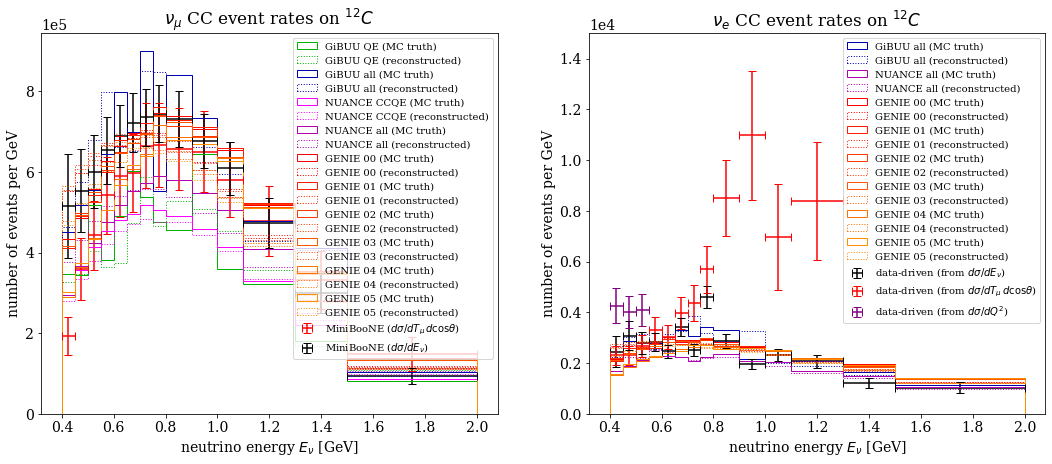

In [17]:
c_list = [ plt.cm.get_cmap('autumn')(x) for x in np.linspace(0.0,1.0,10) ]

# \nu_\mu
plt.figure(figsize=(18,7))
plt.subplot(121)
plt.hist(mb_bin_centers_1d/u.GeV, bins=mb_bin_edges_1d/u.GeV, weights=dNdE_mc['gibuu','mu','c12','qe']*u.GeV,
         label='GiBUU QE (MC truth)', histtype='step', color=(0,.7,0), ls='-')
plt.hist(mb_bin_centers_1d/u.GeV, bins=mb_bin_edges_1d/u.GeV, weights=dNdE_reco_mc['gibuu','mu','c12','qe']*u.GeV,
         label='GiBUU QE (reconstructed)', histtype='step', color=(0,.7,0), ls=':')
plt.hist(mb_bin_centers_1d/u.GeV, bins=mb_bin_edges_1d/u.GeV, weights=dNdE_mc['gibuu','mu','c12','all']*u.GeV,
         label='GiBUU all (MC truth)', histtype='step', color=(0,0,.7), ls='-')
plt.hist(mb_bin_centers_1d/u.GeV, bins=mb_bin_edges_1d/u.GeV, weights=dNdE_reco_mc['gibuu','mu','c12','all']*u.GeV,
         label='GiBUU all (reconstructed)', histtype='step', color=(0,0,.7), ls=':')
plt.hist(mb_bin_centers_1d/u.GeV, bins=mb_bin_edges_1d/u.GeV, weights=dNdE_mc['nuance','mu','c12','ccqe']*u.GeV,
         label=r'NUANCE CCQE (MC truth)', histtype='step', color=(1,0,1), ls='-')
plt.hist(mb_bin_centers_1d/u.GeV, bins=mb_bin_edges_1d/u.GeV, weights=dNdE_reco_mc['nuance','mu','c12','ccqe']*u.GeV,
         label=r'NUANCE CCQE (reconstructed)', histtype='step', color=(1,0,1), ls=':')
plt.hist(mb_bin_centers_1d/u.GeV, bins=mb_bin_edges_1d/u.GeV, weights=dNdE_mc['nuance','mu','c12','all']*u.GeV,
         label=r'NUANCE all (MC truth)', histtype='step', color=(.7,0,.7), ls='-')
plt.hist(mb_bin_centers_1d/u.GeV, bins=mb_bin_edges_1d/u.GeV, weights=dNdE_reco_mc['nuance','mu','c12','all']*u.GeV,
         label=r'NUANCE all (reconstructed)', histtype='step', color=(.7,0,.7), ls=':')
for i, t in enumerate(genie_tunes):
    plt.hist(mb_bin_centers_1d/u.GeV, bins=mb_bin_edges_1d/u.GeV, weights=dNdE_mc['genie-'+t,'mu','c12','all']*u.GeV,
             label='GENIE ' + t + ' (MC truth)', histtype='step', color=c_list[i], ls='-')
    plt.hist(mb_bin_centers_1d/u.GeV, bins=mb_bin_edges_1d/u.GeV, weights=dNdE_reco_mc['genie-'+t,'mu','c12','all']*u.GeV,
             label='GENIE ' + t + ' (reconstructed)', histtype='step', color=c_list[i], ls=':')
#plt.hist(mb_bin_centers_1d/u.GeV, bins=mb_bin_edges_1d/u.GeV, weights=dNdE_reco_data['mu']*u.GeV,
#         label='MiniBooNE ($d\\sigma/dT_\\mu \\, d\\cos\\theta$)', histtype='step', color='black')
plt.errorbar(mb_bin_centers_1d/u.GeV, dNdE_reco_data['mu']*u.GeV, xerr=0.5*mb_bin_widths_1d/u.GeV,
             yerr=dNdE_reco_err['mu']*u.GeV, label='MiniBooNE ($d\\sigma/dT_\\mu \\, d\\cos\\theta$)',
             fmt='none', color='red', capsize=4)
plt.errorbar(mb_bin_centers_1d/u.GeV, dNdE_data['mu']*u.GeV, xerr=0.5*mb_bin_widths_1d/u.GeV,
             yerr=dNdE_err_data['mu']*u.GeV, label='MiniBooNE ($d\\sigma/dE_\\nu$)', 
             fmt='none', color='black', capsize=4)
plt.xlabel('neutrino energy $E_\\nu$ [GeV]')
plt.ylabel('number of events per GeV')
plt.title('$\\nu_\\mu$ CC event rates on ${}^{12}C$')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.legend(loc='upper right', fontsize=10)

# \nu_e
plt.subplot(122)
plt.hist(mb_bin_centers_1d/u.GeV, bins=mb_bin_edges_1d/u.GeV, weights=dNdE_mc['gibuu','e','c12','all']*u.GeV,
         label='GiBUU all (MC truth)', histtype='step', color=(0,0,.7), ls='-')
plt.hist(mb_bin_centers_1d/u.GeV, bins=mb_bin_edges_1d/u.GeV, weights=dNdE_reco_mc['gibuu','e','c12','all']*u.GeV,
         label='GiBUU all (reconstructed)', histtype='step', color=(0,0,.7), ls=':')
plt.hist(mb_bin_centers_1d/u.GeV, bins=mb_bin_edges_1d/u.GeV, weights=dNdE_mc['nuance','e','c12','all']*u.GeV,
         label='NUANCE all (MC truth)', histtype='step', color=(.7,0,.7), ls='-')
plt.hist(mb_bin_centers_1d/u.GeV, bins=mb_bin_edges_1d/u.GeV, weights=dNdE_reco_mc['nuance','e','c12','all']*u.GeV,
         label='NUANCE all (reconstructed)', histtype='step', color=(.7,0,.7), ls=':')
for i, t in enumerate(genie_tunes):
    plt.hist(mb_bin_centers_1d/u.GeV, bins=mb_bin_edges_1d/u.GeV, weights=dNdE_mc['genie-'+t,'e','c12','all']*u.GeV,
             label='GENIE ' + t + ' (MC truth)', histtype='step', color=c_list[i], ls='-')
    plt.hist(mb_bin_centers_1d/u.GeV, bins=mb_bin_edges_1d/u.GeV, weights=dNdE_reco_mc['genie-'+t,'e','c12','all']*u.GeV,
             label='GENIE ' + t + ' (reconstructed)', histtype='step', color=c_list[i], ls=':')
#plt.hist(mb_bin_centers_1d/u.GeV, bins=mb_bin_edges_1d/u.GeV, weights=dNdE_data['e','from-1d']*u.GeV,
#         label='data-driven (from $d\\sigma/dE_\\nu$)', histtype='step', color='black', ls=':')
plt.errorbar(mb_bin_centers_1d/u.GeV, dNdE_data['e','from-1d']*u.GeV, xerr=0.5*mb_bin_widths_1d/u.GeV,
             yerr=dNdE_err_data['e','from-1d']*u.GeV, label='data-driven (from $d\\sigma/dE_\\nu$)',
             fmt='none', color='black', capsize=4)
#plt.hist(mb_bin_centers_1d/u.GeV, bins=mb_bin_edges_1d/u.GeV, weights=dNdE_data['e','from-2d']*u.GeV,
#         label='data-driven (from $d\\sigma/dT_\\mu\\,d\\cos\\theta$)', histtype='step', color='black', ls='-')
plt.errorbar(mb_bin_centers_1d/u.GeV, dNdE_data['e','from-2d']*u.GeV, xerr=0.5*mb_bin_widths_1d/u.GeV,
             yerr=dNdE_err_data['e','from-2d']*u.GeV, label='data-driven (from $d\\sigma/dT_\\mu\\,d\\cos\\theta$)',
             fmt='none', color='red', capsize=4)
plt.errorbar(mb_bin_centers_1d/u.GeV, dNdE_data['e','from-Q2']*u.GeV, xerr=0.5*mb_bin_widths_1d/u.GeV,
             yerr=dNdE_err_data['e','from-Q2']*u.GeV, label='data-driven (from $d\\sigma/dQ^2$)',
             fmt='none', color='purple', capsize=4)
plt.ylim(0,1.5e4)
plt.xlabel('neutrino energy $E_\\nu$ [GeV]')
plt.ylabel('number of events per GeV')
plt.title('$\\nu_e$ CC event rates on ${}^{12}C$')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.legend(loc='upper right', fontsize=10)

plt.savefig('reco-test.pdf', bbox_inches='tight')
plt.show()

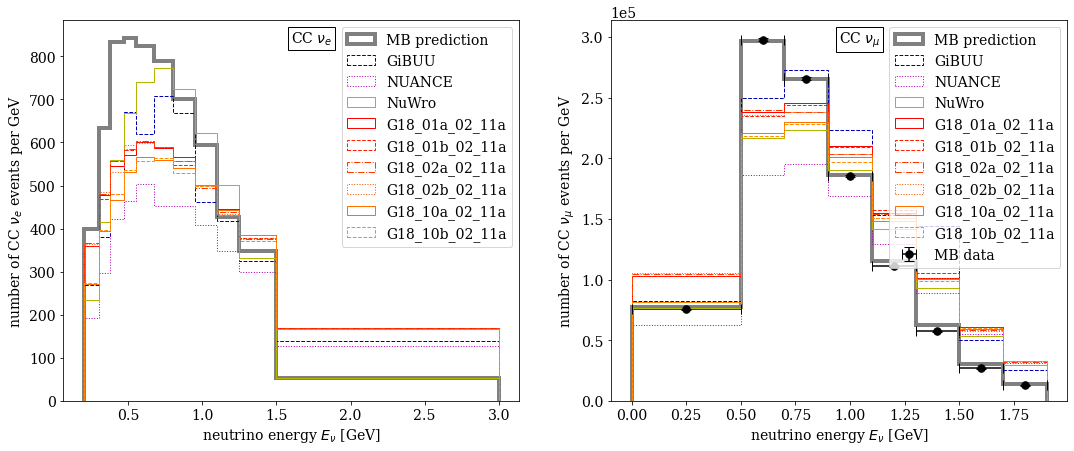

In [18]:
# loop over all generators / tunes
dNdE_CC = {}
for k in events.keys():
    gen = k[0]     # generator
    f   = k[1]     # flavor
    t   = k[2]     # target isotope
    
    # GiBUU / GENIE / NUANCE / NuWro - MC truth and QE reconstruction
    if f == 'e' or f == 'eb':
        if re.match('gibuu', gen):
            # 20% average efficiency based on https://arxiv.org/abs/1805.12028
            dNdE_CC[k] = np.histogram(Enu_reco_table[k], bins=mb_bin_edges_nue, weights=weight_table_2[k]
#                             * mb_eg_eff_interpol(E_l_table[k]) * A_table[t] * mb_n_targets[t] * mb_pot_nu
                             * 0.2 * A_table[t] * mb_n_targets[t] * mb_pot_nu
                             * np.sum((mb_flux_nu['Ehi'] - mb_flux_nu['Elo']) * mb_flux_nu[f]))[0] / mb_bin_widths_nue
        elif re.match('genie|nuance|nuwro', gen):
            dNdE_CC[k] = np.histogram(Enu_reco_table[k], bins=mb_bin_edges_nue,
#                                      weights=mb_eg_eff_interpol(E_l_table[k]) * weight_table_2[k])[0] / mb_bin_widths_nue
                                      weights=0.2 * weight_table_2[k])[0] / mb_bin_widths_nue
        else:
            print("ERROR: is sample ", k, " from a GiBUU, GENIE, NUANCE, or NuWro run?")
            continue
    elif f == 'mu' or f == 'mub':
        if re.match('gibuu', gen):
            # efficiency 35% from Teppei Katori's thesis; see also email exchange from 01.06.2021
            dNdE_CC[k] = np.histogram(Enu_reco_table[k], bins=mb_bin_edges_numu, weights=weight_table_2[k]
#                             * (0.35 * (500*u.cm)**3/mb_r_fid**3) * A_table[t] * mb_n_targets[t] * mb_pot_nu
                             * 0.35 * A_table[t] * mb_n_targets[t] * mb_pot_nu
                             * np.sum((mb_flux_nu['Ehi'] - mb_flux_nu['Elo']) * mb_flux_nu[f]))[0] / mb_bin_widths_numu
                    # make sure sqrt(E_l**2 - m_mu**2) is not NaN (can be in rare cases where a single electron is triggered)
        elif re.match('genie|nuance|nuwro', gen):
            dNdE_CC[k] = np.histogram(Enu_reco_table[k], bins=mb_bin_edges_numu,
#                                      weights=(0.35 * (500*u.cm)**3/mb_r_fid**3) * weight_table_2[k])[0] / mb_bin_widths_numu
                                      weights=0.35 * weight_table_2[k])[0] / mb_bin_widths_numu
        else:
            print("ERROR: is sample ", k, " from a GiBUU, GENIE, NUANCE, or NuWro run?")
            continue
    else:
        raise ValueError('Unknown neutrino flavor: {:s}'.format(f))


plt.figure(figsize=(18,7))
plt.subplot(121)
plt.hist(mb_bin_centers_nue/u.GeV, bins=mb_bin_edges_nue/u.GeV,
         weights=(mb_bg_nue['nue-from-K']+mb_bg_nue['nue-from-mu'])/mb_bin_widths_nue * u.GeV,
         label='MB prediction', histtype='step', color=my_colors['MB_MC'], lw=4)
plt.hist(mb_bin_centers_nue/u.GeV, bins=mb_bin_edges_nue/u.GeV,
         weights=(dNdE_CC['gibuu','e','c12','all']+dNdE_CC['gibuu','e','h','all']+
                  dNdE_CC['gibuu','eb','c12','all']+dNdE_CC['gibuu','eb','h','all'])*u.GeV,
         label='GiBUU', histtype='step', color=my_colors['gibuu'], ls='--')
plt.hist(mb_bin_centers_nue/u.GeV, bins=mb_bin_edges_nue/u.GeV,
         weights=(dNdE_CC['nuance','e','c12','all']+dNdE_CC['nuance','e','h','all']+
                  dNdE_CC['nuance','eb','c12','all']+dNdE_CC['nuance','eb','h','all'])*u.GeV,
         label=r'NUANCE', histtype='step', color=my_colors['nuance'], ls=':')
plt.hist(mb_bin_centers_nue/u.GeV, bins=mb_bin_edges_nue/u.GeV,
         weights=(dNdE_CC['nuwro','e','c12','all']+dNdE_CC['nuwro','e','h','all']+
                  dNdE_CC['nuwro','eb','c12','all']+dNdE_CC['nuwro','eb','h','all'])*u.GeV,
         label=r'NuWro', histtype='step', color=my_colors['nuwro'])
for i, t in enumerate(genie_tunes):
    plt.hist(mb_bin_centers_nue/u.GeV, bins=mb_bin_edges_nue/u.GeV,
             weights=(dNdE_CC['genie-'+t,'e','c12','all']+dNdE_CC['genie-'+t,'e','h','all']+
                      dNdE_CC['genie-'+t,'eb','c12','all']+dNdE_CC['genie-'+t,'eb','h','all'])*u.GeV,
             label=genie_tunes[t], histtype='step', color=my_colors['genie-'+t], ls=ls_cycle[i%len(ls_cycle)])
plt.legend(loc='upper right')
plt.xlabel(r'neutrino energy $E_\nu$ [GeV]')
plt.ylabel(r'number of CC $\nu_e$ events per GeV')
plt.annotate(r'CC $\nu_e$', (0.5,0.94), xycoords='axes fraction',
             bbox=dict(facecolor='#ffffff', pad=3))

plt.subplot(122)
plt.hist(mb_bin_centers_numu/u.GeV, bins=mb_bin_edges_numu/u.GeV, weights=mb_pred_numu/mb_bin_widths_numu * u.GeV,
         label='MB prediction', histtype='step', color=my_colors['MB_MC'], lw=4)
plt.hist(mb_bin_centers_numu/u.GeV, bins=mb_bin_edges_numu/u.GeV,
         weights=(dNdE_CC['gibuu','mu','c12','all']+dNdE_CC['gibuu','mu','h','all']+
                  dNdE_CC['gibuu','mub','c12','all']+dNdE_CC['gibuu','mub','h','all'])*u.GeV,
         label='GiBUU', histtype='step', color=my_colors['gibuu'], ls='--')
plt.hist(mb_bin_centers_numu/u.GeV, bins=mb_bin_edges_numu/u.GeV,
         weights=(dNdE_CC['nuance','mu','c12','all']+dNdE_CC['nuance','mu','h','all']+
                  dNdE_CC['nuance','mub','c12','all']+dNdE_CC['nuance','mub','h','all'])*u.GeV,
         label=r'NUANCE', histtype='step', color=my_colors['nuance'], ls=':')
plt.hist(mb_bin_centers_numu/u.GeV, bins=mb_bin_edges_numu/u.GeV,
         weights=(dNdE_CC['nuwro','mu','c12','all']+dNdE_CC['nuwro','mu','h','all']+
                  dNdE_CC['nuwro','mub','c12','all']+dNdE_CC['nuwro','mub','h','all'])*u.GeV,
         label=r'NuWro', histtype='step', color=my_colors['nuwro'])
for i, t in enumerate(genie_tunes):
    plt.hist(mb_bin_centers_numu/u.GeV, bins=mb_bin_edges_numu/u.GeV,
             weights=(dNdE_CC['genie-'+t,'mu','c12','all']+dNdE_CC['genie-'+t,'mu','h','all']+
                      dNdE_CC['genie-'+t,'mub','c12','all']+dNdE_CC['genie-'+t,'mub','h','all'])*u.GeV,
             label=genie_tunes[t], histtype='step', color=my_colors['genie-'+t], ls=ls_cycle[i%len(ls_cycle)])
plt.errorbar(mb_bin_centers_numu/u.GeV, mb_events_numu/mb_bin_widths_numu*u.GeV,
             xerr=0.5*mb_bin_widths_numu/u.GeV, yerr=np.sqrt(mb_pred_numu)/mb_bin_widths_numu*u.GeV,
             label='MB data', fmt='.', color='black', capsize=5, markersize=15)
plt.legend(loc='upper right')
plt.xlabel(r'neutrino energy $E_\nu$ [GeV]')
plt.ylabel(r'number of CC $\nu_\mu$ events per GeV')
plt.ticklabel_format(style='sci', scilimits=(-3,3))
plt.annotate(r'CC $\nu_\mu$', (0.5,0.94), xycoords='axes fraction',
             bbox=dict(facecolor='#ffffff', pad=3))

plt.savefig('ccqe-spectra.pdf', bbox_inches='tight')
plt.show()

In [20]:
# write histograms to file for global fitting code
mc_generators = set([k[0] for k in events.keys()])
nue_data = {}
for k in mc_generators:
    nue_data[k] = np.stack([mb_bin_centers_nue/u.MeV,
                            (dNdE_CC[k,'e','c12','all']+dNdE_CC[k,'e','h','all'])
                          / (dNdE_CC['nuance','e','c12','all']+dNdE_CC['nuance','e','h','all'])
                          * (mb_bg_nue['nue-from-K']+mb_bg_nue['nue-from-mu']) / mb_bin_widths_nue * u.MeV], axis=1)
    s           = genie_tunes[k[6:]] if re.match('genie-.*', k) else k
    np.savetxt('mb-data/bg/beam-nue-' + s + '.dat', nue_data[k], fmt="%10.5g",
               header="MiniBooNE intrinsic nu-e background\n"
                     +"calculated using generator " + s + "\n"
                     +"  E [MeV]  BG [events/MeV]")
    
numu_data = {}
for k in mc_generators:
    numu_data[k] = np.stack([mb_bin_centers_numu/u.MeV,
                             (dNdE_CC[k,'mu','c12','all']+dNdE_CC[k,'mu','h','all'])
                           / (dNdE_CC['nuance','mu','c12','all']+dNdE_CC['nuance','mu','h','all'])
                           * mb_events_numu / mb_bin_widths_numu * u.MeV], axis=1)
    s            = genie_tunes[k[6:]] if re.match('genie-.*', k) else k
    np.savetxt('mb-data/bg/numu-control-' + s + '.dat', numu_data[k], fmt="%10.5g",
               header="MiniBooNE nu-mu event rate\n"
                     +"calculated using generator " + s + "\n"
                     +"  E [MeV]  BG [events/MeV]")

# Photon backgrounds

### Read events

In [9]:
# read used GENIE tunes from the .sh files
genie_tunes = dict(zip( os.popen("cd sim/genie/events; sed -n -e 's/^.*xsec\([0-9]*\)-run[0-9]*\.gtrac\.root.*/\\1/p' mb-numode-nu*.sh").read().split(),
                        os.popen("cd sim/genie/events; sed -n -e 's/^.*--tune \([^ ]*\) .*/\\1/p' mb-numode-nu*.sh").read().split() ))

# event files with default parameters
mode = "generator-comparison"
event_files = {}
for ch in ['nc','cc']:
    event_files['gibuu','e',  'c12',ch] = [ base_dir+f for f in glob.glob('sim/gibuu/mb-spect/'+ch+'-nue-c12-all/job-*/EventOutput.Pert.*.lhe') ]
    event_files['gibuu','mu', 'c12',ch] = [ base_dir+f for f in glob.glob('sim/gibuu/mb-spect/'+ch+'-numu-c12-all/job-*/EventOutput.Pert.*.lhe') ]
    event_files['gibuu','eb', 'c12',ch] = [ base_dir+f for f in glob.glob('sim/gibuu/mb-spect/'+ch+'-nuebar-c12-all/job-*/EventOutput.Pert.*.lhe') ]
    event_files['gibuu','mub','c12',ch] = [ base_dir+f for f in glob.glob('sim/gibuu/mb-spect/'+ch+'-numubar-c12-all/job-*/EventOutput.Pert.*.lhe') ]
    event_files['gibuu','e',  'h',  ch] = [ base_dir+f for f in glob.glob('sim/gibuu/mb-spect/'+ch+'-nue-h-all/job-*/EventOutput.Pert.*.lhe') ]
    event_files['gibuu','mu', 'h',  ch] = [ base_dir+f for f in glob.glob('sim/gibuu/mb-spect/'+ch+'-numu-h-all/job-*/EventOutput.Pert.*.lhe') ]
    event_files['gibuu','eb', 'h',  ch] = [ base_dir+f for f in glob.glob('sim/gibuu/mb-spect/'+ch+'-nuebar-h-all/job-*/EventOutput.Pert.*.lhe') ]
    event_files['gibuu','mub','h',  ch] = [ base_dir+f for f in glob.glob('sim/gibuu/mb-spect/'+ch+'-numubar-h-all/job-*/EventOutput.Pert.*.lhe') ]
event_files['nuance','all','all'] = [ base_dir+f for f in glob.glob('sim/nuance/mb-all/mb-all-*.root') ]
event_files['nuwro','e',  'c12']  = [ base_dir+f for f in glob.glob('sim/nuwro/events/mb-nue-c12.root') ]
event_files['nuwro','mu', 'c12']  = [ base_dir+f for f in glob.glob('sim/nuwro/events/mb-numu-c12.root') ]
event_files['nuwro','eb', 'c12']  = [ base_dir+f for f in glob.glob('sim/nuwro/events/mb-nuebar-c12.root') ]
event_files['nuwro','mub','c12']  = [ base_dir+f for f in glob.glob('sim/nuwro/events/mb-numubar-c12.root') ]
event_files['nuwro','e',  'h']    = [ base_dir+f for f in glob.glob('sim/nuwro/events/mb-nue-h.root') ]
event_files['nuwro','mu', 'h']    = [ base_dir+f for f in glob.glob('sim/nuwro/events/mb-numu-h.root') ]
event_files['nuwro','eb', 'h']    = [ base_dir+f for f in glob.glob('sim/nuwro/events/mb-nuebar-h.root') ]
event_files['nuwro','mub','h']    = [ base_dir+f for f in glob.glob('sim/nuwro/events/mb-numubar-h.root') ]
for t in genie_tunes.keys():
    event_files['genie-'+t,'e',  'c12'] = [ base_dir + 'sim/genie/events/mb-numode-nue-c12-xsec'+t+'-run0.gtrac.root' ]
    event_files['genie-'+t,'mu', 'c12'] = [ base_dir + 'sim/genie/events/mb-numode-numu-c12-xsec'+t+'-run0.gtrac.root' ]
    event_files['genie-'+t,'eb', 'c12'] = [ base_dir + 'sim/genie/events/mb-numode-nuebar-c12-xsec'+t+'-run0.gtrac.root' ]
    event_files['genie-'+t,'mub','c12'] = [ base_dir + 'sim/genie/events/mb-numode-numubar-c12-xsec'+t+'-run0.gtrac.root' ]
    event_files['genie-'+t,'e',  'h']   = [ base_dir + 'sim/genie/events/mb-numode-nue-h-xsec'+t+'-run0.gtrac.root' ]
    event_files['genie-'+t,'mu', 'h']   = [ base_dir + 'sim/genie/events/mb-numode-numu-h-xsec'+t+'-run0.gtrac.root' ]
    event_files['genie-'+t,'eb', 'h']   = [ base_dir + 'sim/genie/events/mb-numode-nuebar-h-xsec'+t+'-run0.gtrac.root' ]
    event_files['genie-'+t,'mub','h']   = [ base_dir + 'sim/genie/events/mb-numode-numubar-h-xsec'+t+'-run0.gtrac.root' ]

# # event files for n-dimensional parameter scans
# mode = "param-scan-full"
# event_files = {}
# event_files['nuance','all','all'] = [ base_dir+f for f in glob.glob('sim/nuance/mb-all/mb-all-*.root') ]
# for this_dir in glob.glob('sim/gibuu/br-scan/full-scan/nc-numu-c12/job-*'):  # loop over all runs, assuming we use the same number of runs for all samples
#     k = re.match('.*job-([0-9]*)', this_dir).group(1)
#     for ch in ['nc','cc']:
#         event_files['gibuu-'+k,'e',  'c12',ch] = [ base_dir+f for f in glob.glob('sim/gibuu/br-scan/full-scan/'+ch+'-nue-c12/job-'+k+'/EventOutput.Pert.*.lhe') ]
#         event_files['gibuu-'+k,'mu', 'c12',ch] = [ base_dir+f for f in glob.glob('sim/gibuu/br-scan/full-scan/'+ch+'-numu-c12/job-'+k+'/EventOutput.Pert.*.lhe') ]
#         event_files['gibuu-'+k,'eb', 'c12',ch] = [ base_dir+f for f in glob.glob('sim/gibuu/br-scan/full-scan/'+ch+'-nuebar-c12/job-'+k+'/EventOutput.Pert.*.lhe') ]
#         event_files['gibuu-'+k,'mub','c12',ch] = [ base_dir+f for f in glob.glob('sim/gibuu/br-scan/full-scan/'+ch+'-numubar-c12/job-'+k+'/EventOutput.Pert.*.lhe') ]
#         event_files['gibuu-'+k,'e',  'h',  ch] = [ base_dir+f for f in glob.glob('sim/gibuu/br-scan/full-scan/'+ch+'-nue-h/job-'+k+'/EventOutput.Pert.*.lhe') ]
#         event_files['gibuu-'+k,'mu', 'h',  ch] = [ base_dir+f for f in glob.glob('sim/gibuu/br-scan/full-scan/'+ch+'-numu-h/job-'+k+'/EventOutput.Pert.*.lhe') ]
#         event_files['gibuu-'+k,'eb', 'h',  ch] = [ base_dir+f for f in glob.glob('sim/gibuu/br-scan/full-scan/'+ch+'-nuebar-h/job-'+k+'/EventOutput.Pert.*.lhe') ]
#         event_files['gibuu-'+k,'mub','h',  ch] = [ base_dir+f for f in glob.glob('sim/gibuu/br-scan/full-scan/'+ch+'-numubar-h/job-'+k+'/EventOutput.Pert.*.lhe') ]   
# for ch in ['nc','cc']:
#     event_files['gibuu','e',  'c12',ch] = [ base_dir+f for f in glob.glob('sim/gibuu/mb-spect/'+ch+'-nue-c12-all/job-*/EventOutput.Pert.*.lhe') ]
#     event_files['gibuu','mu', 'c12',ch] = [ base_dir+f for f in glob.glob('sim/gibuu/mb-spect/'+ch+'-numu-c12-all/job-*/EventOutput.Pert.*.lhe') ]
#     event_files['gibuu','eb', 'c12',ch] = [ base_dir+f for f in glob.glob('sim/gibuu/mb-spect/'+ch+'-nuebar-c12-all/job-*/EventOutput.Pert.*.lhe') ]
#     event_files['gibuu','mub','c12',ch] = [ base_dir+f for f in glob.glob('sim/gibuu/mb-spect/'+ch+'-numubar-c12-all/job-*/EventOutput.Pert.*.lhe') ]
#     event_files['gibuu','e',  'h',  ch] = [ base_dir+f for f in glob.glob('sim/gibuu/mb-spect/'+ch+'-nue-h-all/job-*/EventOutput.Pert.*.lhe') ]
#     event_files['gibuu','mu', 'h',  ch] = [ base_dir+f for f in glob.glob('sim/gibuu/mb-spect/'+ch+'-numu-h-all/job-*/EventOutput.Pert.*.lhe') ]
#     event_files['gibuu','eb', 'h',  ch] = [ base_dir+f for f in glob.glob('sim/gibuu/mb-spect/'+ch+'-nuebar-h-all/job-*/EventOutput.Pert.*.lhe') ]
#     event_files['gibuu','mub','h',  ch] = [ base_dir+f for f in glob.glob('sim/gibuu/mb-spect/'+ch+'-numubar-h-all/job-*/EventOutput.Pert.*.lhe') ]

# # event files for a set of 1-dimensional parameter scans
# mode = "param-scan-1d"
# event_files = {}
# event_files['nuance','all','all'] = [ base_dir+f for f in glob.glob('sim/nuance/mb-all/mb-all-*.root') ]
# for this_dir in glob.glob('sim/gibuu/br-scan/1d-scans/nc-numu-c12/job-*'):
#     k = re.match('.*job-([0-9]*)', this_dir).group(1)
#     event_files['gibuu-'+k,'mu','c12']  = [ base_dir+f for f in glob.glob(this_dir+'/EventOutput.Pert.*.lhe') ]

n_ev          = {}
all_events    = {}
events        = {}
weight_table  = {}
E_nu_table    = {}
xsec_table    = {}
xsec_interpol = {}
for k in list(event_files.keys()).copy():
    sys.stdout.write("Reading events for sample " + str(k) + " ...")
    flavor = k[1]
    target = k[2]
    
    # read events
    try:
#        with mp.Pool(processes=2) as pool:
#            all_events[k] = pool.map(lambda f: read_events(f, analysis='nc'), event_files[k])
#        all_events[k] = map(lambda f: read_events(f, analysis='nc'), event_files[k])
        all_events[k] = [ read_events(f, analysis='nc', use_cache=True, verbosity=0) for f in event_files[k] ]
        all_events[k] = list(itertools.chain.from_iterable(all_events[k])) # flatten list
        n_ev[k]       = len(all_events[k])
        events[k]     = [ ev for ev in all_events[k] if ev.triggers != 0 ]
        if len(events[k]) <= 0: # remove runs that do not contribute to this sample at all
            del event_files[k]
            sys.stdout.write("  {:d} events, {:d} triggers -> sample discarded\n".format(n_ev[k], len(events[k])))
            continue
        
        weight_table[k] = np.array([ ev.weight for ev in events[k] ])
        E_nu_table[k]   = np.array([ ev.E_nu   for ev in events[k] ])
        
        # Turn MC generator weights into MiniBooNE event rates
        if re.match(r'gibuu.*', k[0]):
            weight_table[k] *= A_table[target] * mb_n_targets[target] * mb_pot_nu * np.sum((mb_flux_nu['Ehi']-mb_flux_nu['Elo'])*mb_flux_nu[flavor]) / len(event_files[k])

        elif re.match(r'genie.*', k[0]):
            # extract total number of events from file (we cache only triggered events, but need n_ev for normalization)
            n_ev[k] = 0
            for this_event_file in event_files[k]:
                with uproot.open(this_event_file) as f:
                    genie_data = f['gRooTracker']
                    n_ev[k]   += len(genie_data['StdHepPdg'].array())

            xsec_table[k]    = weight_table[k]
            xsec_interpol[k] = interp.interp1d(E_nu_table[k], xsec_table[k], assume_sorted=False)
            weight_table[k]  = np.ones(len(E_nu_table[k])) * mb_n_targets[target] * mb_pot_nu / n_ev[k] \
                                        * integ.quad(lambda E: xsec_interpol[k](E) * mb_flux_nu_interp[flavor](E), np.min(E_nu_table[k]), np.max(E_nu_table[k]))[0]
        elif re.match(r'nuance.*', k[0]):
            # NUANCE works with a sphere of 610 cm radius - make sure it is rescaled to the same size as the other samples
            weight_table[k]  = weight_table[k] / len(event_files[k]) * mb_r_veto**3 / (610.*u.cm)**3
        elif re.match(r'nuwro.*', k[0]):
            # extract total number of events from file (we cache only triggered events, but need n_ev for normalization)
            n_ev[k] = 0
            for this_event_file in event_files[k]:
                with uproot.open(this_event_file) as f:
                    n_ev[k] += len(f['treeout']['e']['weight'].array())

            xsec_table[k]    = A_table[target] * weight_table[k]
            xsec_interpol[k] = interp.interp1d(E_nu_table[k], xsec_table[k], assume_sorted=False)
            weight_table[k]  = np.ones(len(E_nu_table[k])) * mb_n_targets[target] * mb_pot_nu / n_ev[k] \
                                        * integ.quad(lambda E: xsec_interpol[k](E) * mb_flux_nu_interp[flavor](E), np.min(E_nu_table[k]), np.max(E_nu_table[k]))[0]
        else:
            print("ERROR: is {:s} from a GiBUU, GENIE, NuWro, or Nuance run?".format(event_files[k][0]))
            del event_files[k]
        
        sys.stdout.write(" {:d} events, {:d} triggers (-> {:g} events in MB)\n"
                         .format(n_ev[k], len(events[k]), np.sum(weight_table[k])))
    except:
        events[k]        = []
        weight_table[k]  = []
        E_nu_table[k]    = []
        xsec_table[k]    = []
        xsec_interpol[k] = []
        del event_files[k]
        sys.stdout.write(" ERROR reading file.\n")

        raise

Reading events for sample ('gibuu', 'e', 'c12', 'nc') ... 183274 events, 183274 triggers (-> 3190.04 events in MB)
Reading events for sample ('gibuu', 'mu', 'c12', 'nc') ... 200284 events, 200284 triggers (-> 574964 events in MB)
Reading events for sample ('gibuu', 'eb', 'c12', 'nc') ... 140370 events, 140370 triggers (-> 146.879 events in MB)
Reading events for sample ('gibuu', 'mub', 'c12', 'nc') ... 107680 events, 107680 triggers (-> 8300.68 events in MB)
Reading events for sample ('gibuu', 'e', 'h', 'nc') ... 13521 events, 13521 triggers (-> 433.431 events in MB)
Reading events for sample ('gibuu', 'mu', 'h', 'nc') ... 14876 events, 14876 triggers (-> 70839.2 events in MB)
Reading events for sample ('gibuu', 'eb', 'h', 'nc') ... 10887 events, 10887 triggers (-> 24.0698 events in MB)
Reading events for sample ('gibuu', 'mub', 'h', 'nc') ... 9554 events, 9554 triggers (-> 1695.53 events in MB)
Reading events for sample ('gibuu', 'e', 'c12', 'cc') ... 125698 events, 125698 triggers (-

In [84]:
# ******* TEMPORARY CODE - TO BE REMOVED AGAIN ************

for k in list(event_files.keys()).copy():
#    if not (re.match(r'nuance.*', k[0]) or re.match(r'nuwro.*', k[0])):
#        continue
    if not (re.match(r'gibuu.*', k[0]) and re.match(r'cc', k[-1])):
        continue

    sys.stdout.write("Reading events for sample " + str(k) + " ...")
    flavor = k[1]
    target = k[2]
    
    # read events
    try:
#        with mp.Pool(processes=2) as pool:
#            all_events[k] = pool.map(lambda f: read_events(f, analysis='nc'), event_files[k])
#        all_events[k] = map(lambda f: read_events(f, analysis='nc'), event_files[k])
        all_events[k] = [ read_events(f, analysis='nc', use_cache=True, verbosity=0,
                                      Nuance_Delta_gamma=True,
                                      NuWro_Delta_gamma=True
                                     ) for f in event_files[k] ]
        all_events[k] = list(itertools.chain.from_iterable(all_events[k])) # flatten list
        n_ev[k]       = len(all_events[k])
        events[k]     = [ ev for ev in all_events[k] if ev.triggers != 0 ]
        if len(events[k]) <= 0: # remove runs that do not contribute to this sample at all
            del event_files[k]
            sys.stdout.write("  {:d} events, {:d} triggers -> sample discarded\n".format(n_ev[k], len(events[k])))
            continue
        
        weight_table[k] = np.array([ ev.weight for ev in events[k] ])
        E_nu_table[k]   = np.array([ ev.E_nu   for ev in events[k] ])
        
        # Turn MC generator weights into MiniBooNE event rates
        if re.match(r'gibuu.*', k[0]):
            weight_table[k] *= A_table[target] * mb_n_targets[target] * mb_pot_nu * np.sum((mb_flux_nu['Ehi']-mb_flux_nu['Elo'])*mb_flux_nu[flavor]) / len(event_files[k])

        elif re.match(r'genie.*', k[0]):
            # extract total number of events from file (we cache only triggered events, but need n_ev for normalization)
            n_ev[k] = 0
            for this_event_file in event_files[k]:
                with uproot.open(this_event_file) as f:
                    genie_data = f['gRooTracker']
                    n_ev[k]   += len(genie_data['StdHepPdg'].array())

            xsec_table[k]    = weight_table[k]
            xsec_interpol[k] = interp.interp1d(E_nu_table[k], xsec_table[k], assume_sorted=False)
            weight_table[k]  = np.ones(len(E_nu_table[k])) * mb_n_targets[target] * mb_pot_nu / n_ev[k] \
                                        * integ.quad(lambda E: xsec_interpol[k](E) * mb_flux_nu_interp[flavor](E), np.min(E_nu_table[k]), np.max(E_nu_table[k]))[0]
        elif re.match(r'nuance.*', k[0]):
            # NUANCE works with a sphere of 610 cm radius - make sure it is rescaled to the same size as the other samples
            weight_table[k]  = weight_table[k] / len(event_files[k]) * mb_r_veto**3 / (610.*u.cm)**3
        elif re.match(r'nuwro.*', k[0]):
            # extract total number of events from file (we cache only triggered events, but need n_ev for normalization)
            n_ev[k] = 0
            for this_event_file in event_files[k]:
                with uproot.open(this_event_file) as f:
                    n_ev[k] += len(f['treeout']['e']['weight'].array())

            xsec_table[k]    = A_table[target] * weight_table[k]
            xsec_interpol[k] = interp.interp1d(E_nu_table[k], xsec_table[k], assume_sorted=False)
            weight_table[k]  = np.ones(len(E_nu_table[k])) * mb_n_targets[target] * mb_pot_nu / n_ev[k] \
                                        * integ.quad(lambda E: xsec_interpol[k](E) * mb_flux_nu_interp[flavor](E), np.min(E_nu_table[k]), np.max(E_nu_table[k]))[0]
        else:
            print("ERROR: is {:s} from a GiBUU, GENIE, NuWro, or Nuance run?".format(event_files[k][0]))
            del event_files[k]
        
        sys.stdout.write(" {:d} events, {:d} triggers (-> {:g} events in MB)\n"
                         .format(n_ev[k], len(events[k]), np.sum(weight_table[k])))
    except:
        sys.stdout.write(" ERROR reading file.\n")
        raise

Reading events for sample ('gibuu', 'e', 'c12', 'cc') ... 125698 events, 125698 triggers (-> 6370.79 events in MB)
Reading events for sample ('gibuu', 'eb', 'c12', 'cc') ... 111519 events, 111519 triggers (-> 313.923 events in MB)
Reading events for sample ('gibuu', 'e', 'h', 'cc') ... 1716 events, 1716 triggers (-> 26.6184 events in MB)
Reading events for sample ('gibuu', 'eb', 'h', 'cc') ... 14527 events, 14527 triggers (-> 75.0765 events in MB)
Reading events for sample ('gibuu', 'mu', 'c12', 'cc') ...  0 events, 0 triggers -> sample discarded
Reading events for sample ('gibuu', 'mub', 'c12', 'cc') ...  0 events, 0 triggers -> sample discarded
Reading events for sample ('gibuu', 'mu', 'h', 'cc') ...  0 events, 0 triggers -> sample discarded
Reading events for sample ('gibuu', 'mub', 'h', 'cc') ...  0 events, 0 triggers -> sample discarded


### Debugging Code for Comparison with Vedran

In [ ]:
my_key = ('nuance','all','all')
E_nu_table = np.array([ e.E_nu for e in events[my_key] ])
ii = np.argsort(E_nu_table)

In [ ]:
def pi0_trigger(ev):
    n_pi0     = len([ p for p in ev.particles if abs(p.id) == 111 ])
    n_charged = len([ p for p in ev.particles if np.abs(particle_charge(p.id)) > 1e-10
                                              and p.p2() / p.E**2 > mb_Cherenkov_threshold**2 ])
#    return (n_pi0 > 0)
    return (n_pi0 > 0 and n_charged == 0)

pi0_table        = {} # list of pi^0's in each event    
events_pi0       = {}
weights_pi0      = {}
events_with_pi0s = {}
E_pi0_table      = {}
for k in [my_key]:
    events_with_pi0s[k] = np.where([ pi0_trigger(events[k][j]) for j in ii ])[0]
    events_pi0[k]       = np.array([ events[k][ii[j]] for j in events_with_pi0s[k] ])
    weights_pi0[k]      = weight_table[k][events_with_pi0s[k]]
    print(k, len(events_pi0[k]), '/', len(events[k]), 'events left')
    
    pi0_table[k]   = [ [ p for p in ev.particles if p.id==111 ] for ev in events_pi0[k] ]
    E_pi0_table[k] = np.array([ ee[0].E for ee in pi0_table[k] ])

In [ ]:
for_vedran = np.array([events_with_pi0s[my_key],
                       E_nu_table[ii][events_with_pi0s[my_key]] / u.GeV,
                       E_pi0_table[my_key] / u.GeV,
                       weights_pi0[my_key]]).T
np.savetxt('pi0-for-vedran-nochargedpi.dat', for_vedran, fmt='%7d %15.7g %15.7g %15.7g',
           header='format: ev. number, E_nu [GeV], E_pi0 [GeV], weight')

## Photons from $\pi^0$'s

### Process events

In [85]:
# additional filtering of events
def pi0_trigger(ev):
    n_pi0 = len([ p for p in ev.particles if abs(p.id) == 111 ])
    return (n_pi0 > 0)

events_pi0  = {}
weights_pi0 = {}
events_with_pi0s = {}
for k in event_files.keys():
    events_with_pi0s[k] = np.where([ pi0_trigger(ev) for ev in events[k] ])[0]
    events_pi0[k]       = np.array([ events[k][j] for j in events_with_pi0s[k] ])
    weights_pi0[k]      = weight_table[k][events_with_pi0s[k]]
    print(k, len(events_pi0[k]), '/', len(events[k]), 'events left')

('gibuu', 'e', 'c12', 'nc') 18879 / 183274 events left
('gibuu', 'mu', 'c12', 'nc') 109085 / 1203345 events left
('gibuu', 'eb', 'c12', 'nc') 16455 / 140370 events left
('gibuu', 'mub', 'c12', 'nc') 8326 / 107680 events left
('gibuu', 'e', 'h', 'nc') 2648 / 13521 events left
('gibuu', 'mu', 'h', 'nc') 2850 / 14876 events left
('gibuu', 'eb', 'h', 'nc') 2339 / 10887 events left
('gibuu', 'mub', 'h', 'nc') 1478 / 9554 events left
('gibuu', 'e', 'c12', 'cc') 10645 / 125698 events left
('gibuu', 'eb', 'c12', 'cc') 14192 / 111519 events left
('gibuu', 'e', 'h', 'cc') 9 / 1716 events left
('gibuu', 'eb', 'h', 'cc') 3486 / 14527 events left
('nuance', 'all', 'all') 217825 / 1092849 events left
('nuwro', 'e', 'c12') 40440 / 201289 events left
('nuwro', 'mu', 'c12') 39426 / 200672 events left
('nuwro', 'eb', 'c12') 40549 / 201043 events left
('nuwro', 'mub', 'c12') 40080 / 201321 events left
('nuwro', 'e', 'h') 73791 / 270956 events left
('nuwro', 'mu', 'h') 77586 / 274290 events left
('nuwro',

In [86]:
pi0_table            = {}               # list of pi^0's in each event
pi0_momenta          = {}               # list of pi^0 4-momenta
pi0_X                = {}               # production (~ decay) vertices of all pi^0
pi0_decay_weights    = {}               # weights and particles returned by phasespace
pi0_decay_particles  = {}
gamma_table          = {}               # list of photons in each event
n_gamma_table        = {}               # number of photons in each event
p_gamma_table        = {}               # list of photon momentaum vectors in each event
E_gamma_table        = {}               # list of photon energies in each event
r_table              = {}               # radial coordinates of event vertices
costh_table          = {}               # zenith angle coordinate of event vertices
sinth_table          = {}
phi_table            = {}               # azimuthal coordinates of event vertices
X_table              = {}               # event vertices in cartesian coordinates
r_conv_table         = {}               # radius (in detector coordinates) at which each gamma convert to an e+e- pair
weights_pi0_2        = {}               # event weights after applying photon efficiencies
pi0_decay_ps         = phasespace.nbody_decay(u.m_pi0, [0., 0.])
for k in event_files.keys():
    # extract pi^0's
    pi0_table[k]   = [ [ p for p in ev.particles if p.id==111 ] for ev in events_pi0[k] ]
    
    # generate event coordinates
    r_table[k]     = mb_r_veto * rnd.random(len(events_pi0[k]))
    costh_table[k] = -1 + 2.*rnd.random(len(events_pi0[k]))
    sinth_table[k] = np.sqrt(1. - costh_table[k]**2)
    phi_table[k]   = 2.*np.pi*rnd.random(len(events_pi0[k]))
    X_table[k]     = r_table[k][None,:] * np.array([sinth_table[k] * np.cos(phi_table[k]),
                                                    sinth_table[k] * np.sin(phi_table[k]),
                                                    costh_table[k]])

    # decay pi^0's. We force the pions on-shell as I'm not sure how phasespace behaves if they are not
    pi0_momenta[k] = np.array([[p.px, p.py, p.pz, np.sqrt(p.px**2 + p.py**2 + p.pz**2 + u.m_pi0**2)]
                                            for sublist in pi0_table[k] for p in sublist]) # pi^0 momenta
    pi0_X[k]       = np.concatenate([np.repeat(X[None,:],len(l),axis=0) for X, l in zip(X_table[k].T, pi0_table[k]) if len(l) > 0])
    pi0_decay_weights[k], pi0_decay_particles[k] = pi0_decay_ps.generate(n_events=len(pi0_momenta[k]), boost_to=pi0_momenta[k])
    pi0_decay_particles[k] = np.array([ pi0_decay_particles[k]['p_0'].numpy(),
                                        pi0_decay_particles[k]['p_1'].numpy() ])
                                                   # convert tf output to a 2 x n_pions x 4 array
    i_list = [0] + list(np.cumsum([len(l) for l in pi0_table[k]]))  # indices at which to split pi0_decay_particles

    # determine radial position of \gamma -> e+e- conversion, so we can remove photons that convert outside the detector
    r_conv_table[k] = np.linalg.norm( pi0_X[k][None,:,:]
                        + rnd.exponential(50.*u.cm, size=pi0_decay_particles[k][:,:,:1].shape)
                                * pi0_decay_particles[k][:,:,:3]/np.sqrt(np.sum(pi0_decay_particles[k][:,:,:3]**2,axis=2,keepdims=True)),
                      axis=2)

    # apply energy and anguar resolutions    
    pi0_decay_particles[k] = smear_momentum(pi0_decay_particles[k], axis=2)

    # tabulate photons; remove those converting outside the detector
    gamma_table[k] = []
    for i, j in zip(i_list[:-1], i_list[1:]):
        gamma_table[k].append([])
        for r, p in zip(r_conv_table[k][:,i:j].reshape(-1), pi0_decay_particles[k][:,i:j,:].reshape(-1,4)):
            if r > mb_r_veto:      # conversion outside the veto -> ignore photon
                continue
            elif r > mb_r_fid:    # conversion in veto region -> reject event
                gamma_table[k][-1] = []
                break
            else:                  # conversion in the fiducial volume -> accept photon
                gamma_table[k][-1].append(NuParticle(22, *p))
    n_gamma_table[k] = np.array([ len(l) for l in gamma_table[k] ])
    p_gamma_table[k] = [ np.reshape(np.array([[p.px, p.py, p.pz, p.E] for p in particles]), (-1,4)) for particles in gamma_table[k] ]
    E_gamma_table[k] = [ np.array([np.sqrt(np.dot(k,k)) for k in k_list]) for k_list in p_gamma_table[k] ]
    weights_pi0_2[k] = weights_pi0[k] * mb_eg_eff_interpol( np.array([ np.sum(EE) for EE in E_gamma_table[k] ]) )
    
    print(k, len([ev for ev in gamma_table[k] if len(ev) > 0]), "/", len(gamma_table[k]), " events left")

('gibuu', 'e', 'c12', 'nc') 14869 / 18879  events left
('gibuu', 'mu', 'c12', 'nc') 85503 / 109085  events left
('gibuu', 'eb', 'c12', 'nc') 12975 / 16455  events left
('gibuu', 'mub', 'c12', 'nc') 6581 / 8326  events left
('gibuu', 'e', 'h', 'nc') 2136 / 2648  events left
('gibuu', 'mu', 'h', 'nc') 2226 / 2850  events left
('gibuu', 'eb', 'h', 'nc') 1853 / 2339  events left
('gibuu', 'mub', 'h', 'nc') 1181 / 1478  events left
('gibuu', 'e', 'c12', 'cc') 8282 / 10645  events left
('gibuu', 'eb', 'c12', 'cc') 11204 / 14192  events left
('gibuu', 'e', 'h', 'cc') 9 / 9  events left
('gibuu', 'eb', 'h', 'cc') 2787 / 3486  events left
('nuance', 'all', 'all') 171206 / 217825  events left
('nuwro', 'e', 'c12') 31667 / 40440  events left
('nuwro', 'mu', 'c12') 30912 / 39426  events left
('nuwro', 'eb', 'c12') 31715 / 40549  events left
('nuwro', 'mub', 'c12') 31589 / 40080  events left
('nuwro', 'e', 'h') 58090 / 73791  events left
('nuwro', 'mu', 'h') 60921 / 77586  events left
('nuwro', 'eb

### Attempt to reproduce data on $\pi^0$ production

In [87]:
# equally spaced bins
#p_bin_edges   = np.linspace(0,1.5,16) * u.GeV

# MiniBooNE bins
p_bin_edges   = np.array([ 0., 0.10, 0.15, 0.20, 0.25, 0.30, 0.40, 0.50, 0.60, 0.80, 1.0, 1.4 ]) * u.GeV
p_bin_widths  = np.diff(p_bin_edges)
p_bin_centers = 0.5 * (p_bin_edges[:-1] + p_bin_edges[1:])

# MiniBooNE data
mb_pi0_all        = np.loadtxt('mb-data/pi0/mb-pi0-rates.dat')
mb_pi0_all[:,0]  *= u.GeV
mb_pi0_all[:,1:] *= 1/u.GeV
mb_pi0_data       = mb_pi0_all[:,5]
mb_pi0_errors     = 1e20/6.46e20 * np.sqrt(mb_pi0_data*p_bin_widths * 6.46e20/1e20) / p_bin_widths
    # plot is normalized to 1e20 pot, but the total nu-mode data in https://arxiv.org/abs/0911.2063 is 6.4e20 pot
mb_pi0_MC         = mb_pi0_all[:,1]
mb_pi0_bg         = mb_pi0_all[:,4]

pi0_energies  = {}
pi0_momenta   = {}
trigger_table = {}
weights_pi0_B = {}
for i, k in enumerate(list(event_files.keys())):
    trigger_table[k] = (np.array([len(pp) for pp in pi0_table[k]]) == 1)
    pi0_energies[k]  = np.array([ pi0_table[k][i][0].E if trigger_table[k][i] else 0. for i in range(len(trigger_table[k])) ])
    pi0_momenta[k]   = np.where(trigger_table[k], np.sqrt(pi0_energies[k]**2 - u.m_pi0**2), 0.)
    weights_pi0_B[k] = weights_pi0[k] * 1e20 / mb_pot_nu \
                                      * mb_pi0_eff_interpol(pi0_momenta[k]) \
                                      * (500*u.cm / mb_r_veto)**3 # https://arxiv.org/abs/0911.2063: 500 cm fid. volume

# Binning
mc_generators = set([k[0] for k in event_files.keys()])
dNdp_pi0      = {}
for k in mc_generators:
    dNdp_pi0[k] = 1 / p_bin_widths \
                * np.histogram(np.concatenate([pi0_momenta[kk] for kk in event_files.keys() if kk[0]==k]),
                               bins=p_bin_edges,
                               weights=np.concatenate([weights_pi0_B[kk] for kk in event_files.keys() if kk[0]==k]))[0]

# compute ratios to the data (will be used as correction factors to generate control sample "data"
# for the data-driven prediction of the pi^0 background below)
p_pi0_bin_indices = {}
mc_ratios_pi0     = {}
for k in event_files.keys():
    p_pi0_bin_indices[k]  = np.digitize(pi0_momenta[k], bins=p_bin_edges)
    mc_ratios_pi0[k]      = np.ones_like(weights_pi0[k])
    ii                    = np.where((p_pi0_bin_indices[k]>0) & (p_pi0_bin_indices[k]<len(p_bin_edges)))[0]
    mc_ratios_pi0[k][ii]  = ((mb_pi0_MC - mb_pi0_bg) / dNdp_pi0[k[0]])[p_pi0_bin_indices[k][ii]-1] # remember that np.digitize starts countings bins at 1

<ipython-input-87-1eb2c4aa9689>:26: RuntimeWarning: invalid value encountered in sqrt
  pi0_momenta[k]   = np.where(trigger_table[k], np.sqrt(pi0_energies[k]**2 - u.m_pi0**2), 0.)


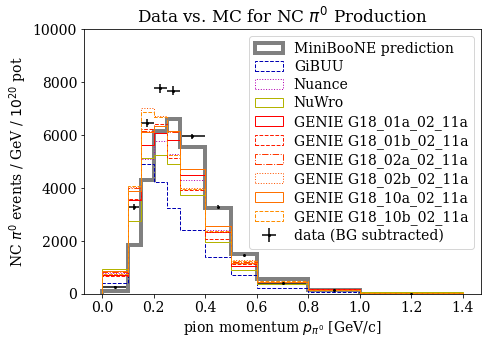

In [88]:
# Plot
plt.figure(figsize=(7,5))
plt.errorbar(p_bin_centers/u.GeV, (mb_pi0_data - mb_pi0_bg)*u.GeV,
             xerr=0.5*p_bin_widths/u.GeV, yerr=mb_pi0_errors*u.GeV,
             fmt='o', ms=2, c='k', label="data (BG subtracted)")
plt.hist(p_bin_centers/u.GeV, bins=p_bin_edges/u.GeV, weights=(mb_pi0_MC - mb_pi0_bg)*u.GeV,
         label='MiniBooNE prediction', histtype='step', color=my_colors['MB_MC'], lw=4)
plt.hist(p_bin_centers/u.GeV, bins=p_bin_edges/u.GeV, weights=dNdp_pi0['gibuu']*u.GeV,
         label='GiBUU', histtype='step', color=my_colors['gibuu'], ls='--')
plt.hist(p_bin_centers/u.GeV, bins=p_bin_edges/u.GeV, weights=dNdp_pi0['nuance']*u.GeV,
         label='Nuance', histtype='step', color=my_colors['nuance'], ls=':')
plt.hist(p_bin_centers/u.GeV, bins=p_bin_edges/u.GeV, weights=dNdp_pi0['nuwro']*u.GeV,
         label='NuWro', histtype='step', color=my_colors['nuwro'], ls='-')
for j, t in enumerate(genie_tunes):
    plt.hist(p_bin_centers/u.GeV, bins=p_bin_edges/u.GeV, weights=dNdp_pi0['genie-'+t]*u.GeV,
             label='GENIE '+genie_tunes[t], histtype='step',
             color=my_colors['genie-'+t], ls=ls_cycle[j%len(ls_cycle)])

#plt.yscale('log')
plt.xlabel(r'pion momentum $p_{\pi^0}$ [GeV/c]')
plt.ylabel(r'NC $\pi^0$ events / GeV / $10^{20}$ pot')
plt.ylim(0,10000)
plt.legend(loc='upper right', labelspacing=0.3)
plt.title('Data vs. MC for NC $\pi^0$ Production')
plt.tight_layout()
plt.savefig('pi0-spectrum.pdf')
plt.show()

### $\pi^0$ Background to the $\nu_e$ Appearance Search *(first-principles prediction)*

Evaluate "Read and process events" first!

In [8]:
def merge_photons(gamma_table, weight_table, cos_phi_cut, smearing=False, verbosity=0):
    """merge photon pairs with small opening angle
    
       Parameters:
           gamma_table:  a nested list of NuParticle objects containing the photons in each event
           weight_table: event weights
           cos_phi_cut:  'opt': choose cos_phi cut in each MiniBooNE bin of (mis-)reconstructed neutrino
                                energy such that the MiniBooNE prediction for the pi^0 background is reproduced
                         list:  a list of \cos\phi cut values, one entry for each MiniBooNE bin
           smearing:     apply MiniBooNE energy/momentum smearing before merging?
           verbosity:    if > 0, print additional debug output

       Return value:
           E_tot_table:    total event energy for those events containing exactly one photon after
                           merging; zero for those events which retain more than one photon
           Enu_reco_table: (mis-)reconstructed neutrino energies from single-photon events;
                           zero for non-single-photon events
           dNdE:           histogram
           cut_values:     the list of cut values for each MiniBooNE bin are returned, including overflow bins
                           at the start and at the end of the list;
                           if cos_phi_cut=='opt', this is the optimized list, otherwise it is just the input"""
    
    if len(gamma_table) <= 0:
        return np.array([]), np.array([]), np.zeros_like(mb_bin_centers_nue), np.zeros_like(mb_bin_centers_nue)

    # determine kinematics of pairs of photons
    if smearing:
        p4_gamma_table = [ smear_momentum(np.reshape(np.array([[p.px, p.py, p.pz, p.E] for p in particles]), (-1,4)), axis=1)
                                          for particles in gamma_table ]   # 4-momenta of all photons
    else:
        p4_gamma_table = [ np.reshape(np.array([[p.px, p.py, p.pz, p.E] for p in particles]), (-1,4))
                                          for particles in gamma_table ]   # 4-momenta of all photons
        
    p_gamma_table =                 [ p4_list[:,:3] for p4_list in p4_gamma_table ]
    E_tot_table   = np.array([ np.sum(p4_list[:,3]) for p4_list in p4_gamma_table ])
#     p_gamma_table = [ np.reshape(np.array([[p.px, p.py, p.pz] for p in particles]), (-1,3)) for particles in gamma_table ]
#     E_tot_table   = np.array([ np.sum([p.E for p in particles]) for particles in gamma_table ])
    n_gamma_table = np.array([len(X) for X in gamma_table])     # number of photons per event
    max_gammas    = max(n_gamma_table)                          # max. number of photons in a single event
    E_sum_table   = np.zeros((len(gamma_table), max(1,max_gammas*(max_gammas-1)))) # will hold energy sums of photon pairs
    cos_phi_table = np.full ((len(gamma_table), max(1,max_gammas*(max_gammas-1))), -2.) # will hold angle between photon pairs
    for n, p_list in enumerate(p_gamma_table):                  # loop over all events
        j = 0
        for i, k1 in enumerate(p_list):                         # loop over all photons in the event
            E1 = np.sqrt(np.dot(k1,k1))
            for k2 in p_list[i+1:]:
                E2 = np.sqrt(np.dot(k2,k2))
                E_sum_table[n,j]   = E1 + E2
                cos_phi_table[n,j] = np.dot(k1,k2) / (E1 * E2)
                j = j + 1
                
    # mis-reconstruct these events as CCQE
    E_B            = 34 * u.MeV                                 # nucleon binding energy in Ar-40
    T_l_table      = E_tot_table - u.m_e                        # would-be kinetic energy if these were electrons
    costh_table    = np.array([ np.sum(p_list[:,2]) for p_list in p_gamma_table ]) / E_tot_table
    Enu_reco_table = Enu_reco(T_l_table, u.m_e, u.m_n - E_B, u.m_p, costh_table) # mis-reconstructed neutrino energy
    
    # apply cos(phi) cut
    tmp_bin_edges     = np.array([-np.inf] + list(mb_bin_edges_nue) + [np.inf])       # add overflow bins to the list of bins
    Enu_bin_indices   = np.digitize(Enu_reco_table, bins=tmp_bin_edges) - 1           # the MB bin into which each event falls, note that NumPy starts counting bins at 1
    Enu_bin_indices[np.where(n_gamma_table==0)] = 0                                   # put events with no photons into overflow bin to ignore them
    cos_phi_max_table = np.where(n_gamma_table>1, np.amax(cos_phi_table, axis=1), 1.) # max. \cos\phi for photon pairs in each contributing event
                                                                                      # assign \cos\phi=1 to events with just a single photon
    if cos_phi_cut == 'opt':
        cos_phi_cut     = np.ones(len(tmp_bin_edges)-1)
        cos_phi_cut[0]  = np.inf # make sure events in overflow bins are rejected
        cos_phi_cut[-1] = np.inf
        
        # loop over all events (excluding those in overflow bins).
        # Determine which Enu_reco bin each event falls into.
        # then compare number of events in each bin to the MiniBooNE prediction.
        # Determine appropriate \cos\phi cut such that the two predictions match
        if verbosity > 0:
            print("optimizing phi cut:")
            print("  i_reco j_cut  cos(phi) cut            events")
            print("                               after cut       in MB")
        for i in range(1, len(mb_bin_centers_nue)+1):
            this_N_mb          = mb_bg_nue['pi0'][i-1]           # MB background prediction in current bin
            events_in_bin      = np.where(Enu_bin_indices==i)[0] # indices of events contributing to current bin
            if len(events_in_bin) == 0:
                cos_phi_cut[i] = 1.
            else:
                ii             = np.argsort(-cos_phi_max_table[events_in_bin]) # order events in current bin by decreasing \cos\phi
                j_cut          = np.argmin( np.abs(1 - np.cumsum(weight_table[events_in_bin][ii]) / this_N_mb) )
                cos_phi_cut[i] = cos_phi_max_table[events_in_bin][ii][j_cut]
                if verbosity > 0:
                    print("   {:5d} {:5d} {:12.7g} {:12.7g} {:12.7}".format(i, j_cut, cos_phi_cut[i], np.cumsum(weight_table[events_in_bin][ii])[j_cut], this_N_mb))
    
    # find events in which all photons are merged into a single photon
    triggers = (cos_phi_max_table >= cos_phi_cut[Enu_bin_indices])

    # sort events into MiniBooNE bins
    dNdE     = np.histogram(Enu_reco_table[triggers], bins=mb_bin_edges_nue,
                            weights=weight_table[triggers])[0] / mb_bin_widths_nue
       
    return np.where(triggers, E_tot_table, 0.), \
           np.where(triggers, Enu_reco_table,  0.), \
           dNdE, \
           cos_phi_cut

#     # find events in which all photons are merged into a single photon
#     merge_triggers_2d = (cos_phi_table >= cos_phi_cut(E_sum_table))  # true for merged photon pairs, false otherwise
#     merge_triggers_1d = ((n_gamma_table>0) & np.all(merge_triggers_2d, axis=1)) # true for events in which all photons are merged
#     E_eff_table       = np.where(merge_triggers_1d, E_tot_table, 0.) # total visible energy (woul-be electron energy) for single-gamma events, zero otherwise
    
#     # mis-reconstruct these events as CCQE
#     E_l_table         = E_tot_table[merge_triggers_1d]               # total visible energy (woul-be electron energy) for single-gamma events, zero otherwise
#     T_l_table         = E_l_table - u.m_e                            # would-be kinetic energy if these were electrons
#     costh_table       = np.array([ np.sum(p_list[:,2]) for p_list in p_gamma_table ])[merge_triggers_1d] / E_l_table
#     E_nu_table        = np.zeros(E_tot_table.shape)
#     E_nu_table[merge_triggers_1d] = Enu_reco(T_l_table, u.m_e, u.m_n, u.m_p, costh_table)  # mis-reconstructed neutrino energy
    
#     # sort fake neutrino events into MiniBooNE bins
#     dNdE = np.histogram(E_nu_table[merge_triggers_1d], bins=mb_bin_edges_nue,
#                         weights=weight_table[merge_triggers_1d])[0] / mb_bin_widths_nue
#    
#     return E_eff_table, E_nu_table, dNdE

# determine optimal cos(phi) cut by matching NUANCE prediction onto MB official prediction
# k = ('nuance','all','all')
# opt_E_table         = np.linspace(0.1, 1.0, 10) * u.GeV
# opt_costh_cut_table = np.full(opt_E_table.shape, 0.99)
# def chi2_costh_cut_opt(x):
#     costh_interp = interp.interp1d(opt_E_table, x, bounds_error=False, fill_value="extrapolate")
#     E_l_table, Enu_reco_table, dNdE = merge_photons(gamma_table[k], weights_pi0_2[k], costh_interp)
#     dNdE_mc = dNdE * mb_bin_widths_nue
#     print(x, np.sum(np.where(dNdE > 0., (dNdE * mb_bin_widths_nue - mb_bg_nue['pi0'])**2 / (dNdE * mb_bin_widths_nue), 0.)))
#     return np.sum(np.where(dNdE > 0., (dNdE * mb_bin_widths_nue - mb_bg_nue['pi0'])**2 / (dNdE * mb_bin_widths_nue), 0.))
# opt.minimize(chi2_costh_cut_opt, opt_costh_cut_table, method='Powell',
#              bounds=[(0,1)] * len(opt_E_table),
#              options={'direc' : -0.1*np.identity(len(opt_E_table))})

<ipython-input-89-aa311a2d2c74>:55: RuntimeWarning: invalid value encountered in true_divide
  costh_table    = np.array([ np.sum(p_list[:,2]) for p_list in p_gamma_table ]) / E_tot_table
<ipython-input-89-aa311a2d2c74>:84: RuntimeWarning: divide by zero encountered in true_divide
  j_cut          = np.argmin( np.abs(1 - np.cumsum(weight_table[events_in_bin][ii]) / this_N_mb) )
<ipython-input-89-aa311a2d2c74>:84: RuntimeWarning: invalid value encountered in true_divide
  j_cut          = np.argmin( np.abs(1 - np.cumsum(weight_table[events_in_bin][ii]) / this_N_mb) )


optimizing phi cut:
  i_reco j_cut  cos(phi) cut            events
                               after cut       in MB
       1  2730    0.4788507       213.74      213.771
       2  1164    0.7066754       90.207     90.24225
       3   975    0.8048224     70.61686       70.648
       4   402    0.8596111     27.47663     27.48225
       5   639    0.8878421     40.10755     40.09125
       6   373    0.9237448     21.30943      21.2825
       7   493    0.9388911     25.53692      25.5495
       8   455    0.9506146     21.62257      21.6315
       9   287    0.9625701     12.80763       12.789
      10   300    0.9721117     11.49236       11.485
      11     0    0.9999679            0          0.0


<ipython-input-89-aa311a2d2c74>:55: RuntimeWarning: invalid value encountered in true_divide
  costh_table    = np.array([ np.sum(p_list[:,2]) for p_list in p_gamma_table ]) / E_tot_table
<ipython-input-89-aa311a2d2c74>:64: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if cos_phi_cut == 'opt':


('gibuu', 'e', 'c12', 'nc'): 653 fake nu_e
('gibuu', 'mu', 'c12', 'nc'): 2644 fake nu_e
('gibuu', 'eb', 'c12', 'nc'): 582 fake nu_e
('gibuu', 'mub', 'c12', 'nc'): 207 fake nu_e
('gibuu', 'e', 'h', 'nc'): 65 fake nu_e
('gibuu', 'mu', 'h', 'nc'): 83 fake nu_e
('gibuu', 'eb', 'h', 'nc'): 84 fake nu_e
('gibuu', 'mub', 'h', 'nc'): 38 fake nu_e
('gibuu', 'e', 'c12', 'cc'): 294 fake nu_e
('gibuu', 'eb', 'c12', 'cc'): 445 fake nu_e
('gibuu', 'e', 'h', 'cc'): 2 fake nu_e
('gibuu', 'eb', 'h', 'cc'): 129 fake nu_e
('nuance', 'all', 'all'): 7829 fake nu_e
('nuwro', 'e', 'c12'): 1601 fake nu_e
('nuwro', 'mu', 'c12'): 1619 fake nu_e
('nuwro', 'eb', 'c12'): 1607 fake nu_e
('nuwro', 'mub', 'c12'): 841 fake nu_e
('nuwro', 'e', 'h'): 2948 fake nu_e
('nuwro', 'mu', 'h'): 3121 fake nu_e
('nuwro', 'eb', 'h'): 3217 fake nu_e
('nuwro', 'mub', 'h'): 3073 fake nu_e
('genie-00', 'e', 'c12'): 2529 fake nu_e
('genie-00', 'mu', 'c12'): 1403 fake nu_e
('genie-00', 'eb', 'c12'): 4475 fake nu_e
('genie-00', 'mub', 'c

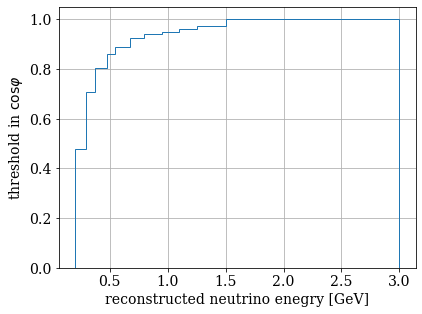

In [90]:
# determine optimal cos(phi) cut by matching NUANCE prediction onto MB official prediction
k = ('nuance','all','all')
dummy_E_l_table, dummy_Enu_reco_table, dummy_dNdE, opt_cos_phi_cut \
    = merge_photons(gamma_table[k], weights_pi0_2[k], 'opt', verbosity=1)

# plot cos(phi) thresholds
plt.hist(mb_bin_centers_nue/u.GeV, bins=mb_bin_edges_nue/u.GeV, weights=opt_cos_phi_cut[1:-1], histtype='step')
plt.xlabel(r'reconstructed neutrino enegry [GeV]')
plt.ylabel(r'threshold in $\cos\varphi$')
plt.grid()

# output them to a file
np.savetxt('mb-data/eff/photon_cos_phi_cut.dat', opt_cos_phi_cut, fmt="%10.5g",
           header="cut on opening angle phi between photons in MiniBooNE\n"
                 +"determined by comparing NUANCE simulation to data.\n"
                 +"The binning is in E_nu_reco [MeV], using the same bins as\n"
                 +"MiniBooNE's nu_e search, plus two overflow bins"
                 +"\n"
                 +"  cos(phi)")

# now merge photons in all event samples based on the cos(phi) cut we just determined
E_l_table      = {}               # (fake) lepton energies
Enu_reco_table = {}               # (incorrectly) reconstructed neutrino energies in each event
weights_pi0_3  = {}               # weights of the fake nue events
dNdE           = {}               # MiniBooNE binned event rates
for k in event_files.keys():
    # merge photon pairs, get total visible energy for each single-photon-like event
    E_l_table[k], Enu_reco_table[k], dNdE[k], cos_phi_cut = merge_photons(gamma_table[k], weights_pi0_2[k], opt_cos_phi_cut)
    weights_pi0_3[k] = np.where(E_l_table[k] > 0., weights_pi0_2[k], 0.)
    print('{}: {} fake nu_e'.format(k, len(np.where(E_l_table[k]>0.)[0])))

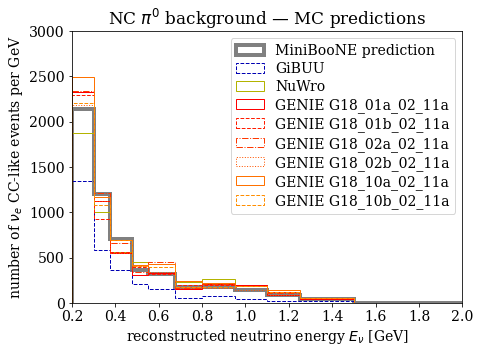

In [91]:
dNdE_mc = {}
mc_generators = set([k[0] for k in event_files.keys()])
for k in mc_generators:
    dNdE_mc[k] = np.histogram(np.concatenate([Enu_reco_table[kk] for kk in event_files.keys() if kk[0]==k]), bins=mb_bin_edges_nue,
                              weights = np.concatenate([weights_pi0_3[kk] for kk in event_files.keys() if kk[0]==k]))[0] / mb_bin_widths_nue

plt.figure(figsize=(7,5))
plt.subplot(111)
#plt.hist(mb_bin_centers_nue/u.GeV, bins=mb_bin_edges_nue/u.GeV, weights=mb_bg_nue_total/mb_bin_widths_nue*u.GeV,
#         label='MiniBooNE BG prediction', histtype='stepfilled', color=(1,.7,.7), ls='-')
plt.hist(mb_bin_centers_nue/u.GeV, bins=mb_bin_edges_nue/u.GeV, weights=mb_bg_nue['pi0']/mb_bin_widths_nue*u.GeV,
         label='MiniBooNE prediction', histtype='step', color=my_colors['MB_MC'], ls='-', lw=4)
plt.hist(mb_bin_centers_nue/u.GeV, bins=mb_bin_edges_nue/u.GeV, weights=dNdE_mc['gibuu']*u.GeV,
         label='GiBUU', histtype='step', color=my_colors['gibuu'], ls='--')
#plt.hist(mb_bin_centers_nue/u.GeV, bins=mb_bin_edges_nue/u.GeV, weights=dNdE_mc['nuance']*u.GeV,
#         label='Nuance', histtype='step', color=my_colors['nuance'], ls=':')
plt.hist(mb_bin_centers_nue/u.GeV, bins=mb_bin_edges_nue/u.GeV, weights=dNdE_mc['nuwro']*u.GeV,
         label='NuWro', histtype='step', color=my_colors['nuwro'], ls='-')
for j, t in enumerate(genie_tunes):
    plt.hist(mb_bin_centers_nue/u.GeV, bins=mb_bin_edges_nue/u.GeV, weights=dNdE_mc['genie-'+t]*u.GeV,
             label='GENIE '+genie_tunes[t], histtype='step',
             color=my_colors['genie-'+t], ls=ls_cycle[j%len(ls_cycle)])
#plt.errorbar(mb_bin_centers_nue/u.GeV, mb_events_nue/mb_bin_widths_nue*u.GeV, xerr=0.5*mb_bin_widths_nue/u.GeV,
#             yerr=np.sqrt(mb_events_nue)/mb_bin_widths_nue*u.GeV, label='MiniBooNE data',
#             fmt='none', color='black', capsize=4)
plt.xlabel('reconstructed neutrino energy $E_\\nu$ [GeV]')
plt.ylabel('number of $\\nu_e$ CC-like events per GeV')
plt.legend(loc='upper right', labelspacing=0.3)
plt.title('NC $\\pi^0$ background — MC predictions')
plt.xlim(0.2,2)
plt.ylim(0,3000)
plt.savefig('pi0-first-principles.pdf', bbox_inches='tight')
plt.show()

# write histograms to file for global fitting code
bg_data = {}
for k in mc_generators:
    bg_data[k] = np.stack([mb_bin_centers_nue/u.MeV, dNdE_mc[k]*u.MeV], axis=1)
    s          = genie_tunes[k[6:]] if re.match('genie-.*', k) else k
    np.savetxt('mb-data/bg/pi0-' + s + '.dat', bg_data[k], fmt="%10.5g",
               header="MiniBooNE pi0 background (first-principles approach)\n"
                     +"calculated using generator " + s + "\n"
                     +"  E [MeV]  BG [events/MeV]")

### $\pi^0$ Background to the $\nu_e$ Appearance Search *(data-driven approach)*

Evaluate the sections above ("Read and Process Events", "Attempt to reproduce data on $\pi^0$ production", "$\pi^0$ BG to the $\nu_e$ search - first principles calculation") first!

In [92]:
# compute event-by-event correction factors for the signal region, based on the pi^0 control sample
p_bin_indices = {} # the index of the p_pi0 bin into which each misreconstructed pi^0 event falls
r             = {} # event-by-event correction factors
for k in event_files.keys():
    # determine the p_pi0 bin into which each misreconstructed pi^0 event falls
    # (then remove events outside the range covered by r_gamma_pi_bin_edges)
    p_bin_indices[k] = np.digitize(pi0_momenta[k], bins=p_bin_edges)
    ii               = ((weights_pi0_3[k] > 0) & (p_bin_indices[k] > 0) & (p_bin_indices[k] < len(p_bin_edges)))

    # compute reweighting factor for each single-photon event that accounts for ratio of
    # pi^0 prediction to pi^0 data in the relevant p_pi0 bin
    r[k]             = np.zeros(p_bin_indices[k].shape)
    r[k][ii]         = (mb_pi0_data / (dNdp_pi0[k[0]] + mb_pi0_bg))[p_bin_indices[k][ii] - 1]
                                              # remember that np.digitize starts countings bins at 1

# apply correction factors to misreconstructed pi^0 events and compute resulting histogram in Enu_reco
# the ratio of this histogram to the one for NUANCE is the correction factor to be applied to
# MB's prediction for the single-photon background
w                 = {}    # corrected weights for each event
h                 = {}    # corrected histogram in Enu_reco
r_corr_pi0_binned = {}    # correction factor to be applied to MB's pi^0 background prediction
for k in mc_generators:
    Enu_reco_all = np.concatenate([Enu_reco_table[kk]        for kk in event_files.keys() if kk[0]==k])
    w[k]         = np.concatenate([weights_pi0_3[kk] * r[kk] for kk in event_files.keys() if kk[0]==k])
    h[k]         = np.histogram(Enu_reco_all, bins=mb_bin_edges_nue, weights=w[k])[0]
    
for k in mc_generators:
    r_corr_pi0_binned[k] = np.where(h['nuance']>0., h[k]/h['nuance'], 0.)
    bg_data[k] = np.stack([mb_bin_centers_nue/u.MeV, mb_bg_nue['pi0']/mb_bin_widths_nue * r_corr_pi0_binned[k] * u.MeV], axis=1)
    s = genie_tunes[k[6:]] if re.match('genie-.*', k) else k
    np.savetxt('mb-data/bg/pi0-' + s + '-dd.dat',   # suffix "dd" for "data-driven"
               bg_data[k], fmt="%10.5g",
               header="MiniBooNE pi0 background (data-driven approach)\n"
                     +"calculated using generator " + s + "\n"
                     +"  E [MeV]  BG [events/MeV]")

<ipython-input-92-3c94b7a47486>:28: RuntimeWarning: divide by zero encountered in true_divide
  r_corr_pi0_binned[k] = np.where(h['nuance']>0., h[k]/h['nuance'], 0.)
<ipython-input-92-3c94b7a47486>:28: RuntimeWarning: invalid value encountered in true_divide
  r_corr_pi0_binned[k] = np.where(h['nuance']>0., h[k]/h['nuance'], 0.)


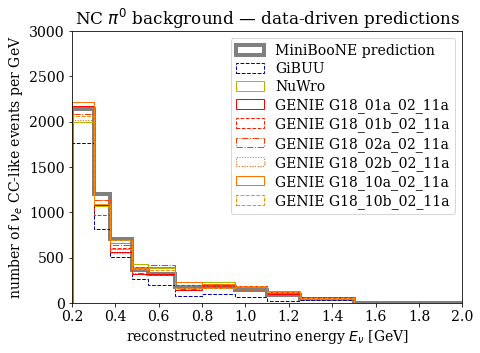

In [93]:
plt.figure(figsize=(7,5))
plt.subplot(111)
#plt.hist(mb_bin_centers_nue/u.GeV, bins=mb_bin_edges_nue/u.GeV, weights=mb_bg_nue_total/mb_bin_widths_nue*u.GeV,
#         label='MiniBooNE BG prediction', histtype='stepfilled', color=(1,.7,.7), ls='-')
plt.hist(mb_bin_centers_nue/u.GeV, bins=mb_bin_edges_nue/u.GeV,
         weights=mb_bg_nue['pi0']/mb_bin_widths_nue*u.GeV,
         label='MiniBooNE prediction', histtype='step', color=my_colors['MB_MC'], lw=4, ls='-')
plt.hist(mb_bin_centers_nue/u.GeV, bins=mb_bin_edges_nue/u.GeV,
         weights=mb_bg_nue['pi0']/mb_bin_widths_nue * r_corr_pi0_binned['gibuu']*u.GeV,
         label='GiBUU', histtype='step', color=my_colors['gibuu'], ls='--')
#plt.hist(mb_bin_centers_nue/u.GeV, bins=mb_bin_edges_nue/u.GeV,
#         weights=mb_bg_nue['pi0']/mb_bin_widths_nue * r_corr_pi0_binned['nuance']*u.GeV,         
#         label='Nuance', histtype='step', color=my_colors['nuance'], ls=':')
plt.hist(mb_bin_centers_nue/u.GeV, bins=mb_bin_edges_nue/u.GeV,
         weights=mb_bg_nue['pi0']/mb_bin_widths_nue * r_corr_pi0_binned['nuwro']*u.GeV,         
         label='NuWro', histtype='step', color=my_colors['nuwro'], ls='-')
for j, t in enumerate(genie_tunes):
    plt.hist(mb_bin_centers_nue/u.GeV, bins=mb_bin_edges_nue/u.GeV,
             weights=mb_bg_nue['pi0']/mb_bin_widths_nue * r_corr_pi0_binned['genie-'+t]*u.GeV,         
             label='GENIE '+genie_tunes[t], histtype='step', color=my_colors['genie-'+t], ls=ls_cycle[j%len(ls_cycle)])
#plt.errorbar(mb_bin_centers_nue/u.GeV, mb_events_nue/mb_bin_widths_nue*u.GeV, xerr=0.5*mb_bin_widths_nue/u.GeV,
#             yerr=np.sqrt(mb_events_nue)/mb_bin_widths_nue*u.GeV, label='MiniBooNE data',
#             fmt='none', color='black', capsize=4)
plt.xlabel('reconstructed neutrino energy $E_\\nu$ [GeV]')
plt.ylabel('number of $\\nu_e$ CC-like events per GeV')
plt.legend(loc='upper right', labelspacing=0.3)
plt.title('NC $\\pi^0$ background — data-driven predictions')
plt.xlim(0.2,2)
plt.ylim(0,3000)
plt.savefig('pi0-data-driven.pdf', bbox_inches='tight')
plt.show()


## Single photons from coherent production, $\Delta(1232)$ decay, etc.

### Single Photon Background to the $\nu_e$ Appearance Search *(first principles calculation)*

Note: events are generated in the whole active volume, including the veto region out to $r = 610$ cm. This is appropriate here because the $e$/$\gamma$ efficiencies from https://www-boone.fnal.gov/for_physicists/data_release/nue_nuebar_2012/ are defined relative to this target volume. So no further fiducialization cut or rescaling is necessary here.

In [94]:
# additional filtering of events
def gamma_trigger(ev):
    n_gamma = len([ p for p in ev.particles if abs(p.id) == 22 ])
#    n_gamma = len([ p for p in ev.particles if abs(p.id) == 22 and p.E > 150*u.MeV ])
    return (n_gamma >= 1)

trigger_table_gamma   = {}               # which events can fake a \nu_e?
gamma_table           = {}               # list of photons in each event
weights_gamma         = {}               # weights of the fake nue events
for k in event_files.keys():
    # identify events containing photons (faking a \nu_e)
    trigger_table_gamma[k] = np.where([gamma_trigger(ev) for ev in events[k] ])[0]
    gamma_table[k]    = [ [ p for p in events[k][j].particles if p.id==22 ] for j in trigger_table_gamma[k] ]
    weights_gamma[k]  = weight_table[k][trigger_table_gamma[k]]

In [95]:
# merge photos according to the same cos(phi) cut as for the \pi^0 background
E_gamma_table   = {}               # (fake) lepton energies
Enu_reco_table  = {}               # (incorrectly) reconstructed neutrino energies in each event
dNdE            = {}               # MiniBooNE binned event rates
opt_cos_phi_cut = np.loadtxt('mb-data/eff/photon_cos_phi_cut.dat')
# p_gamma_table   = {}               # photon momentaum vector in each triggered event
# T_l_table       = {}               # (fake) lepton kinetic energies
# costh_table     = {}               # (fake) lepton angles relative to the beam direction
for k in event_files.keys():
    E_gamma_table[k], Enu_reco_table[k], dNdE[k], cos_phi_cut \
        = merge_photons(gamma_table[k], weights_gamma[k], opt_cos_phi_cut, smearing=True)
    
    print('{}: {} fake nu_e'.format(k, len(trigger_table_gamma[k])))

<ipython-input-89-aa311a2d2c74>:64: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if cos_phi_cut == 'opt':


('gibuu', 'e', 'c12', 'nc'): 941 fake nu_e
('gibuu', 'mu', 'c12', 'nc'): 5502 fake nu_e
('gibuu', 'eb', 'c12', 'nc'): 718 fake nu_e
('gibuu', 'mub', 'c12', 'nc'): 360 fake nu_e
('gibuu', 'e', 'h', 'nc'): 301 fake nu_e
('gibuu', 'mu', 'h', 'nc'): 334 fake nu_e
('gibuu', 'eb', 'h', 'nc'): 150 fake nu_e
('gibuu', 'mub', 'h', 'nc'): 94 fake nu_e
('gibuu', 'e', 'c12', 'cc'): 294 fake nu_e
('gibuu', 'eb', 'c12', 'cc'): 368 fake nu_e
('gibuu', 'e', 'h', 'cc'): 0 fake nu_e
('gibuu', 'eb', 'h', 'cc'): 106 fake nu_e
('nuance', 'all', 'all'): 209759 fake nu_e
('nuwro', 'e', 'c12'): 1282 fake nu_e
('nuwro', 'mu', 'c12'): 1231 fake nu_e
('nuwro', 'eb', 'c12'): 1216 fake nu_e
('nuwro', 'mub', 'c12'): 1255 fake nu_e
('nuwro', 'e', 'h'): 1472 fake nu_e
('nuwro', 'mu', 'h'): 1449 fake nu_e
('nuwro', 'eb', 'h'): 1502 fake nu_e
('nuwro', 'mub', 'h'): 1453 fake nu_e
('genie-00', 'e', 'c12'): 3166 fake nu_e
('genie-00', 'mu', 'c12'): 901 fake nu_e
('genie-00', 'eb', 'c12'): 3187 fake nu_e
('genie-00', 'mub

Generating plot for comparison of generators ...


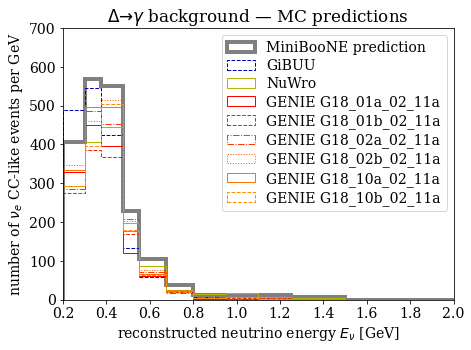

In [103]:
# use Nuance histogram to determine MiniBooNE efficiencies
if mode == "generator-comparison":
    dNdE_mc = {}
    with np.errstate(divide='ignore', invalid='ignore'):
        for k in ['nuance']:
            dNdE_mc[k] = np.histogram(np.concatenate([Enu_reco_table[kk] for kk in event_files.keys() if kk[0]==k]), bins=mb_bin_edges_nue,
                                      weights = np.concatenate([weights_gamma[kk] for kk in event_files.keys() if kk[0]==k]))[0] / mb_bin_widths_nue
        mb_eff          = np.where(dNdE_mc['nuance']>0., (mb_bg_nue['Delta']/mb_bin_widths_nue) / dNdE_mc['nuance'], 0.)
        mb_eff_data     = np.concatenate([np.array([[0.,0.]]),
                                          np.array([mb_bin_centers_nue,
                                                    np.where(dNdE_mc['nuance']>0., (mb_bg_nue['Delta']/mb_bin_widths_nue) / dNdE_mc['nuance'], 0.)]).T])
        np.savetxt('mb-data/eff/mb-eff.dat', np.stack([mb_eff_data[:,0]/u.GeV, mb_eff_data[:,1]], axis=1), fmt="%10.5g",
                   header="MiniBooNE efficiencies computed by comparing \n"
                         +"simulated and measured single photon backgrounds.\n"
                         +"   E [GeV] efficiency")
else:
    mb_eff_data = np.loadtxt('mb-data/eff/mb-eff.dat') * np.array([u.GeV, 1])
    
# generate MC histograms
dNdE_mc = {}
mc_generators = set([k[0] for k in event_files.keys()])
for k in mc_generators:
    # use electron/gamma efficiencies
#    dNdE_mc[k] = np.histogram(np.concatenate([Enu_reco_table[kk] for kk in event_files.keys() if kk[0]==k]), bins=mb_bin_edges_nue,
#                              weights = np.concatenate([weights_gamma[kk]*mb_eg_eff_interpol(E_gamma_table[kk])
#                                                        for kk in event_files.keys() if kk[0]==k]))[0] / mb_bin_widths_nue

    # normalize to NUANCE
    dNdE_mc[k] = np.histogram(np.concatenate([Enu_reco_table[kk] for kk in event_files.keys() if kk[0]==k]), bins=mb_bin_edges_nue,
                              weights = np.concatenate([weights_gamma[kk] for kk in event_files.keys() if kk[0]==k]))[0] \
                                      * mb_eff / mb_bin_widths_nue

c_cycler  = itertools.cycle([ plt.cm.get_cmap('gist_earth')(x) for x in np.linspace(0.0,1.0,20) ])

# plot for comparison of generators
# ---------------------------------
if mode == "generator-comparison":
    print("Generating plot for comparison of generators ...")
    plt.figure(figsize=(7,5))
    plt.subplot(111)
    #plt.hist(mb_bin_centers_nue/u.GeV, bins=mb_bin_edges_nue/u.GeV, weights=mb_bg_nue_total/mb_bin_widths_nue*u.GeV,
    #         label='MiniBooNE BG prediction', histtype='stepfilled', color=(1,.7,.7), ls='-')
    plt.hist(mb_bin_centers_nue/u.GeV, bins=mb_bin_edges_nue/u.GeV, weights=mb_bg_nue['Delta']/mb_bin_widths_nue*u.GeV,
             label='MiniBooNE prediction', histtype='step', color=my_colors['MB_MC'], lw=4, ls='-')
    plt.hist(mb_bin_centers_nue/u.GeV, bins=mb_bin_edges_nue/u.GeV, weights=dNdE_mc['gibuu']*u.GeV,
             label='GiBUU', histtype='step', color=my_colors['gibuu'], ls='--')
#    plt.hist(mb_bin_centers_nue/u.GeV, bins=mb_bin_edges_nue/u.GeV, weights=dNdE_mc['nuance']*u.GeV,
#             label='Nuance', histtype='step', color=my_colors['nuance'], ls=':')
    plt.hist(mb_bin_centers_nue/u.GeV, bins=mb_bin_edges_nue/u.GeV, weights=dNdE_mc['nuwro']*u.GeV,
             label='NuWro', histtype='step', color=my_colors['nuwro'], ls='-')
    for j, t in enumerate(genie_tunes):
        plt.hist(mb_bin_centers_nue/u.GeV, bins=mb_bin_edges_nue/u.GeV, weights=dNdE_mc['genie-'+t]*u.GeV,
                 label='GENIE '+genie_tunes[t], histtype='step',
                 color=my_colors['genie-'+t], ls=ls_cycle[j%len(ls_cycle)])
#    plt.errorbar(mb_bin_centers_nue/u.GeV, mb_events_nue/mb_bin_widths_nue*u.GeV, xerr=0.5*mb_bin_widths_nue/u.GeV,
#                 yerr=np.sqrt(mb_events_nue)/mb_bin_widths_nue*u.GeV, label='MiniBooNE data',
#                 fmt='none', color='black', capsize=4)
    plt.xlabel('reconstructed neutrino energy $E_\\nu$ [GeV]')
    plt.ylabel('number of $\\nu_e$ CC-like events per GeV')
    plt.legend(loc='upper right', labelspacing=0.3)
    plt.title('$\\Delta \\to \\gamma$ background — MC predictions')
    plt.xlim(0.2,2)
    plt.ylim(0,700)
    plt.savefig('single-gamma-first-principles.pdf', bbox_inches='tight')
    plt.show()

    # write histograms to file for global fitting code
    bg_data = {}
    for k in mc_generators:
        bg_data[k] = np.stack([mb_bin_centers_nue/u.MeV, dNdE_mc[k]*u.MeV], axis=1)
        s          = genie_tunes[k[6:]] if re.match('genie-.*', k) else k
        np.savetxt('mb-data/bg/singlephoton-' + s + '.dat', bg_data[k], fmt="%10.5g",
                   header="MiniBooNE coherent photon (\Delta -> \gamma) background\n"
                         +"calculated using generator " + s + "\n"
                         +"  E [MeV]  BG [events/MeV]")


# plot for full n-dimensional parameter scan
# ------------------------------------------
elif mode == "param-scan-full":
    print("Generating plot for n-dim parameter scan ...")
    dNdE_mc_min = np.amin(np.stack([dNdE_mc[k] for k in mc_generators if re.match(k[0],'gibuu-[0-9]+')], axis=1), axis=1)
    dNdE_mc_max = np.amax(np.stack([dNdE_mc[k] for k in mc_generators if re.match(k[0],'gibuu-[0-9]+')], axis=1), axis=1)
    
    plt.figure(figsize=(7,5))
    plt.subplot(111)
#    for k in mc_generators:
#        plt.hist(mb_bin_centers_nue/u.GeV, bins=mb_bin_edges_nue/u.GeV, weights=dNdE_mc[k]*u.GeV,
#                 histtype='step', color=next(c_cycler), ls=ls_cycle[k%len(ls_cycle)])
    plt.hist(mb_bin_centers_nue/u.GeV, bins=mb_bin_edges_nue/u.GeV, weights=mb_bg_nue['Delta']/mb_bin_widths_nue*u.GeV,
             label='MiniBooNE prediction', histtype='step', color=my_colors['MB_MC'], lw=4, ls='-')
    plt.hist(mb_bin_centers_nue/u.GeV, bins=mb_bin_edges_nue/u.GeV, weights=dNdE_mc['gibuu']*u.GeV,
             histtype='step', edgecolor=my_colors['gibuu'], ls='-', lw=2,
             label=u'GiBUU nominal')
    plt.hist(mb_bin_centers_nue/u.GeV, bins=mb_bin_edges_nue/u.GeV, weights=dNdE_mc_max*u.GeV,
             histtype='stepfilled', color='white', edgecolor=my_colors['gibuu'], hatch='///', ls='-',
             label=u'GiBUU (BR $\u00B1 2 \\sigma$)')
    plt.hist(mb_bin_centers_nue/u.GeV, bins=mb_bin_edges_nue/u.GeV, weights=dNdE_mc_min*u.GeV,
             histtype='stepfilled', color='white', edgecolor=my_colors['gibuu'], ls='-')
    plt.hist(mb_bin_centers_nue/u.GeV, bins=mb_bin_edges_nue/u.GeV, weights=dNdE_mc['nuance']*u.GeV,
             label='Nuance prediction', histtype='step', color=my_colors['nuance'], ls='--', lw=3)
#    plt.errorbar(mb_bin_centers_nue/u.GeV, mb_events_nue/mb_bin_widths_nue*u.GeV, xerr=0.5*mb_bin_widths_nue/u.GeV,
#                 yerr=np.sqrt(mb_events_nue)/mb_bin_widths_nue*u.GeV, label='MiniBooNE data',
#                 fmt='none', color='black', capsize=4)
    plt.xlabel('reconstructed neutrino energy $E_\\nu$ [GeV]')
    plt.ylabel('number of $\\nu_e$ CC-like events per GeV')
    plt.title('$\\Delta \\to \\gamma$ background — with BR uncertainties')
    
    handles, labels = plt.gca().get_legend_handles_labels()
    new_handles = [plt.Line2D([], [], c=h.get_edgecolor(), ls=h.get_linestyle()) if re.match(l, 'Nuance.*') else h
                      for h, l in zip(handles, labels)]
    plt.legend(handles=new_handles, labels=labels, loc='upper right', labelspacing=0.3)
    
    plt.xlim(0,2.)
    plt.ylim(0,1000)
    plt.savefig('single-gamma-scanNd.pdf', bbox_inches='tight')
    plt.show()

    # write histograms to file for global fitting code
    bg_data_min = np.stack([mb_bin_centers_nue/u.MeV, dNdE_mc_min*u.MeV], axis=1)
    np.savetxt('mb-data/bg/singlephoton-gibuu-brscan-min.dat', bg_data_min, fmt="%10.5g",
               header="MiniBooNE coherent photon (\Delta -> \gamma) background\n"
                     +"calculated using GiBUU with lowest radiative BRs\n"
                     +"  E [MeV]  BG [events/MeV]")
    bg_data_max = np.stack([mb_bin_centers_nue/u.MeV, dNdE_mc_max*u.MeV], axis=1)
    np.savetxt('mb-data/bg/singlephoton-gibuu-brscan-max.dat', bg_data_max, fmt="%10.5g",
               header="MiniBooNE coherent photon (\Delta -> \gamma) background\n"
                     +"calculated using GiBUU with highest radiative BRs\n"
                     +"  E [MeV]  BG [events/MeV]")
    
# plot for a set of 1-dimensional parameter scans
# -----------------------------------------------
elif mode == "param-scan-1d":
    print("Generating plot for set of 1d parameter scans ...")
    decay_errors = np.loadtxt(base_dir + 'sim/gibuu/br-scan/DecayChannels-errors.dat', usecols=range(10,19), dtype='float')
    np_indices   = decay_errors.nonzero()   # indices of nuisance parameters in decay_errors array
    n_np         = len(np_indices)          # number of nuisance parameters
    n_np_steps   = 5                        # number of steps for each nuisance parameter
    
    # For each bin, fit the dependence of the rate on each nuisance parameter
    np_fit_coeff = [ [] for i in range(len(mb_bin_centers_nue)) ]
    for i in range(len(mb_bin_centers_nue)):
        for j in range(n_np):
            k_list = [ 'gibuu-{:02d}'.format(n_np_steps*j + l) for l in range(n_np_steps) ]
            np_fit_coeff[i].append(np.polyfit(np.linspace(-2,2,n_np_steps), [dNdE_mc[k][i] for k in k_list], deg=2))
            
    # Now, in each bin determine the range of values reachable at a given C.L. alpha
    dNdE_mc_min = np.full((len(mb_bin_centers_nue)), 0.)
    dNdE_mc_max = np.full((len(mb_bin_centers_nue)), 0.)
    alpha       = 0.95
    sigma       = opt.brentq(lambda x: sf.erf(x/np.sqrt(2)) - alpha, 0, 10.)   # number of sigma's corresponding to alpha
    for i in range(len(mb_bin_centers_nue)):
        dNdE_mc_min[i] = np.amin([ np.polyval(np_fit_coeff[i][j], [sigma, -sigma]) for j in range(n_np) ])
        dNdE_mc_max[i] = np.amax([ np.polyval(np_fit_coeff[i][j], [sigma, -sigma]) for j in range(n_np) ])
    
#    dNdE_mc_min = np.amin(np.stack([dNdE_mc[k] for k in mc_generators if re.match(k[0],'gibuu.*')], axis=1), axis=1)
#    dNdE_mc_max = np.amax(np.stack([dNdE_mc[k] for k in mc_generators if re.match(k[0],'gibuu.*')], axis=1), axis=1)

    plt.figure(figsize=(7,5))
    plt.subplot(111)
#    for k in mc_generators:
#        plt.hist(mb_bin_centers_nue/u.GeV, bins=mb_bin_edges_nue/u.GeV, weights=dNdE_mc[k]*u.GeV,
#                 histtype='step', color=next(c_cycler), ls=next(ls_cycler))
    plt.hist(mb_bin_centers_nue/u.GeV, bins=mb_bin_edges_nue/u.GeV, weights=dNdE_mc_max*u.GeV,
             histtype='stepfilled', color='white', edgecolor='black', hatch='///', ls=next(ls_cycler),
             label=u'GiBUU (BR $\u00B1 2 \\sigma$)')
    plt.hist(mb_bin_centers_nue/u.GeV, bins=mb_bin_edges_nue/u.GeV, weights=dNdE_mc_min*u.GeV,
             histtype='stepfilled', color='white', edgecolor='black', ls='-')
    plt.hist(mb_bin_centers_nue/u.GeV, bins=mb_bin_edges_nue/u.GeV, weights=mb_bg_nue['Delta']/mb_bin_widths_nue*u.GeV,
             label='MiniBooNE prediction', histtype='stepfilled', color=(1,.7,.7), edgecolor=(.7,0,0), ls='-')
    plt.hist(mb_bin_centers_nue/u.GeV, bins=mb_bin_edges_nue/u.GeV, weights=dNdE_mc['nuance']*u.GeV,
             label='Nuance prediction', histtype='step', color='blue', ls='--', lw=3)
    plt.errorbar(mb_bin_centers_nue/u.GeV, mb_events_nue/mb_bin_widths_nue*u.GeV, xerr=0.5*mb_bin_widths_nue/u.GeV,
                 yerr=np.sqrt(mb_events_nue)/mb_bin_widths_nue*u.GeV, label='MiniBooNE data',
                 fmt='none', color='black', capsize=4)
    plt.xlabel('reconstructed neutrino energy $E_\\nu$ [GeV]')
    plt.ylabel('number of $\\nu_e$ CC-like events per GeV')
    plt.title('$\\Delta \\to \\gamma$ background — with BR uncertainties')
    
    handles, labels = plt.gca().get_legend_handles_labels()
    new_handles = [plt.Line2D([], [], c=h.get_edgecolor(), ls=h.get_linestyle()) if re.match(l, 'Nuance.*') else h
                      for h, l in zip(handles, labels)]
    plt.legend(handles=new_handles, labels=labels, loc='upper right', labelspacing=0.3)
    plt.xlim(0,2.)
    plt.ylim(0,700)
    plt.savefig('single-gamma-scan1d.pdf', bbox_inches='tight')
    plt.show()

### Single Photon Background to the $\nu_e$ Appearance Search *(data-driven approach)*

Evaluate "Photons from $\pi^0$'s" section, as well as previous section (first principles calculation) first!

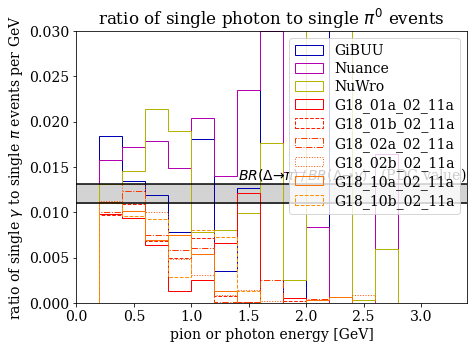

In [97]:
c_cycler       = itertools.cycle([ plt.cm.get_cmap('gist_earth')(x) for x in np.linspace(0.0,1.0,20) ])

br_pi          = 0.5 * 0.994 # Delta branching fraction to neutral pions [PDG 2019]
br_gamma_lower = 0.0055 # Delta branching fraction to photons (lower bound) [PDG 2019]
br_gamma_upper = 0.0065 # Delta branching fraction to photons (upper bound) [PDG 2019]

# bin events according to the pion or photon energy
dNdE_gamma_noeff       = {}
dNdE_pi_noeff          = {}
r_gamma_pi_noeff       = {}  # ratio of single-photon to single-pion events (without efficiency factors), binned in photon or pion energy
E_gamma_pi_bin_edges   = np.linspace(0.2, 3.4, 17) * u.GeV # Vedran's binning
#E_gamma_pi_bin_edges   = np.concatenate(( np.linspace(0.1, 1., 5, endpoint=False), # Joachim's binning
#                                          np.linspace(1., 2.,  2, endpoint=False),
#                                          np.linspace(2., 4.,  2, endpoint=True) )) * u.GeV
E_gamma_pi_bin_centers = 0.5 * (E_gamma_pi_bin_edges[1:] + E_gamma_pi_bin_edges[:-1])
E_gamma_pi_bin_widths  = np.diff(E_gamma_pi_bin_edges)
mc_generators          = set([k[0] for k in event_files.keys()])
for k in mc_generators:
    dNdE_gamma_noeff[k] = np.histogram(np.concatenate([E_gamma_table[kk] for kk in event_files.keys() if kk[0]==k]), bins=E_gamma_pi_bin_edges,
                                 weights=np.concatenate([weights_gamma[kk] for kk in event_files.keys() if kk[0]==k]))[0] / E_gamma_pi_bin_widths
#    dNdE_pi_noeff[k]    = np.histogram(np.concatenate([E_pi_table[kk] for kk in event_files.keys() if kk[0]==k]), bins=E_gamma_pi_bin_edges,
#                                 weights=np.concatenate([weights_table_pi[kk] for kk in event_files.keys() if kk[0]==k]))[0] / E_gamma_pi_bin_widths
    dNdE_pi_noeff[k]    = np.histogram(np.concatenate([pi0_energies[kk] for kk in event_files.keys() if kk[0]==k]), bins=E_gamma_pi_bin_edges,
                                 weights=np.concatenate([weights_pi0[kk] for kk in event_files.keys() if kk[0]==k]))[0] / E_gamma_pi_bin_widths
    with np.errstate(divide='ignore', invalid='ignore'):
        r_gamma_pi_noeff[k] = np.where(dNdE_pi_noeff[k] > 0., dNdE_gamma_noeff[k] / dNdE_pi_noeff[k], 0.)

# plot ratio of single photon to single pion rate
plt.figure(figsize=(7,5))
plt.subplot(111)
plt.hist(E_gamma_pi_bin_centers/u.GeV, bins=E_gamma_pi_bin_edges/u.GeV, weights=r_gamma_pi_noeff['gibuu'],
         label='GiBUU', histtype='step', color=my_colors['gibuu'], ls='-')
plt.hist(E_gamma_pi_bin_centers/u.GeV, bins=E_gamma_pi_bin_edges/u.GeV, weights=r_gamma_pi_noeff['nuance'],
         label='Nuance', histtype='step', color=my_colors['nuance'], ls='-')
plt.hist(E_gamma_pi_bin_centers/u.GeV, bins=E_gamma_pi_bin_edges/u.GeV, weights=r_gamma_pi_noeff['nuwro'],
         label='NuWro', histtype='step', color=my_colors['nuwro'], ls='-')
for j, t in enumerate(genie_tunes):
    plt.hist(E_gamma_pi_bin_centers/u.GeV, bins=E_gamma_pi_bin_edges/u.GeV, weights=r_gamma_pi_noeff['genie-'+t],
             label=genie_tunes[t], histtype='step',
             color=my_colors['genie-'+t], ls=ls_cycle[j%len(ls_cycle)])
plt.fill_between([-10,10], br_gamma_lower/br_pi, br_gamma_upper/br_pi, color='lightgray')
plt.axhline(br_gamma_lower/br_pi, color='black')
plt.axhline(br_gamma_upper/br_pi, color='black')
plt.xlim(0, max(E_gamma_pi_bin_edges)/u.GeV)
plt.ylim(0,0.03)
plt.xlabel('pion or photon energy [GeV]')
plt.ylabel('ratio of single $\\gamma$ to single $\\pi$ events per GeV')
plt.legend(loc='upper right', labelspacing=0.3)
plt.title('ratio of single photon to single $\pi^0$ events')
plt.annotate('$BR(\\Delta\\to\\pi) \\, / \\, BR(\\Delta\\to\\gamma)$   (PDG value)',
             (E_gamma_pi_bin_edges[-1]/u.GeV, br_gamma_upper/br_pi), va='bottom', ha='right')
plt.savefig('r-gamma-pi.pdf', bbox_inches='tight')
plt.show()

In [98]:
# compute event-by-event correction factors for the signal region, based on the pi^0 control sample
r             = {} # event-by-event correction factors
p_bin_indices = {} # the index of the p_gamma or p_pi bin into which each event falls
for k in event_files.keys():
    # determine the p_gamma bin into which each single-photon event falls
    # (then remove events outside the range covered by r_gamma_pi_bin_edges)
    p_bin_indices[k] = np.digitize(E_gamma_table[k], bins=p_bin_edges)
    ii               = ((weights_gamma[k] > 0) & (p_bin_indices[k] > 0) & (p_bin_indices[k] < len(p_bin_edges)))
            
    # compute reweighting factor for each single-photon event that accounts for ratio of
    # pi^0 prediction to pi^0 data in the relevant p_pi0 bin
    r[k]             = np.zeros(p_bin_indices[k].shape)
    r[k][ii]         = (mb_pi0_data / (dNdp_pi0[k[0]] + mb_pi0_bg))[p_bin_indices[k][ii] - 1]
                                              # remember that np.digitize starts countings bins at 1

# apply correction factors to single-photon events and compute resulting histogram in Enu_reco
# the ratio of this histogram to the one for NUANCE is the correction factor to be applied to
# MB's prediction for the single-photon background
w                   = {}    # corrected weights for each event
h                   = {}    # corrected histogram in Enu_reco
r_corr_gamma_binned = {}    # correction factor to be applied to MB's pi^0 background prediction
for k in mc_generators:
    Enu_reco_all = np.concatenate([Enu_reco_table[kk]        for kk in event_files.keys() if kk[0]==k])
    w[k]         = np.concatenate([weights_gamma[kk] * r[kk] for kk in event_files.keys() if kk[0]==k])
    h[k]         = np.histogram(Enu_reco_all, bins=mb_bin_edges_nue, weights=w[k])[0]
    
for k in mc_generators:
    r_corr_gamma_binned[k] = np.where(h['nuance']>0., h[k]/h['nuance'], 0.)
    bg_data[k] = np.stack([mb_bin_centers_nue/u.MeV, mb_bg_nue['Delta']/mb_bin_widths_nue*r_corr_gamma_binned[k]*u.MeV], axis=1)
    s          = genie_tunes[k[6:]] if re.match('genie-.*', k) else k
    np.savetxt('mb-data/bg/singlephoton-' + s + '-dd.dat',     # suffix "dd" for "data-driven"
               bg_data[k], fmt="%10.5g",
               header="MiniBooNE single photon background (data-driven approach)\n"
                     +"calculated using generator " + s + "\n"
                     +"  E [MeV]  BG [events/MeV]")
        

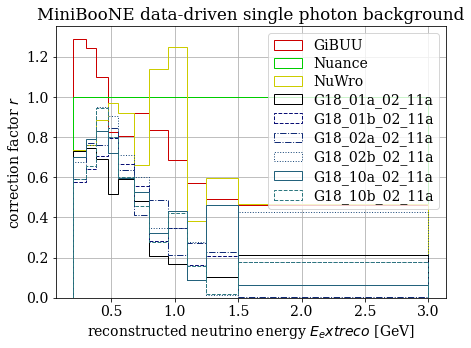

In [99]:
plt.figure(figsize=(7,5))
plt.hist(mb_bin_centers_nue/u.GeV, bins=mb_bin_edges_nue/u.GeV, weights=r_corr_gamma_binned['gibuu'],
         label='GiBUU', histtype='step', color=(.8,0,0), ls='-')
plt.hist(mb_bin_centers_nue/u.GeV, bins=mb_bin_edges_nue/u.GeV, weights=r_corr_gamma_binned['nuance'],
         label='Nuance', histtype='step', color=(0,.8,0), ls='-')
plt.hist(mb_bin_centers_nue/u.GeV, bins=mb_bin_edges_nue/u.GeV, weights=r_corr_gamma_binned['nuwro'],
         label='NuWro', histtype='step', color=(.8,.8,0), ls='-')
for j, t in enumerate(genie_tunes):
    plt.hist(mb_bin_centers_nue/u.GeV, bins=mb_bin_edges_nue/u.GeV, weights=r_corr_gamma_binned['genie-'+t],
             label=genie_tunes[t], histtype='step',
             color=next(c_cycler), ls=ls_cycle[j%len(ls_cycle)])
plt.xlabel('reconstructed neutrino energy $E_\text{reco}$ [GeV]')
plt.ylabel('correction factor $r$')
plt.legend(loc='upper right', labelspacing=0.3)
plt.title('MiniBooNE data-driven single photon background')
plt.grid()
plt.show()

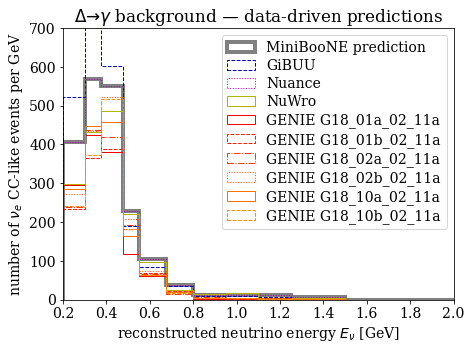

In [100]:
plt.figure(figsize=(7,5))
plt.subplot(111)
plt.hist(mb_bin_centers_nue/u.GeV, bins=mb_bin_edges_nue/u.GeV,
         weights=mb_bg_nue['Delta']/mb_bin_widths_nue*u.GeV,
         label='MiniBooNE prediction', histtype='step', color=my_colors['MB_MC'], lw=4, ls='-')
plt.hist(mb_bin_centers_nue/u.GeV, bins=mb_bin_edges_nue/u.GeV,
         weights=mb_bg_nue['Delta']/mb_bin_widths_nue * r_corr_gamma_binned['gibuu']*u.GeV,
         label='GiBUU', histtype='step', color=my_colors['gibuu'], ls='--')
plt.hist(mb_bin_centers_nue/u.GeV, bins=mb_bin_edges_nue/u.GeV,
         weights=mb_bg_nue['Delta']/mb_bin_widths_nue * r_corr_gamma_binned['nuance']*u.GeV,         
         label='Nuance', histtype='step', color=my_colors['nuance'], ls=':')
plt.hist(mb_bin_centers_nue/u.GeV, bins=mb_bin_edges_nue/u.GeV,
         weights=mb_bg_nue['Delta']/mb_bin_widths_nue * r_corr_gamma_binned['nuwro']*u.GeV,         
         label='NuWro', histtype='step', color=my_colors['nuwro'], ls='-')
for j, t in enumerate(genie_tunes):
    plt.hist(mb_bin_centers_nue/u.GeV, bins=mb_bin_edges_nue/u.GeV,
             weights=mb_bg_nue['Delta']/mb_bin_widths_nue * r_corr_gamma_binned['genie-'+t]*u.GeV,         
             label='GENIE '+genie_tunes[t], histtype='step', color=my_colors['genie-'+t], ls=ls_cycle[j%len(ls_cycle)])
#plt.errorbar(mb_bin_centers_nue/u.GeV, mb_events_nue/mb_bin_widths_nue*u.GeV, xerr=0.5*mb_bin_widths_nue/u.GeV,
#             yerr=np.sqrt(mb_events_nue)/mb_bin_widths_nue*u.GeV, label='MiniBooNE data',
#             fmt='none', color='black', capsize=4)
plt.xlabel('reconstructed neutrino energy $E_\\nu$ [GeV]')
plt.ylabel('number of $\\nu_e$ CC-like events per GeV')
plt.legend(loc='upper right', labelspacing=0.3)
plt.title('$\\Delta \\to \\gamma$ background — data-driven predictions')
plt.xlim(0.2,2)
plt.ylim(0,700)
plt.savefig('single-gamma-data-driven.pdf', bbox_inches='tight')
plt.show()

# GiBUU runs with nuisance parameters

## Set up runs

In [ ]:
decay_channels = np.loadtxt(base_dir + 'sim/gibuu/br-scan/DecayChannels-BRs.dat',    usecols=range( 1,10), dtype='int')
decay_BRs      = np.loadtxt(base_dir + 'sim/gibuu/br-scan/DecayChannels-BRs.dat',    usecols=range(10,19), dtype='float')
decay_errors   = np.loadtxt(base_dir + 'sim/gibuu/br-scan/DecayChannels-errors.dat', usecols=range(10,19), dtype='float')
if not (decay_channels == np.loadtxt(base_dir + 'sim/gibuu/br-scan/DecayChannels-errors.dat', usecols=range( 1,10), dtype='int')).all():
    print("ERROR: list of decay channels in errors file doesn't match BRs file.")

In [ ]:
np_indices = decay_errors.nonzero()   # indices of nuisance parameters in decay_BRs array
np_indices = decay_errors[:3,:].nonzero()   # ****** FIXME ******* restrict analysis to \Delta(1232) and N(1440)
n_np       = len(np_indices[0])       # number of nuisance parameters
n_np_steps = 5                        # number of steps for each nuisance parameter

# grid of nuisance parameter values for full scan on n-dimensional grid
run_dirs   = glob.glob(base_dir + 'sim/gibuu/br-scan/full-scan/?c-nu*-*')
np_arrays  = np.array([*map(np.ravel, np.meshgrid(*np.tile(np.linspace(-2,2,n_np_steps), (len(np_indices[0]),1))))])

# grid of nuisance parameter values for simplified scan consisting of n one-dimensional scans
#run_dirs   = [base_dir + 'sim/gibuu/br-scan/1d-scans/nc-numu-c12/']
#np_arrays  = np.array([ np.pad(np.linspace(-2,2,n_np_steps), (n_np_steps*j, n_np_steps*(n_np-j-1)), mode='constant', constant_values=0.) for j in range(n_np) ])

for run_dir in run_dirs:
    run_name = os.path.split(run_dir)[-1] # split off last part of path (= innermost directory name)
    print(run_name)
    for j in range(len(np_arrays[0])):
        # working dir for current set of nuisance params
        this_dir  = run_dir + '/job-' + '{:02d}'.format(j)
    
        # determine BRs for the current values of the nuisance params
        these_BRs = decay_BRs.copy()
        these_BRs[np_indices] = decay_BRs[np_indices]  +  np_arrays[:,j] * decay_errors[np_indices]
        if os.path.exists(this_dir):
            print('WARNING: directory ' + this_dir + ' exists. Overwriting.')
            os.system('rm -rf ' + this_dir)
        
        # write modified BRs to file
        os.system('mkdir ' + this_dir)
        decay_channels_filename = 'DecayChannels-' + str(j) + '.dat'
        np.savetxt(this_dir + '/' + decay_channels_filename,
                   np.concatenate((np.arange(1,len(decay_channels)+1)[:,None], decay_channels, these_BRs), axis=1),
                   fmt=['%3.0f']*10 + ['%7.5f']*9)
    
        # adapt GiBUU job card
        gibuu_card_filename = this_dir + '/' + run_name + '.job'
        os.system('cp -a ' + run_dir + '/' + run_name + '.job ' + this_dir)
        with open(run_dir + '/' + run_name + '.job', 'r') as gibuu_card_file:
            gibuu_card_data = gibuu_card_file.read()
        
        gibuu_card_data = gibuu_card_data + '\n' + \
                                            '&initDatabase\n' + \
                                            '  FileNameDecayChannels = \'./' + decay_channels_filename + '\'\n' \
                                            '/\n\n'
    
        with open(gibuu_card_filename, 'w') as gibuu_card_file:
            gibuu_card_file.write(gibuu_card_data)

# Debugging / Development

## Investigating NUANCE vs. GENIE / GiBUU discrepancy

In [ ]:
# Read GiBUU events
working_dir                           = {}
working_dir['gibuu','mu','c12','all'] = base_dir + 'sim/gibuu/mb-spect/cc-numu-c12-all/job-0/'

event_files  = {}
all_events   = {}
events       = {}
weight_table = {}
E_nu_table   = {}
for k in working_dir.keys():
    sys.stdout.write("Reading events in directory " + working_dir[k] + " ...")
    
    # read events
    event_files[k] = [ working_dir[k] + f for f in os.listdir(working_dir[k]) if re.search(r'EventOutput.Pert.[0-9]+.*\.lhe', f) != None ]
    all_events[k]  = [ read_events(f, analysis='cc') for f in event_files[k] ]
    all_events[k]  = list(itertools.chain.from_iterable(all_events[k])) # flatten list
    events[k]      = [ ev for ev in all_events[k] if ev.triggers != 0 ]
    
    # create tables
    weight_table[k] = np.array([ ev.weight for ev in events[k] ]) / len(event_files[k])
    E_nu_table[k]   = np.array([ ev.E_nu   for ev in events[k] ])

    sys.stdout.write(" {:d} events, {:d} triggers\n".format(len(all_events[k]), len(events[k])))

In [ ]:
# Read GENIE events
genie_tunes = [ '02b' ]
for t in genie_tunes:
    event_files['genie-'+t,'mu','c12','all'] = [ base_dir + 'sim/genie/events/vedran/mb-numode-numu-tune'+t+'.gtrac.root']
    
xsec_table    = {}
xsec_interpol = {}
for k in event_files.keys():
    if not re.match('genie.*', k[0]):
        continue
        
    sys.stdout.write("Reading sample " + str(k) + " from " + os.path.dirname(event_files[k][0]) + " ...")
    flavor = k[1]
    target = k[2]
    
    # read events
    try:
        all_events[k]   = [ read_events(f, analysis='cc', user_filter=(lambda e: 1000060120 in e.StdHepPdg)) for f in event_files[k] ]
        all_events[k]   = list(itertools.chain.from_iterable(all_events[k])) # flatten list
        events[k]       = [ ev for ev in all_events[k] if ev.triggers != 0 ]
        weight_table[k] = np.array([ ev.weight for ev in events[k] ])
        E_nu_table[k]   = np.array([ ev.E_nu   for ev in events[k] ])
        
        # Turn MC generator weights into MiniBooNE event rates
        xsec_table[k]    = weight_table[k]
        xsec_interpol[k] = interp.interp1d(E_nu_table[k], xsec_table[k], assume_sorted=False)
        weight_table[k]  = np.ones(len(E_nu_table[k])) * mb_n_targets[target] * mb_pot_nu / len(all_events[k]) \
                                    * integ.quad(lambda E: xsec_interpol[k](E) * mb_flux_nu_interp[flavor](E), np.min(E_nu_table[k]), np.max(E_nu_table[k]))[0]
        
        sys.stdout.write(" {:d} events, {:d} triggers\n".format(len(all_events[k]), len(events[k])))
    except:
        events[k]        = []
        weight_table[k]  = []
        E_nu_table[k]    = []
        xsec_table[k]    = []
        xsec_interpol[k] = []
        sys.stdout.write(" ERROR reading file.\n")
        raise

In [ ]:
# Read Nuance events
#event_files['nuance','mu', 'c12','all'] = [ base_dir + 'sim/nuance/test/output.root' ]
#event_files['nuance','mu', 'c12','all'] = [ base_dir + 'sim/nuance/mb-low-ma/mb-low-QFRM.root' ]
#event_files['nuance','mu', 'c12','all'] = glob.glob(base_dir + 'sim/nuance/mb-low-ma/mb-low-QEAX-QFRM*.root')
event_files['nuance','mu', 'c12','all'] = [ base_dir + 'sim/nuance/mb-low-ma/mb-original-ma.root' ]
#event_files['nuance','mu', 'c12','all'] = [ base_dir + 'sim/nuance/mb-all/mb-all-07.root' ]
for k in event_files.keys():
    if not re.match('nuance.*', k[0]):  # skip event files from other generators
        continue
        
    # read events
    f = k[1]     # flavor
    t = k[2]     # target nucleus
    sys.stdout.write("Reading sample " + str(k) + " from " + event_files[k][0] + " ...")
    try:
        # function that assists read_events in selecting only events with the desired target nucleus and neutrino flavor
        def my_filter(e):
            flavor_dict = { 12:'e', -12:'eb', 14:'mu', -14:'mub' }
            target_dict = { 11   : 'e',
                            41   : 'c12',
                            2212 : 'c12',
                            2112 : 'c12' }
            target = target_dict[e.target]
            if e.target==2212 and e.p_targ[4]==0.:  # distinguish bound and free protons
                target = 'h'                        # since e.bound is not read correctly, use target momentum
            return (flavor_dict[e.neutrino]==f  and  target==t)
        all_events[k]   = [ read_events(f, analysis='cc', user_filter=my_filter, use_cache=False) for f in event_files[k] ]
        all_events[k]   = list(itertools.chain.from_iterable(all_events[k])) # flatten list
        events[k]       = [ ev for ev in all_events[k] if ev.triggers != 0 ]
        weight_table[k] = np.array([ ev.weight for ev in events[k] ]) / len(event_files[k])
        E_nu_table[k]   = np.array([ ev.E_nu   for ev in events[k] ])
        
        # Turn MC generator weights into MiniBooNE event rates
#        weight_table[k]  = []
#        xsec_table[k]    = weight_table[k]
#        xsec_interpol[k] = interp.interp1d(E_nu_table[k], xsec_table[k], assume_sorted=False)
#        weight_table[k]  = np.ones(len(E_nu_table[k])) * mb_n_targets[target] * mb_pot_nu / len(all_events[k]) \
#                                    * integ.quad(lambda E: xsec_interpol[k](E) * mb_flux_nu_interp[flavor](E), np.min(E_nu_table[k]), np.max(E_nu_table[k]))[0]
        
        sys.stdout.write(" {:d} events, {:d} triggers\n".format(len(all_events[k]), len(events[k])))
    except:
        events[k]        = []
        weight_table[k]  = []
        E_nu_table[k]    = []
        sys.stdout.write(" ERROR reading file.\n")
        raise

In [ ]:
# bin events in T_\ell and \cos\theta (like MiniBooNE)
E_B                 = 34*u.MeV
E_l_table           = {}
T_l_table           = {}
costh_table         = {}
Enu_reco_table      = {}
Q2_table            = {}
dNdE_mc             = {}
dNdE_reco_mc        = {}
for k in events.keys():
    print(k)
    gen = k[0]     # generator
    f   = k[1]     # flavor
    t   = k[2]     # target isotope
    
    # GiBUU / GENIE / NUANCE - MC truth and QE reconstruction
    E_l_table[k]      = np.array([ [ p.E         for p in ev.particles if abs(p.id) in [11,13]]  for ev in events[k] ]).flatten()
    T_l_table[k]      = np.array([ [ p.E - p.m() for p in ev.particles if abs(p.id) in [11,13]]  for ev in events[k] ]).flatten()
    costh_table[k]    = np.array([ [ p.pz/p.p()  for p in ev.particles if abs(p.id) in [11,13]]  for ev in events[k] ]).flatten()
    Enu_reco_table[k] = Enu_reco(T_l_table[k], E_l_table[k] - T_l_table[k], u.m_n - E_B, u.m_p, costh_table[k])
    Q2_table[k]       = Q2_qe(T_l_table[k], E_l_table[k] - T_l_table[k], u.m_n - E_B, u.m_p, costh_table[k])
    if re.match('gibuu', gen):
        dNdE_mc[k]      = np.histogram(E_nu_table[k], bins=mb_bin_edges_1d, weights=weight_table[k] * A_table[t] * mb_n_targets[t] * mb_pot_nu \
                              * np.sum((mb_flux_nu['Ehi'] - mb_flux_nu['Elo']) * mb_flux_nu[f]))[0] / mb_bin_widths_1d
        dNdE_reco_mc[k] = np.histogram(Enu_reco_table[k], bins=mb_bin_edges_1d, weights=weight_table[k] \
                              * A_table[t] * mb_n_targets[t] * mb_pot_nu \
                              * np.sum((mb_flux_nu['Ehi'] - mb_flux_nu['Elo']) * mb_flux_nu[f]))[0] / mb_bin_widths_1d
    elif re.match('genie|nuance', gen):
        dNdE_mc[k]      = np.histogram(E_nu_table[k], bins=mb_bin_edges_1d, weights=weight_table[k])[0] / mb_bin_widths_1d
        dNdE_reco_mc[k] = np.histogram(Enu_reco_table[k], bins=mb_bin_edges_1d, weights=weight_table[k])[0] / mb_bin_widths_1d
    else:
        print("ERROR: is sample ", k, " from a GiBUU, GENIE, or NUANCE run?")
        continue

In [ ]:
c_list = [ plt.cm.get_cmap('autumn')(x) for x in np.linspace(0.0,1.0,10) ]

plt.figure(figsize=(9,7))
plt.hist(mb_bin_centers_1d/u.GeV, bins=mb_bin_edges_1d/u.GeV, weights=dNdE_mc['gibuu','mu','c12','all']*u.GeV,
         label='GiBUU (MC truth)', histtype='step', color=(0,0,.7), ls='-')
plt.hist(mb_bin_centers_1d/u.GeV, bins=mb_bin_edges_1d/u.GeV, weights=dNdE_reco_mc['gibuu','mu','c12','all']*u.GeV,
         label='GiBUU (reconstructed)', histtype='step', color=(0,0,.7), ls=':')
plt.hist(mb_bin_centers_1d/u.GeV, bins=mb_bin_edges_1d/u.GeV, weights=dNdE_mc['nuance','mu','c12','all']*u.GeV,
         label='NUANCE (MC truth)', histtype='step', color=(.7,0,.7), ls='-')
plt.hist(mb_bin_centers_1d/u.GeV, bins=mb_bin_edges_1d/u.GeV, weights=dNdE_reco_mc['nuance','mu','c12','all']*u.GeV,
         label='NUANCE (reconstructed)', histtype='step', color=(.7,0,.7), ls=':')
plt.hist(mb_bin_centers_1d/u.GeV, bins=mb_bin_edges_1d/u.GeV, weights=dNdE_mc['genie-02b','mu','c12','all']*u.GeV,
         label='GENIE (MC truth)', histtype='step', color=c_list[1], ls='-')
plt.hist(mb_bin_centers_1d/u.GeV, bins=mb_bin_edges_1d/u.GeV, weights=dNdE_reco_mc['genie-02b','mu','c12','all']*u.GeV,
         label='GENIE (reconstructed)', histtype='step', color=c_list[1], ls=':')
plt.xlabel('neutrino energy $E_\\nu$ [GeV]')
plt.ylabel('number of events per GeV')
plt.title('$\\nu_\\mu$ CC event rates on ${}^{12}C$')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.legend(loc='upper right', fontsize=10)
plt.show()

## Pion and Photon Production Rates in Different Generators

In [8]:
# read used GENIE tunes from the .sh files
genie_tunes = { '02': 'G18_02a_02_11a' }

# event files with default parameters
event_files = {}
event_files['gibuu','mu', 'c12']  = [ base_dir+f for f in glob.glob('sim/gibuu/mb-spect/nc-numu-c12-all/job-0/EventOutput.Pert.*.lhe') ]
event_files['gibuu','mu', 'h']    = [ base_dir+f for f in glob.glob('sim/gibuu/mb-spect/nc-numu-h-all/job-0/EventOutput.Pert.*.lhe') ]
event_files['nuance','all','all'] = [ base_dir+f for f in glob.glob('sim/nuance/mb-all/mb-all-*.root') ]
event_files['nuwro','mu', 'c12']  = [ base_dir+f for f in glob.glob('sim/nuwro/events/mb-numu-c12.root') ]
event_files['nuwro','mu', 'h']    = [ base_dir+f for f in glob.glob('sim/nuwro/events/mb-numu-h.root') ]
for t in genie_tunes.keys():
    event_files['genie-'+t,'mu', 'c12'] = [ base_dir + 'sim/genie/events/mb-numode-numu-c12-xsec'+t+'-run0.gtrac.root' ]
    event_files['genie-'+t,'mu', 'h']   = [ base_dir + 'sim/genie/events/mb-numode-numu-h-xsec'+t+'-run0.gtrac.root' ]

n_ev          = {}
all_events    = {}
events        = {}
weight_table  = {}
E_nu_table    = {}
xsec_table    = {}
xsec_interpol = {}
for k in list(event_files.keys()).copy():
    sys.stdout.write("Reading events for sample " + str(k) + " ...")
    flavor = k[1]
    target = k[2]
    
    # read events
    try:
        all_events[k] = [ read_events(f, analysis='std', use_cache=True, verbosity=0) for f in event_files[k] ]
        all_events[k] = list(itertools.chain.from_iterable(all_events[k])) # flatten list
        n_ev[k]       = len(all_events[k])
        events[k]     = [ ev for ev in all_events[k] if ev.triggers != 0 ]
        
        weight_table[k] = np.array([ ev.weight for ev in events[k] ])
        E_nu_table[k]   = np.array([ ev.E_nu   for ev in events[k] ])
        
        # Turn MC generator weights into MiniBooNE event rates
        if re.match(r'gibuu.*', k[0]):
            weight_table[k] *= A_table[target] * mb_n_targets[target] * mb_pot_nu * np.sum((mb_flux_nu['Ehi']-mb_flux_nu['Elo'])*mb_flux_nu[flavor]) / len(event_files[k])

        elif re.match(r'genie.*', k[0]):
            # extract total number of events from file (we cache only triggered events, but need n_ev for normalization)
            n_ev[k] = 0
            for this_event_file in event_files[k]:
                with uproot.open(this_event_file) as f:
                    genie_data = f['gRooTracker']
                    n_ev[k]   += len(genie_data['StdHepPdg'].array())

            xsec_table[k]    = weight_table[k]
            xsec_interpol[k] = interp.interp1d(E_nu_table[k], xsec_table[k], assume_sorted=False)
            weight_table[k]  = np.ones(len(E_nu_table[k])) * mb_n_targets[target] * mb_pot_nu / n_ev[k] \
                                        * integ.quad(lambda E: xsec_interpol[k](E) * mb_flux_nu_interp[flavor](E), np.min(E_nu_table[k]), np.max(E_nu_table[k]))[0]
        elif re.match(r'nuance.*', k[0]):
            weight_table[k]  = weight_table[k] / len(event_files[k])
        elif re.match(r'nuwro.*', k[0]):
            # extract total number of events from file (we cache only triggered events, but need n_ev for normalization)
            n_ev[k] = 0
            for this_event_file in event_files[k]:
                with uproot.open(this_event_file) as f:
                    n_ev[k] += len(f['treeout']['e']['weight'].array())

            xsec_table[k]    = A_table[target] * weight_table[k]
            xsec_interpol[k] = interp.interp1d(E_nu_table[k], xsec_table[k], assume_sorted=False)
            weight_table[k]  = np.ones(len(E_nu_table[k])) * mb_n_targets[target] * mb_pot_nu / n_ev[k] \
                                        * integ.quad(lambda E: xsec_interpol[k](E) * mb_flux_nu_interp[flavor](E), np.min(E_nu_table[k]), np.max(E_nu_table[k]))[0]
        else:
            print("ERROR: is {:s} from a GiBUU, GENIE, NuWro, or Nuance run?".format(event_files[k][0]))
            del event_files[k]
        
        sys.stdout.write(" {:d} events, {:d} triggers (-> {:g} events in MB)\n"
                         .format(n_ev[k], len(events[k]), np.sum(weight_table[k])))
    except:
        events[k]        = []
        weight_table[k]  = []
        E_nu_table[k]    = []
        xsec_table[k]    = []
        xsec_interpol[k] = []
        del event_files[k]
        sys.stdout.write(" ERROR reading file.\n")
        raise

Reading events for sample ('gibuu', 'mu', 'c12') ... 231642 events, 231642 triggers (-> 568244 events in MB)
Reading events for sample ('gibuu', 'mu', 'h') ... 19480 events, 19480 triggers (-> 78951.2 events in MB)
Reading events for sample ('nuance', 'all', 'all') ... 4900000 events, 4900000 triggers (-> 2.37288e+06 events in MB)
Reading events for sample ('nuwro', 'mu', 'c12') ... 1000000 events, 1000000 triggers (-> 1.93948e+06 events in MB)
Reading events for sample ('nuwro', 'mu', 'h') ... 1000000 events, 1000000 triggers (-> 217286 events in MB)
Reading events for sample ('genie-02', 'mu', 'c12') ... 1000000 events, 1000000 triggers (-> 2.20017e+06 events in MB)
Reading events for sample ('genie-02', 'mu', 'h') ... 1000000 events, 1000000 triggers (-> 226528 events in MB)


In [10]:
# additional filtering of events
def single_gamma_trigger(ev):
    n_gamma = len([ p for p in ev.particles if abs(p.id) == 22 ])
    return (n_gamma == 1)
def single_pi0_trigger(ev):
    n_pi0 = len([ p for p in ev.particles if abs(p.id) == 111 ])
    return (n_pi0 == 1)

gamma_table             = {}               # list of photons in each triggered event
pi0_table               = {}               # list of pi0 in each triggered
trigger_table_gamma     = {}               # which events contain a single gamma?
trigger_table_pi0       = {}               # which events contain a single pi0?
weights_gamma           = {}               # weights of the single gamma events
weights_pi0             = {}               # weights of the single pi0 events
p_gamma_table           = {}               # photon 4-momentum in each single-photon event
p_pi0_table             = {}               # pi0 4-momentum in each single-pion event
E_gamma_table           = {}               # photon energy in each single-photon event
E_pi0_table             = {}               # pi0 energy in each single-pi0 event
for k in event_files.keys():
    # identify events containing a single photons or single pion
    trigger_table_gamma[k] = [ single_gamma_trigger(ev) for ev in events[k] ]
    trigger_table_pi0[k]   = [ single_pi0_trigger(ev)   for ev in events[k] ]
    gamma_table[k]         = [ [ p for p in ev.particles if p.id==22  ] for ev, t in zip(events[k], trigger_table_gamma[k]) if t ]
    pi0_table[k]           = [ [ p for p in ev.particles if p.id==111 ] for ev, t in zip(events[k], trigger_table_pi0[k]) if t ]
    weights_gamma[k]       = weight_table[k][trigger_table_gamma[k]]
    weights_pi0[k]         = weight_table[k][trigger_table_pi0[k]]
    p_gamma_table[k]       = np.array([ np.sum(np.array([[p.px, p.py, p.pz, p.E] for p in gg]), axis=0)
                                                                  for gg in gamma_table[k] ]).reshape(-1,4)
    p_pi0_table[k]         = np.array([ np.sum(np.array([[p.px, p.py, p.pz, p.E] for p in gg]), axis=0)
                                                                  for gg in pi0_table[k] ]).reshape(-1,4)
    E_gamma_table[k]       = p_gamma_table[k][:,3]
    E_pi0_table[k]         = p_pi0_table[k][:,3]
    
    print('{}: {} single gamma, {} single pi0 events'.format(k, len(trigger_table_gamma[k]), len(trigger_table_pi0[k])))

('gibuu', 'mu', 'c12'): 231642 single gamma, 231642 single pi0 events
('gibuu', 'mu', 'h'): 19480 single gamma, 19480 single pi0 events
('nuance', 'all', 'all'): 4900000 single gamma, 4900000 single pi0 events
('nuwro', 'mu', 'c12'): 1000000 single gamma, 1000000 single pi0 events
('nuwro', 'mu', 'h'): 1000000 single gamma, 1000000 single pi0 events
('genie-02', 'mu', 'c12'): 1000000 single gamma, 1000000 single pi0 events
('genie-02', 'mu', 'h'): 1000000 single gamma, 1000000 single pi0 events


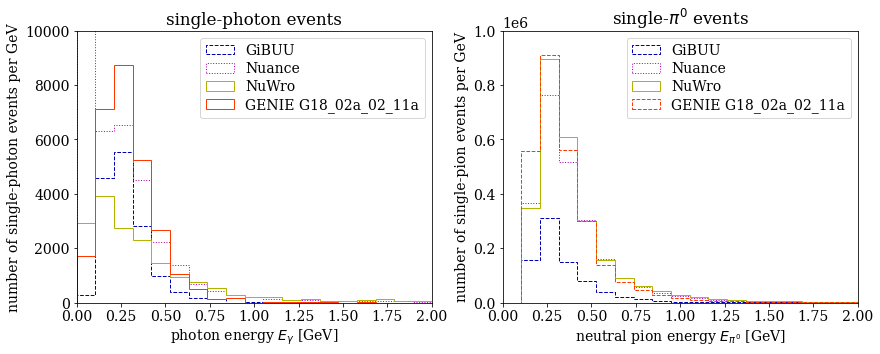

In [24]:
# generate MC histograms
bin_edges_E_gamma   = np.linspace(0,2,20) * u.GeV
bin_centers_E_gamma = 0.5 * (bin_edges_E_gamma[1:] + bin_edges_E_gamma[:-1])
bin_widths_E_gamma  = np.diff(bin_edges_E_gamma)
dNdE_gamma          = {}
dNdE_pi0            = {}
mc_generators       = set([k[0] for k in event_files.keys()])
for k in mc_generators:
    dNdE_gamma[k] = np.histogram(np.concatenate([E_gamma_table[kk] for kk in event_files.keys() if kk[0]==k]), bins=bin_edges_E_gamma,
                                 weights=np.concatenate([weights_gamma[kk] for kk in event_files.keys() if kk[0]==k]))[0] / bin_widths_E_gamma
    dNdE_pi0[k]   = np.histogram(np.concatenate([E_pi0_table[kk] for kk in event_files.keys() if kk[0]==k]), bins=bin_edges_E_gamma,
                                 weights=np.concatenate([weights_pi0[kk] for kk in event_files.keys() if kk[0]==k]))[0] / bin_widths_E_gamma

plt.figure(figsize=(14,5))
plt.subplot(121)
plt.hist(bin_centers_E_gamma/u.GeV, bins=bin_edges_E_gamma/u.GeV, weights=dNdE_gamma['gibuu']*u.GeV,
         label='GiBUU', histtype='step', color=my_colors['gibuu'], ls='--')
plt.hist(bin_centers_E_gamma/u.GeV, bins=bin_edges_E_gamma/u.GeV, weights=dNdE_gamma['nuance']*u.GeV,
         label='Nuance', histtype='step', color=my_colors['nuance'], ls=':')
plt.hist(bin_centers_E_gamma/u.GeV, bins=bin_edges_E_gamma/u.GeV, weights=dNdE_gamma['nuwro']*u.GeV,
         label='NuWro', histtype='step', color=my_colors['nuwro'], ls='-')
for t in genie_tunes:
    plt.hist(bin_centers_E_gamma/u.GeV, bins=bin_edges_E_gamma/u.GeV, weights=dNdE_gamma['genie-'+t]*u.GeV,
             label='GENIE '+genie_tunes[t], histtype='step',
             color=my_colors['genie-'+t], ls=next(ls_cycler))
plt.xlabel('photon energy $E_\\gamma$ [GeV]')
plt.ylabel('number of single-photon events per GeV')
plt.title('single-photon events')
plt.legend(loc='upper right', labelspacing=0.3)
plt.xlim(0,2)
plt.ylim(0,1e4)

plt.subplot(122)
plt.hist(bin_centers_E_gamma/u.GeV, bins=bin_edges_E_gamma/u.GeV, weights=dNdE_pi0['gibuu']*u.GeV,
         label='GiBUU', histtype='step', color=my_colors['gibuu'], ls='--')
plt.hist(bin_centers_E_gamma/u.GeV, bins=bin_edges_E_gamma/u.GeV, weights=dNdE_pi0['nuance']*u.GeV,
         label='Nuance', histtype='step', color=my_colors['nuance'], ls=':')
plt.hist(bin_centers_E_gamma/u.GeV, bins=bin_edges_E_gamma/u.GeV, weights=dNdE_pi0['nuwro']*u.GeV,
         label='NuWro', histtype='step', color=my_colors['nuwro'], ls='-')
for t in genie_tunes:
    plt.hist(bin_centers_E_gamma/u.GeV, bins=bin_edges_E_gamma/u.GeV, weights=dNdE_pi0['genie-'+t]*u.GeV,
             label='GENIE '+genie_tunes[t], histtype='step',
             color=my_colors['genie-'+t], ls=next(ls_cycler))
plt.xlabel('neutral pion energy $E_{\\pi^0}$ [GeV]')
plt.ylabel('number of single-pion events per GeV')
plt.title('single-$\\pi^0$ events')
plt.legend(loc='upper right', labelspacing=0.3)
plt.xlim(0,2)
plt.ylim(0,1e6)
plt.show()